# TESS Atlas fit for TOI 198

**Version: 0.1.1**

**Note: This notebook was automatically generated as part of the TESS Atlas project. More information can be found on GitHub:** [github.com/dfm/tess-atlas](https://github.com/dfm/tess-atlas)

In this notebook, we do a quicklook fit for the parameters of the TESS Objects of Interest (TOI) in the system number 198.
To do this fit, we use the [exoplanet](https://exoplanet.dfm.io) library and you can find more information about that project at [exoplanet.dfm.io](https://exoplanet.dfm.io).

From here, you can scroll down and take a look at the fit results, or you can:

- [open the notebook in Google Colab to run the fit yourself](https://colab.research.google.com/github/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-198.ipynb),
- [view the notebook on GitHub](https://github.com/dfm/tess-atlas/blob/master/notebooks/0.1.1/toi-198.ipynb), or
- [download the notebook](https://github.com/dfm/tess-atlas/raw/master/notebooks/0.1.1/toi-198.ipynb).

## Caveats

There are many caveats associated with this relatively simple "quicklook" type of analysis that should be kept in mind.
Here are some of the main things that come to mind:

1. The orbits that we fit are constrained to be *circular*. One major effect of this approximation is that the fit will significantly overestimate the confidence of the impact parameter constraint, so the results for impact parameter shouldn't be taken too seriously. 

2. Transit timing variations, correlated noise, and (probably) your favorite systematics are ignored. Sorry!

3. This notebook was generated automatically without human intervention. Use at your own risk!

## Table of Contents

1. [Getting started](#Getting-started)
2. [Data & de-trending](#Data-%26amp%3B-de-trending)
3. [Removing stellar variability](#Removing-stellar-variability)
4. [Transit model in PyMC3 & exoplanet](#Transit-model-in-PyMC3-%26amp%3B-exoplanet)
5. [Sampling](#Sampling)
6. [Posterior constraints](#Posterior-constraints)
7. [Attribution](#Attribution)

## Getting started

To get going, we'll need to make out plots show up inline and install a few packages:

In [1]:
%matplotlib inline
!pip install -q -U lightkurve fbpca exoplanet corner pymc3

Then we'll set up the plotting styles and do all of the imports:

In [2]:
import matplotlib.pyplot as plt
plt.style.use("default")

from matplotlib import rcParams
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16
rcParams["text.usetex"] = False
rcParams["font.family"] = ["sans-serif"]
rcParams["font.sans-serif"] = ["cmss10"]
rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
import logging
logger = logging.getLogger("theano.gof.compilelock")
logger.setLevel(logging.ERROR)

import corner
import numpy as np
import pandas as pd
import lightkurve as lk
import matplotlib.pyplot as plt

import pymc3 as pm
import exoplanet as xo
import theano.tensor as tt

## Data & de-trending

Next, we grab the TOI list from [ExoFOP](https://exofop.ipac.caltech.edu/tess/) to get the information about the system:

In [3]:
toi_num = 198

# Get the table of TOI info from ExoFOP
tois = pd.read_csv("https://exofop.ipac.caltech.edu/tess/download_toi.php?sort=toi&output=csv")

# Select all of the rows in the TOI table that are associated with this target
toi = tois[tois["TOI"] == toi_num + 0.01].iloc[0]
tic = toi['TIC ID']
tois = tois[tois["TIC ID"] == tic].sort_values("TOI")

# Extract the planet periods
periods = np.array(tois["Period (days)"], dtype=float)

# Convert the phase to TBJD from BJD
t0s = np.array(tois["Epoch (BJD)"], dtype=float) - 2457000

# Convert the depth to parts per thousand from parts per million
depths = 1e-3 * np.array(tois["Depth (ppm)"], dtype=float)

# Convert the duration to days from hours
durations = np.array(tois["Duration (hours)"], dtype=float) / 24.0

# Extract the stellar radius from the table
toi_r_star = toi['Stellar Radius (R_Sun)']
toi_r_star_err = toi['Stellar Radius (R_Sun) err']
toi_logg_star = toi['Stellar log(g) (cm/s^2)']
toi_logg_star_err = toi['Stellar log(g) (cm/s^2) err']

# If there is no entry in the table (does this ever happen?)
if not (np.isfinite(toi_r_star) and np.isfinite(toi_r_star_err)):
    raise ValueError("no radius measurement in table")
if not (np.isfinite(toi_logg_star) and np.isfinite(toi_logg_star_err)):
    raise ValueError("no logg measurement in table")

# These are the letters that will be used to identify each candidate
# (are we being a bit optimistic?)
letters = "bcdefghijklmnopqrstuvwxyz"[:len(periods)]

Then we use the [lightkurve](https://docs.lightkurve.org) library to download and de-trend the time series using [pixel-level decorrelation (PLD)](https://docs.lightkurve.org/api/lightkurve.correctors.PLDCorrector.html).
We read in target pixel files (TPFs) for each of the campaigns in which TOI 198 was observed.
To remove systematic noise, we mask out known transits and perform second order PLD. The noise-corrected light curves are stitched together to create a single contiguous light curve.

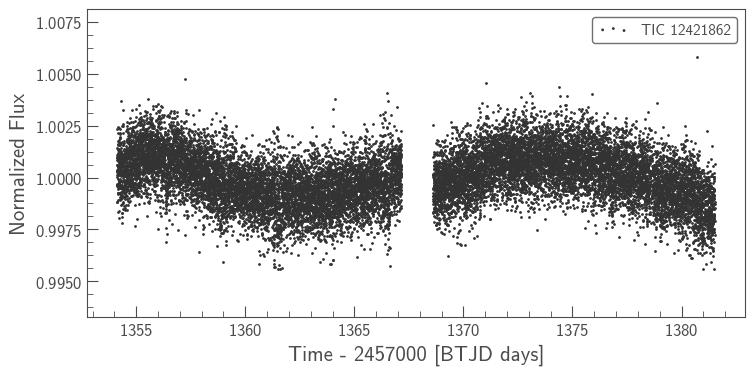

In [4]:
# Download the target pixel files
sr = lk.search_targetpixelfile('TIC %i' % tic)
tpf_collection = sr.download_all(quality_bitmask="hardest")
if tpf_collection is None or not len(tpf_collection):
    raise ValueError("the TESS atlas only works for TPF files")
    
# Extract the exposure time associated with the TPF
hdr = tpf_collection[0].hdu[1].header
texp = hdr["FRAMETIM"] * hdr["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0

# This function can be used to estimate which data points are in transit
# for known phase, period, and duration
def get_transit_mask(t, t0, period, duration):
    hp = 0.5*period
    return np.abs((t-t0+hp) % period - hp) < 0.5*duration

# Run PLD on each TPF to extract the light curves
lc_collection = []
for tpf in tpf_collection:
    mask = np.zeros_like(tpf.time, dtype=bool)
    for i in range(len(periods)):
        mask |= get_transit_mask(tpf.time, t0s[i], periods[i], 5*durations[i])
    pld = tpf.to_corrector("pld")
    try:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=2)
    except ValueError:
        lc = pld.correct(aperture_mask="pipeline", cadence_mask=~mask, use_gp=False, pld_order=1)
    lc_collection.append(lc.normalize())

# Normalize and stitch the sectors
lc = lc_collection[0]
if len(lc_collection) > 1:
    lc = lc.append([next_lc for next_lc in lc_collection[1:]])
    
# Remove outliers
_, outliers = lc.remove_outliers(return_mask=True)
mask = np.zeros_like(lc.time, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(lc.time, t0s[i], periods[i], 2*durations[i])
outliers[mask] = False
lc = lc[~outliers]
    
lc.scatter();

# Removing stellar variability

Next up, we remove stellar variability using a Gaussian Processes model fit to the out of transit data.

In [5]:
# Extract the data and convert to parts per thousand
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray((lc.flux - 1.0) * 1e3, dtype=np.float64)
yerr = np.ascontiguousarray(lc.flux_err * 1e3, dtype=np.float64)

# Compute the transit mask
mask = np.zeros_like(x, dtype=bool)
for i in range(len(periods)):
    mask |= get_transit_mask(x, t0s[i], periods[i], 5*durations[i])

# Temporarily increase the in transit error bars substantially
diag = np.array(yerr**2)
diag[mask] += 10000.0

# Build a GP model
with pm.Model() as model:
    logs2 = pm.Normal("logs2", mu=np.log(1e-4*np.var(y)), sd=10)
    logsigma = pm.Normal("logsigma", mu=np.log(np.std(y)), sd=10)
    logrho = pm.Normal("logrho", mu=np.log(10.0), sd=10.0)
    
    kernel = xo.gp.terms.Matern32Term(log_sigma=logsigma, log_rho=logrho)
    gp = xo.gp.GP(kernel, x, diag + tt.exp(logs2), J=2)
    pm.Potential("loglike", gp.log_likelihood(y))
    
    map_soln = xo.optimize()
    pred = xo.utils.eval_in_model(gp.predict(), map_soln)

# Flatten the light curve
y -= pred

optimizing logp for variables: ['logrho', 'logsigma', 'logs2']


message: Optimization terminated successfully.
logp: -29125.20553854505 -> -28989.963239488436


## Transit model in PyMC3 & exoplanet

Here's how we set up the transit model using [exoplanet](https://exoplanet.dfm.io) and [PyMC3](https://docs.pymc.io).
For more information about how to use these libraries take a look at the docs that are linked above.
In this model, the parameters that we're fitting are:

* `mean`: the mean (out-of-transit) flux of the star,
* `r_star`: the radius of the star (with the prior from the TOI list),
* `logg_star`: the surface gravity of the star (with the prior from the TOI list),
* `u`: the quadratic limb darkening parameters, parameterized following [Kipping (2013)](https://arxiv.org/abs/1308.0009)
* `t0`: the time of a reference transit for each planet,
* `logP`: the log of the obribatl periods,
* `r`: the planet radius ratios (relative to the star),
* `b`: the impact parameter in units of the stellar radius, `b` and `r` are both parameterized following [Espinoza (2018)](https://iopscience.iop.org/article/10.3847/2515-5172/aaef38/meta), and
* `logs2`: a jitter parameter that captures excess noise or underrestimated error bars.

A few key assumptions include:

* The orbits are assumed to be circular so the constraints on impact parameter (which would be severely degenerate with eccentricity) will be tighter than they should be.
* The noise is assumed to be Gaussian and independent. This means that all correlated noise should be removed in advance. Since we flattened the light curve using a Gaussian process above, this should be not totally unreasonable.
* We are neglecting transit times (the ephemeris is assumed to be linear) which should be sufficient for most cases with the short TESS baseline, but transit timing variations could be important for some targets.

In [6]:
# factor * 10**logg / r_star = rho
factor = 5.141596357654149e-05

def build_model(x, y, yerr, periods, t0s, depths, mask=None, start=None):
    """Build an exoplanet model for a dataset and set of planets
    
    Args:
        x: The time series (in days); this should probably be centered
        y: The relative fluxes (in parts per thousand)
        yerr: The uncertainties on ``y``
        periods: The periods of the planets (in days)
        t0s: The phases of the planets in the same coordinates as ``x``
        depths: The depths of the transits in parts per thousand
        mask: A boolean mask with the same shape as ``x`` indicating which
            data points should be included in the fit
        start: A dictionary of model parameters where the optimization
            should be initialized
            
    Returns:
        A PyMC3 model specifying the probabilistic model for the light curve

    """
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    
    periods = np.atleast_1d(periods)
    t0s = np.atleast_1d(t0s)
    depths = np.atleast_1d(depths)
    n_planets = len(periods)
    
    with pm.Model() as model:
        
        # Extract the un-masked data points
        model.x = x[mask]
        model.y = y[mask]
        model.yerr = (yerr + np.zeros_like(x))[mask]
        model.mask = mask

        # The baseline (out-of-transit) flux for the star in ppt. This
        # should be close to one because of how we normalized the data
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        
        logg_star = pm.Normal("logg_star", mu=toi_logg_star, sd=toi_logg_star_err)
        r_star = pm.Bound(pm.Normal, lower=0.0)("r_star", mu=toi_r_star, sd=toi_r_star_err)
        rho_star = pm.Deterministic("rho_star", factor * 10**logg_star / r_star)

        # The time of a reference transit for each planet
        t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=n_planets)

        # The log period; also tracking the period itself
        logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=n_planets)
        period = pm.Deterministic("period", tt.exp(logP))

        # The Kipping (2013) parameterization for quadratic limb darkening paramters
        u = xo.distributions.QuadLimbDark("u")

        # The Espinoza (2018) parameterization for the joint radius ratio and
        # impact parameter distribution
        r, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.001, max_radius=1.0,
            testval_r=np.sqrt(1e-3*np.array(depths)),
            testval_b=0.5+np.zeros(n_planets)
        )
        r_pl = pm.Deterministic("r_pl", r * r_star)

        # This shouldn't make a huge difference, but I like to put a uniform
        # prior on the *log* of the radius ratio instead of the value. This
        # can be implemented by adding a custom "potential" (log probability).
        pm.Potential("r_prior", -pm.math.log(r))

        # Set up a Keplerian orbit for the planets
        model.orbit = xo.orbits.KeplerianOrbit(
            period=period, t0=t0, b=b, r_star=r_star, rho_star=rho_star)
        
        # Compute the model light curve using starry
        model.light_curves = xo.StarryLightCurve(u).get_light_curve(
            orbit=model.orbit, r=r_pl, t=model.x)
        model.light_curve = pm.math.sum(model.light_curves, axis=-1) * 1e3 + mean

        # Jitter and likelihood function
        logs2 = pm.Normal("logs2", mu=np.log(np.mean(model.yerr)), sd=10)
        pm.Normal("obs", mu=model.light_curve, sd=tt.sqrt(model.yerr**2+tt.exp(logs2)),
                  observed=model.y)

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = start        
        map_soln = xo.optimize(start=map_soln, vars=[logs2, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln, vars=[logg_star])
        map_soln = xo.optimize(start=map_soln, vars=[logP, t0, mean])
        map_soln = xo.optimize(start=map_soln, vars=[model.rb, mean])
        map_soln = xo.optimize(start=map_soln)
        model.map_soln = map_soln
        
    return model

def build_model_sigma_clip(x, y, yerr, periods, t0s, depths, sigma=5.0, maxiter=10, start=None):
    ntot = len(x)
    for i in range(maxiter):
        print("*** Sigma clipping round {0} ***".format(i+1))
        
        # Build the model
        model = build_model(x, y, yerr, periods, t0s, depths, start=start)
        start = model.map_soln

        # Compute the map prediction
        with model:
            mod = xo.utils.eval_in_model(model.light_curve, model.map_soln)
            
        # Do sigma clipping
        resid = y - mod
        rms = np.sqrt(np.median(resid**2))
        mask = np.abs(resid) < sigma * rms
        if ntot == mask.sum():
            break
        ntot = mask.sum()

    return model

Using the above function, we'll generate a probabilistic model for the light curve and plot the maximum a posteriori fit.

*** Sigma clipping round 1 ***


optimizing logp for variables: ['mean', 'logs2']


message: Desired error not necessarily achieved due to precision loss.
logp: -27795.72036690272 -> -26544.966964145722


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Desired error not necessarily achieved due to precision loss.
logp: -26544.966964145722 -> -26514.27025199081


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -26514.27025199081 -> -26514.261690927953


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -26514.261690927953 -> -26513.804210194496


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -26513.804210194496 -> -26513.800776678338


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -26513.800776678338 -> -26284.688139890375


*** Sigma clipping round 2 ***


optimizing logp for variables: ['mean', 'logs2']


message: Optimization terminated successfully.
logp: -26284.688139890375 -> -26284.688139890375


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -26284.688139890375 -> -26284.688139890375


optimizing logp for variables: ['logg_star']


message: Optimization terminated successfully.
logp: -26284.688139890375 -> -26284.688139890375


optimizing logp for variables: ['mean', 't0', 'logP']


message: Desired error not necessarily achieved due to precision loss.
logp: -26284.688139890375 -> -26284.688139890375


optimizing logp for variables: ['mean', 'rb_radiusimpact__']


message: Optimization terminated successfully.
logp: -26284.688139890375 -> -26284.688139890375


optimizing logp for variables: ['logs2', 'rb_radiusimpact__', 'u_quadlimbdark__', 'logP', 't0', 'r_star_lowerbound__', 'logg_star', 'mean']


message: Desired error not necessarily achieved due to precision loss.
logp: -26284.688139890375 -> -26284.688139890375


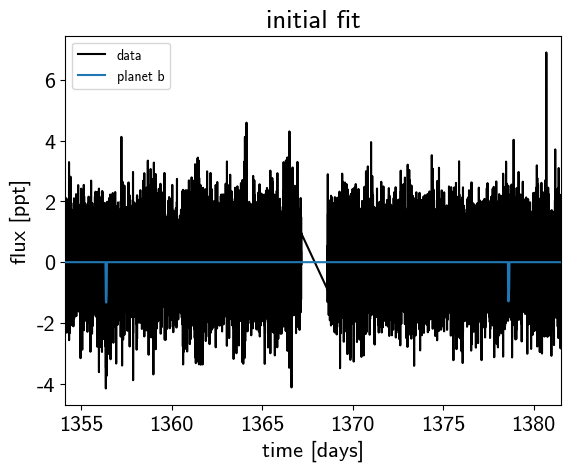

In [7]:
model = build_model_sigma_clip(x, y, yerr, periods, t0s, depths)

with model:
    mean = model.map_soln["mean"]
    light_curves = xo.utils.eval_in_model(model.light_curves, model.map_soln)

plt.plot(model.x, model.y - mean, "k", label="data")
for n, l in enumerate(letters):
    plt.plot(model.x, 1e3 * light_curves[:, n], label="planet {0}".format(l), zorder=100-n)

plt.xlabel("time [days]")
plt.ylabel("flux [ppt]")
plt.title("initial fit")
plt.xlim(model.x.min(), model.x.max())
plt.legend(fontsize=10);

## Sampling

Now we use PyMC3 to sample the posterior density for the parameters of this model.

In [8]:
np.random.seed(123)
sampler = xo.PyMC3Sampler(window=50, start=50, finish=500)
with model:
    burnin = sampler.tune(tune=3000, start=model.map_soln,
                          step_kwargs=dict(target_accept=0.9),
                          chains=2, cores=2)
    trace = sampler.sample(draws=1000, chains=2, cores=2)

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   8%|▊         | 8/104 [00:00<00:01, 75.89draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:11,  7.86draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:17,  5.17draws/s]

Sampling 2 chains:  14%|█▍        | 15/104 [00:02<00:20,  4.27draws/s]

Sampling 2 chains:  16%|█▋        | 17/104 [00:03<00:22,  3.79draws/s]

Sampling 2 chains:  18%|█▊        | 19/104 [00:03<00:23,  3.67draws/s]

Sampling 2 chains:  20%|██        | 21/104 [00:04<00:22,  3.61draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:05<00:22,  3.58draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:21,  3.66draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:17,  4.45draws/s]

Sampling 2 chains:  26%|██▌       | 27/104 [00:06<00:24,  3.16draws/s]

Sampling 2 chains:  28%|██▊       | 29/104 [00:06<00:23,  3.16draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:06<00:19,  3.74draws/s]

Sampling 2 chains:  30%|██▉       | 31/104 [00:07<00:24,  2.94draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:20,  3.50draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:08<00:22,  3.11draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:19,  3.59draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:21,  3.21draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:08<00:18,  3.67draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:20,  3.20draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:09<00:17,  3.87draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:22,  2.93draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:10<00:20,  3.13draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:10<00:18,  3.27draws/s]

Sampling 2 chains:  42%|████▏     | 44/104 [00:11<00:15,  3.81draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:18,  3.22draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:11<00:15,  3.81draws/s]

Sampling 2 chains:  45%|████▌     | 47/104 [00:12<00:17,  3.23draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:12<00:14,  3.95draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:12<00:17,  3.20draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:12<00:15,  3.58draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:13<00:16,  3.13draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:13<00:13,  3.84draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:13<00:16,  3.04draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:14<00:15,  3.18draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:15<00:14,  3.28draws/s]

Sampling 2 chains:  56%|█████▌    | 58/104 [00:15<00:11,  3.96draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:15<00:14,  3.17draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:15<00:13,  3.18draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:16<00:12,  3.37draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:16<00:15,  2.75draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:17<00:13,  2.96draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:17<00:12,  3.12draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:18<00:10,  3.37draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:18<00:10,  3.30draws/s]

Sampling 2 chains:  66%|██████▋   | 69/104 [00:18<00:12,  2.88draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:19<00:11,  2.94draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:19<00:08,  3.66draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:20<00:10,  3.04draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:20<00:09,  3.20draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:20<00:08,  3.26draws/s]

Sampling 2 chains:  73%|███████▎  | 76/104 [00:20<00:08,  3.35draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:21<00:07,  3.61draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:21<00:07,  3.47draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:21<00:06,  3.82draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:22<00:06,  3.47draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:22<00:05,  3.97draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:22<00:06,  3.37draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:22<00:05,  4.15draws/s]

Sampling 2 chains:  81%|████████  | 84/104 [00:23<00:06,  3.31draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:23<00:04,  4.06draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:23<00:05,  3.31draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:23<00:04,  4.03draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:24<00:04,  3.44draws/s]

Sampling 2 chains:  86%|████████▌ | 89/104 [00:24<00:03,  4.05draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:24<00:04,  3.21draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:25<00:03,  3.77draws/s]

Sampling 2 chains:  89%|████████▉ | 93/104 [00:25<00:03,  3.59draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:25<00:02,  3.45draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:25<00:02,  3.66draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:26<00:02,  3.02draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:26<00:01,  3.81draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:27<00:02,  2.89draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:27<00:01,  3.53draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:28<00:01,  2.30draws/s]

Sampling 2 chains:  97%|█████████▋| 101/104 [00:28<00:01,  1.91draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:29<00:01,  1.80draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:31<00:00,  1.37draws/s]

Sampling 2 chains:   0%|          | 0/104 [00:00<?, ?draws/s]

Sampling 2 chains:   9%|▊         | 9/104 [00:00<00:09, 10.44draws/s]

Sampling 2 chains:  11%|█         | 11/104 [00:01<00:17,  5.30draws/s]

Sampling 2 chains:  12%|█▎        | 13/104 [00:01<00:13,  6.75draws/s]

Sampling 2 chains:  13%|█▎        | 14/104 [00:02<00:24,  3.68draws/s]

Sampling 2 chains:  15%|█▌        | 16/104 [00:02<00:24,  3.56draws/s]

Sampling 2 chains:  17%|█▋        | 18/104 [00:03<00:24,  3.51draws/s]

Sampling 2 chains:  19%|█▉        | 20/104 [00:04<00:24,  3.38draws/s]

Sampling 2 chains:  21%|██        | 22/104 [00:04<00:22,  3.70draws/s]

Sampling 2 chains:  22%|██▏       | 23/104 [00:04<00:19,  4.13draws/s]

Sampling 2 chains:  23%|██▎       | 24/104 [00:05<00:23,  3.42draws/s]

Sampling 2 chains:  24%|██▍       | 25/104 [00:05<00:19,  4.13draws/s]

Sampling 2 chains:  25%|██▌       | 26/104 [00:05<00:25,  3.09draws/s]

Sampling 2 chains:  27%|██▋       | 28/104 [00:06<00:24,  3.10draws/s]

Sampling 2 chains:  29%|██▉       | 30/104 [00:07<00:23,  3.17draws/s]

Sampling 2 chains:  31%|███       | 32/104 [00:07<00:22,  3.27draws/s]

Sampling 2 chains:  32%|███▏      | 33/104 [00:07<00:20,  3.47draws/s]

Sampling 2 chains:  33%|███▎      | 34/104 [00:08<00:25,  2.77draws/s]

Sampling 2 chains:  34%|███▎      | 35/104 [00:08<00:20,  3.39draws/s]

Sampling 2 chains:  35%|███▍      | 36/104 [00:09<00:24,  2.76draws/s]

Sampling 2 chains:  36%|███▌      | 37/104 [00:09<00:22,  2.98draws/s]

Sampling 2 chains:  37%|███▋      | 38/104 [00:09<00:20,  3.25draws/s]

Sampling 2 chains:  38%|███▊      | 39/104 [00:09<00:21,  2.95draws/s]

Sampling 2 chains:  38%|███▊      | 40/104 [00:10<00:17,  3.58draws/s]

Sampling 2 chains:  39%|███▉      | 41/104 [00:10<00:22,  2.84draws/s]

Sampling 2 chains:  41%|████▏     | 43/104 [00:11<00:21,  2.79draws/s]

Sampling 2 chains:  43%|████▎     | 45/104 [00:11<00:16,  3.62draws/s]

Sampling 2 chains:  44%|████▍     | 46/104 [00:12<00:21,  2.69draws/s]

Sampling 2 chains:  46%|████▌     | 48/104 [00:12<00:19,  2.87draws/s]

Sampling 2 chains:  47%|████▋     | 49/104 [00:12<00:16,  3.27draws/s]

Sampling 2 chains:  48%|████▊     | 50/104 [00:13<00:17,  3.11draws/s]

Sampling 2 chains:  49%|████▉     | 51/104 [00:13<00:18,  2.85draws/s]

Sampling 2 chains:  50%|█████     | 52/104 [00:13<00:15,  3.35draws/s]

Sampling 2 chains:  51%|█████     | 53/104 [00:14<00:16,  3.09draws/s]

Sampling 2 chains:  52%|█████▏    | 54/104 [00:14<00:15,  3.32draws/s]

Sampling 2 chains:  53%|█████▎    | 55/104 [00:15<00:18,  2.71draws/s]

Sampling 2 chains:  54%|█████▍    | 56/104 [00:15<00:14,  3.35draws/s]

Sampling 2 chains:  55%|█████▍    | 57/104 [00:15<00:18,  2.58draws/s]

Sampling 2 chains:  57%|█████▋    | 59/104 [00:16<00:16,  2.81draws/s]

Sampling 2 chains:  58%|█████▊    | 60/104 [00:16<00:13,  3.33draws/s]

Sampling 2 chains:  59%|█████▊    | 61/104 [00:16<00:14,  2.96draws/s]

Sampling 2 chains:  60%|█████▉    | 62/104 [00:17<00:13,  3.12draws/s]

Sampling 2 chains:  61%|██████    | 63/104 [00:17<00:13,  3.10draws/s]

Sampling 2 chains:  62%|██████▏   | 64/104 [00:17<00:13,  2.87draws/s]

Sampling 2 chains:  62%|██████▎   | 65/104 [00:18<00:11,  3.36draws/s]

Sampling 2 chains:  63%|██████▎   | 66/104 [00:18<00:12,  3.05draws/s]

Sampling 2 chains:  64%|██████▍   | 67/104 [00:18<00:10,  3.47draws/s]

Sampling 2 chains:  65%|██████▌   | 68/104 [00:19<00:13,  2.68draws/s]

Sampling 2 chains:  67%|██████▋   | 70/104 [00:19<00:12,  2.82draws/s]

Sampling 2 chains:  68%|██████▊   | 71/104 [00:20<00:09,  3.40draws/s]

Sampling 2 chains:  69%|██████▉   | 72/104 [00:20<00:10,  3.00draws/s]

Sampling 2 chains:  70%|███████   | 73/104 [00:20<00:10,  3.04draws/s]

Sampling 2 chains:  71%|███████   | 74/104 [00:21<00:09,  3.20draws/s]

Sampling 2 chains:  72%|███████▏  | 75/104 [00:21<00:10,  2.68draws/s]

Sampling 2 chains:  74%|███████▍  | 77/104 [00:21<00:07,  3.41draws/s]

Sampling 2 chains:  75%|███████▌  | 78/104 [00:22<00:08,  2.91draws/s]

Sampling 2 chains:  76%|███████▌  | 79/104 [00:22<00:08,  3.04draws/s]

Sampling 2 chains:  77%|███████▋  | 80/104 [00:22<00:08,  2.87draws/s]

Sampling 2 chains:  78%|███████▊  | 81/104 [00:23<00:07,  2.94draws/s]

Sampling 2 chains:  79%|███████▉  | 82/104 [00:23<00:06,  3.29draws/s]

Sampling 2 chains:  80%|███████▉  | 83/104 [00:24<00:07,  2.78draws/s]

Sampling 2 chains:  82%|████████▏ | 85/104 [00:24<00:06,  2.97draws/s]

Sampling 2 chains:  83%|████████▎ | 86/104 [00:24<00:05,  3.50draws/s]

Sampling 2 chains:  84%|████████▎ | 87/104 [00:25<00:05,  3.29draws/s]

Sampling 2 chains:  85%|████████▍ | 88/104 [00:25<00:05,  2.90draws/s]

Sampling 2 chains:  87%|████████▋ | 90/104 [00:26<00:04,  2.97draws/s]

Sampling 2 chains:  88%|████████▊ | 92/104 [00:26<00:03,  3.14draws/s]

Sampling 2 chains:  90%|█████████ | 94/104 [00:27<00:03,  3.28draws/s]

Sampling 2 chains:  91%|█████████▏| 95/104 [00:27<00:02,  3.40draws/s]

Sampling 2 chains:  92%|█████████▏| 96/104 [00:27<00:02,  3.33draws/s]

Sampling 2 chains:  93%|█████████▎| 97/104 [00:28<00:02,  3.40draws/s]

Sampling 2 chains:  94%|█████████▍| 98/104 [00:28<00:01,  3.38draws/s]

Sampling 2 chains:  95%|█████████▌| 99/104 [00:28<00:01,  3.50draws/s]

Sampling 2 chains:  96%|█████████▌| 100/104 [00:29<00:01,  2.76draws/s]

Sampling 2 chains:  98%|█████████▊| 102/104 [00:30<00:00,  2.72draws/s]

Sampling 2 chains:  99%|█████████▉| 103/104 [00:30<00:00,  2.71draws/s]

Sampling 2 chains: 100%|██████████| 104/104 [00:31<00:00,  1.52draws/s]

Sampling 2 chains:   0%|          | 0/204 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/204 [00:00<01:20,  2.52draws/s]

Sampling 2 chains:   1%|▏         | 3/204 [00:00<01:00,  3.31draws/s]

Sampling 2 chains:   2%|▏         | 5/204 [00:00<00:48,  4.11draws/s]

Sampling 2 chains:   3%|▎         | 6/204 [00:01<00:57,  3.42draws/s]

Sampling 2 chains:   3%|▎         | 7/204 [00:01<00:48,  4.10draws/s]

Sampling 2 chains:   4%|▍         | 8/204 [00:01<01:00,  3.24draws/s]

Sampling 2 chains:   5%|▍         | 10/204 [00:02<00:56,  3.46draws/s]

Sampling 2 chains:   5%|▌         | 11/204 [00:02<00:51,  3.75draws/s]

Sampling 2 chains:   6%|▌         | 12/204 [00:02<00:41,  4.60draws/s]

Sampling 2 chains:   6%|▋         | 13/204 [00:02<00:44,  4.28draws/s]

Sampling 2 chains:   7%|▋         | 15/204 [00:03<00:35,  5.36draws/s]

Sampling 2 chains:   8%|▊         | 16/204 [00:03<00:34,  5.47draws/s]

Sampling 2 chains:   8%|▊         | 17/204 [00:03<00:57,  3.25draws/s]

Sampling 2 chains:   9%|▉         | 19/204 [00:03<00:44,  4.11draws/s]

Sampling 2 chains:  10%|▉         | 20/204 [00:04<01:04,  2.84draws/s]

Sampling 2 chains:  11%|█         | 22/204 [00:05<00:58,  3.09draws/s]

Sampling 2 chains:  11%|█▏        | 23/204 [00:05<00:55,  3.24draws/s]

Sampling 2 chains:  12%|█▏        | 24/204 [00:05<01:05,  2.75draws/s]

Sampling 2 chains:  12%|█▏        | 25/204 [00:05<00:51,  3.48draws/s]

Sampling 2 chains:  13%|█▎        | 26/204 [00:06<01:00,  2.96draws/s]

Sampling 2 chains:  13%|█▎        | 27/204 [00:06<00:53,  3.29draws/s]

Sampling 2 chains:  14%|█▎        | 28/204 [00:06<00:56,  3.13draws/s]

Sampling 2 chains:  14%|█▍        | 29/204 [00:07<01:01,  2.84draws/s]

Sampling 2 chains:  15%|█▍        | 30/204 [00:07<00:50,  3.46draws/s]

Sampling 2 chains:  16%|█▌        | 32/204 [00:08<00:54,  3.16draws/s]

Sampling 2 chains:  17%|█▋        | 34/204 [00:08<00:53,  3.18draws/s]

Sampling 2 chains:  17%|█▋        | 35/204 [00:09<00:46,  3.65draws/s]

Sampling 2 chains:  18%|█▊        | 36/204 [00:09<00:46,  3.60draws/s]

Sampling 2 chains:  18%|█▊        | 37/204 [00:09<00:56,  2.94draws/s]

Sampling 2 chains:  19%|█▊        | 38/204 [00:09<00:44,  3.71draws/s]

Sampling 2 chains:  19%|█▉        | 39/204 [00:10<01:04,  2.55draws/s]

Sampling 2 chains:  20%|██        | 41/204 [00:10<00:50,  3.25draws/s]

Sampling 2 chains:  21%|██        | 43/204 [00:11<00:44,  3.59draws/s]

Sampling 2 chains:  23%|██▎       | 46/204 [00:11<00:34,  4.59draws/s]

Sampling 2 chains:  23%|██▎       | 47/204 [00:11<00:40,  3.88draws/s]

Sampling 2 chains:  24%|██▎       | 48/204 [00:12<00:33,  4.69draws/s]

Sampling 2 chains:  24%|██▍       | 49/204 [00:12<00:34,  4.54draws/s]

Sampling 2 chains:  25%|██▌       | 52/204 [00:12<00:26,  5.84draws/s]

Sampling 2 chains:  26%|██▌       | 53/204 [00:12<00:36,  4.15draws/s]

Sampling 2 chains:  27%|██▋       | 55/204 [00:13<00:32,  4.60draws/s]

Sampling 2 chains:  28%|██▊       | 57/204 [00:13<00:29,  4.99draws/s]

Sampling 2 chains:  29%|██▉       | 60/204 [00:13<00:27,  5.19draws/s]

Sampling 2 chains:  30%|███       | 62/204 [00:14<00:25,  5.49draws/s]

Sampling 2 chains:  31%|███▏      | 64/204 [00:14<00:27,  5.10draws/s]

Sampling 2 chains:  32%|███▏      | 65/204 [00:14<00:23,  5.89draws/s]

Sampling 2 chains:  32%|███▏      | 66/204 [00:15<00:24,  5.66draws/s]

Sampling 2 chains:  33%|███▎      | 68/204 [00:15<00:18,  7.19draws/s]

Sampling 2 chains:  34%|███▍      | 70/204 [00:15<00:17,  7.74draws/s]

Sampling 2 chains:  35%|███▌      | 72/204 [00:15<00:13,  9.44draws/s]

Sampling 2 chains:  36%|███▋      | 74/204 [00:15<00:19,  6.58draws/s]

Sampling 2 chains:  37%|███▋      | 76/204 [00:16<00:21,  6.00draws/s]

Sampling 2 chains:  38%|███▊      | 77/204 [00:16<00:23,  5.46draws/s]

Sampling 2 chains:  39%|███▉      | 80/204 [00:16<00:19,  6.32draws/s]

Sampling 2 chains:  40%|████      | 82/204 [00:17<00:21,  5.70draws/s]

Sampling 2 chains:  41%|████      | 84/204 [00:17<00:17,  6.70draws/s]

Sampling 2 chains:  42%|████▏     | 86/204 [00:17<00:14,  8.12draws/s]

Sampling 2 chains:  43%|████▎     | 88/204 [00:18<00:20,  5.56draws/s]

Sampling 2 chains:  44%|████▍     | 90/204 [00:18<00:18,  6.07draws/s]

Sampling 2 chains:  45%|████▍     | 91/204 [00:18<00:24,  4.61draws/s]

Sampling 2 chains:  45%|████▌     | 92/204 [00:19<00:23,  4.69draws/s]

Sampling 2 chains:  46%|████▌     | 93/204 [00:19<00:24,  4.48draws/s]

Sampling 2 chains:  46%|████▌     | 94/204 [00:19<00:23,  4.72draws/s]

Sampling 2 chains:  48%|████▊     | 97/204 [00:19<00:18,  5.84draws/s]

Sampling 2 chains:  48%|████▊     | 98/204 [00:20<00:29,  3.60draws/s]

Sampling 2 chains:  49%|████▉     | 100/204 [00:20<00:27,  3.83draws/s]

Sampling 2 chains:  50%|█████     | 102/204 [00:21<00:23,  4.39draws/s]

Sampling 2 chains:  51%|█████     | 104/204 [00:21<00:20,  4.99draws/s]

Sampling 2 chains:  53%|█████▎    | 108/204 [00:21<00:16,  5.78draws/s]

Sampling 2 chains:  53%|█████▎    | 109/204 [00:21<00:17,  5.35draws/s]

Sampling 2 chains:  54%|█████▍    | 110/204 [00:22<00:28,  3.35draws/s]

Sampling 2 chains:  55%|█████▍    | 112/204 [00:22<00:20,  4.43draws/s]

Sampling 2 chains:  56%|█████▌    | 114/204 [00:22<00:15,  5.75draws/s]

Sampling 2 chains:  57%|█████▋    | 116/204 [00:23<00:21,  4.04draws/s]

Sampling 2 chains:  57%|█████▋    | 117/204 [00:23<00:18,  4.64draws/s]

Sampling 2 chains:  59%|█████▉    | 120/204 [00:23<00:14,  5.68draws/s]

Sampling 2 chains:  59%|█████▉    | 121/204 [00:24<00:13,  6.16draws/s]

Sampling 2 chains:  60%|█████▉    | 122/204 [00:24<00:15,  5.22draws/s]

Sampling 2 chains:  60%|██████    | 123/204 [00:24<00:14,  5.68draws/s]

Sampling 2 chains:  61%|██████▏   | 125/204 [00:24<00:12,  6.10draws/s]

Sampling 2 chains:  62%|██████▏   | 126/204 [00:24<00:13,  5.83draws/s]

Sampling 2 chains:  62%|██████▏   | 127/204 [00:25<00:17,  4.35draws/s]

Sampling 2 chains:  63%|██████▎   | 128/204 [00:25<00:16,  4.66draws/s]

Sampling 2 chains:  63%|██████▎   | 129/204 [00:26<00:24,  3.08draws/s]

Sampling 2 chains:  64%|██████▍   | 131/204 [00:26<00:20,  3.62draws/s]

Sampling 2 chains:  65%|██████▌   | 133/204 [00:26<00:16,  4.30draws/s]

Sampling 2 chains:  66%|██████▌   | 134/204 [00:26<00:14,  4.84draws/s]

Sampling 2 chains:  66%|██████▌   | 135/204 [00:27<00:14,  4.70draws/s]

Sampling 2 chains:  67%|██████▋   | 137/204 [00:27<00:11,  6.07draws/s]

Sampling 2 chains:  68%|██████▊   | 138/204 [00:27<00:19,  3.40draws/s]

Sampling 2 chains:  68%|██████▊   | 139/204 [00:27<00:15,  4.11draws/s]

Sampling 2 chains:  69%|██████▊   | 140/204 [00:28<00:15,  4.07draws/s]

Sampling 2 chains:  69%|██████▉   | 141/204 [00:28<00:15,  4.12draws/s]

Sampling 2 chains:  71%|███████   | 144/204 [00:28<00:12,  4.92draws/s]

Sampling 2 chains:  71%|███████   | 145/204 [00:28<00:11,  5.31draws/s]

Sampling 2 chains:  72%|███████▏  | 147/204 [00:29<00:12,  4.63draws/s]

Sampling 2 chains:  73%|███████▎  | 148/204 [00:29<00:12,  4.36draws/s]

Sampling 2 chains:  73%|███████▎  | 149/204 [00:29<00:13,  4.16draws/s]

Sampling 2 chains:  74%|███████▎  | 150/204 [00:30<00:14,  3.65draws/s]

Sampling 2 chains:  74%|███████▍  | 151/204 [00:30<00:12,  4.13draws/s]

Sampling 2 chains:  75%|███████▍  | 152/204 [00:30<00:13,  3.88draws/s]

Sampling 2 chains:  75%|███████▌  | 154/204 [00:31<00:11,  4.44draws/s]

Sampling 2 chains:  76%|███████▋  | 156/204 [00:31<00:10,  4.73draws/s]

Sampling 2 chains:  77%|███████▋  | 158/204 [00:31<00:10,  4.28draws/s]

Sampling 2 chains:  78%|███████▊  | 159/204 [00:32<00:09,  4.71draws/s]

Sampling 2 chains:  78%|███████▊  | 160/204 [00:32<00:10,  4.05draws/s]

Sampling 2 chains:  79%|███████▉  | 161/204 [00:32<00:12,  3.56draws/s]

Sampling 2 chains:  79%|███████▉  | 162/204 [00:33<00:11,  3.50draws/s]

Sampling 2 chains:  81%|████████  | 165/204 [00:33<00:08,  4.59draws/s]

Sampling 2 chains:  81%|████████▏ | 166/204 [00:33<00:08,  4.53draws/s]

Sampling 2 chains:  82%|████████▏ | 168/204 [00:33<00:06,  5.54draws/s]

Sampling 2 chains:  83%|████████▎ | 169/204 [00:34<00:09,  3.60draws/s]

Sampling 2 chains:  84%|████████▍ | 172/204 [00:34<00:08,  3.99draws/s]

Sampling 2 chains:  85%|████████▌ | 174/204 [00:35<00:07,  3.79draws/s]

Sampling 2 chains:  86%|████████▌ | 175/204 [00:35<00:06,  4.66draws/s]

Sampling 2 chains:  87%|████████▋ | 177/204 [00:36<00:06,  4.13draws/s]

Sampling 2 chains:  88%|████████▊ | 179/204 [00:36<00:04,  5.04draws/s]

Sampling 2 chains:  88%|████████▊ | 180/204 [00:36<00:04,  5.18draws/s]

Sampling 2 chains:  89%|████████▊ | 181/204 [00:36<00:04,  4.82draws/s]

Sampling 2 chains:  89%|████████▉ | 182/204 [00:37<00:06,  3.38draws/s]

Sampling 2 chains:  90%|████████▉ | 183/204 [00:37<00:04,  4.21draws/s]

Sampling 2 chains:  91%|█████████ | 185/204 [00:37<00:03,  5.50draws/s]

Sampling 2 chains:  92%|█████████▏| 187/204 [00:38<00:04,  3.99draws/s]

Sampling 2 chains:  93%|█████████▎| 190/204 [00:38<00:02,  4.88draws/s]

Sampling 2 chains:  94%|█████████▎| 191/204 [00:38<00:03,  3.76draws/s]

Sampling 2 chains:  94%|█████████▍| 192/204 [00:39<00:02,  4.25draws/s]

Sampling 2 chains:  95%|█████████▍| 193/204 [00:39<00:03,  3.00draws/s]

Sampling 2 chains:  96%|█████████▌| 196/204 [00:39<00:01,  4.09draws/s]

Sampling 2 chains:  97%|█████████▋| 198/204 [00:39<00:01,  5.37draws/s]

Sampling 2 chains:  98%|█████████▊| 200/204 [00:40<00:00,  4.53draws/s]

Sampling 2 chains:  99%|█████████▉| 202/204 [00:40<00:00,  4.32draws/s]

Sampling 2 chains: 100%|█████████▉| 203/204 [00:41<00:00,  4.33draws/s]

Sampling 2 chains: 100%|██████████| 204/204 [00:41<00:00,  4.94draws/s]

Sampling 2 chains:   0%|          | 0/404 [00:00<?, ?draws/s]

Sampling 2 chains:   1%|          | 3/404 [00:00<00:18, 22.09draws/s]

Sampling 2 chains:   1%|▏         | 6/404 [00:00<00:30, 12.93draws/s]

Sampling 2 chains:   2%|▏         | 7/404 [00:00<00:47,  8.40draws/s]

Sampling 2 chains:   2%|▏         | 8/404 [00:01<00:58,  6.80draws/s]

Sampling 2 chains:   2%|▏         | 9/404 [00:01<00:58,  6.79draws/s]

Sampling 2 chains:   2%|▏         | 10/404 [00:01<00:58,  6.70draws/s]

Sampling 2 chains:   3%|▎         | 11/404 [00:01<00:59,  6.62draws/s]

Sampling 2 chains:   3%|▎         | 13/404 [00:01<00:51,  7.63draws/s]

Sampling 2 chains:   4%|▎         | 15/404 [00:01<00:46,  8.44draws/s]

Sampling 2 chains:   4%|▍         | 17/404 [00:01<00:40,  9.64draws/s]

Sampling 2 chains:   5%|▍         | 19/404 [00:02<00:47,  8.15draws/s]

Sampling 2 chains:   5%|▌         | 21/404 [00:02<00:43,  8.89draws/s]

Sampling 2 chains:   6%|▌         | 23/404 [00:02<00:39,  9.77draws/s]

Sampling 2 chains:   6%|▋         | 26/404 [00:02<00:32, 11.81draws/s]

Sampling 2 chains:   7%|▋         | 29/404 [00:03<00:35, 10.49draws/s]

Sampling 2 chains:   8%|▊         | 31/404 [00:03<00:33, 11.30draws/s]

Sampling 2 chains:   8%|▊         | 33/404 [00:03<00:34, 10.77draws/s]

Sampling 2 chains:   9%|▊         | 35/404 [00:03<00:33, 11.11draws/s]

Sampling 2 chains:   9%|▉         | 37/404 [00:03<00:32, 11.44draws/s]

Sampling 2 chains:  10%|▉         | 40/404 [00:03<00:26, 13.64draws/s]

Sampling 2 chains:  10%|█         | 42/404 [00:04<00:24, 15.07draws/s]

Sampling 2 chains:  11%|█         | 44/404 [00:04<00:25, 13.93draws/s]

Sampling 2 chains:  11%|█▏        | 46/404 [00:04<00:29, 12.02draws/s]

Sampling 2 chains:  12%|█▏        | 48/404 [00:04<00:27, 12.82draws/s]

Sampling 2 chains:  12%|█▏        | 50/404 [00:04<00:24, 14.27draws/s]

Sampling 2 chains:  13%|█▎        | 53/404 [00:04<00:21, 16.47draws/s]

Sampling 2 chains:  14%|█▍        | 58/404 [00:04<00:16, 20.40draws/s]

Sampling 2 chains:  15%|█▌        | 61/404 [00:05<00:16, 20.21draws/s]

Sampling 2 chains:  16%|█▌        | 65/404 [00:05<00:14, 23.66draws/s]

Sampling 2 chains:  17%|█▋        | 70/404 [00:05<00:12, 26.15draws/s]

Sampling 2 chains:  18%|█▊        | 74/404 [00:05<00:11, 28.66draws/s]

Sampling 2 chains:  19%|█▉        | 78/404 [00:05<00:12, 25.54draws/s]

Sampling 2 chains:  20%|██        | 81/404 [00:05<00:15, 20.92draws/s]

Sampling 2 chains:  21%|██        | 84/404 [00:05<00:14, 21.60draws/s]

Sampling 2 chains:  22%|██▏       | 87/404 [00:06<00:13, 23.54draws/s]

Sampling 2 chains:  22%|██▏       | 90/404 [00:06<00:15, 20.93draws/s]

Sampling 2 chains:  23%|██▎       | 93/404 [00:06<00:19, 15.82draws/s]

Sampling 2 chains:  24%|██▎       | 95/404 [00:06<00:20, 14.84draws/s]

Sampling 2 chains:  24%|██▍       | 98/404 [00:06<00:18, 16.21draws/s]

Sampling 2 chains:  25%|██▍       | 100/404 [00:06<00:17, 16.90draws/s]

Sampling 2 chains:  25%|██▌       | 103/404 [00:07<00:16, 17.86draws/s]

Sampling 2 chains:  26%|██▋       | 107/404 [00:07<00:15, 19.09draws/s]

Sampling 2 chains:  27%|██▋       | 110/404 [00:07<00:14, 20.97draws/s]

Sampling 2 chains:  28%|██▊       | 114/404 [00:07<00:12, 23.06draws/s]

Sampling 2 chains:  29%|██▉       | 118/404 [00:07<00:12, 23.65draws/s]

Sampling 2 chains:  30%|██▉       | 121/404 [00:07<00:14, 19.98draws/s]

Sampling 2 chains:  31%|███       | 124/404 [00:07<00:12, 21.62draws/s]

Sampling 2 chains:  31%|███▏      | 127/404 [00:08<00:13, 20.52draws/s]

Sampling 2 chains:  32%|███▏      | 130/404 [00:08<00:13, 21.05draws/s]

Sampling 2 chains:  33%|███▎      | 133/404 [00:08<00:13, 19.90draws/s]

Sampling 2 chains:  34%|███▎      | 136/404 [00:08<00:14, 18.15draws/s]

Sampling 2 chains:  34%|███▍      | 138/404 [00:08<00:16, 16.31draws/s]

Sampling 2 chains:  35%|███▍      | 141/404 [00:08<00:14, 18.37draws/s]

Sampling 2 chains:  36%|███▌      | 144/404 [00:08<00:13, 19.68draws/s]

Sampling 2 chains:  36%|███▋      | 147/404 [00:09<00:12, 20.63draws/s]

Sampling 2 chains:  37%|███▋      | 150/404 [00:09<00:12, 21.06draws/s]

Sampling 2 chains:  38%|███▊      | 154/404 [00:09<00:10, 24.45draws/s]

Sampling 2 chains:  39%|███▉      | 159/404 [00:09<00:08, 27.34draws/s]

Sampling 2 chains:  40%|████      | 163/404 [00:09<00:08, 30.07draws/s]

Sampling 2 chains:  42%|████▏     | 168/404 [00:09<00:07, 30.39draws/s]

Sampling 2 chains:  43%|████▎     | 173/404 [00:09<00:06, 34.24draws/s]

Sampling 2 chains:  44%|████▍     | 179/404 [00:09<00:05, 38.17draws/s]

Sampling 2 chains:  46%|████▌     | 184/404 [00:10<00:08, 27.27draws/s]

Sampling 2 chains:  47%|████▋     | 188/404 [00:10<00:08, 24.59draws/s]

Sampling 2 chains:  47%|████▋     | 191/404 [00:10<00:10, 21.09draws/s]

Sampling 2 chains:  48%|████▊     | 194/404 [00:10<00:10, 20.39draws/s]

Sampling 2 chains:  49%|████▉     | 197/404 [00:10<00:09, 22.38draws/s]

Sampling 2 chains:  50%|████▉     | 200/404 [00:11<00:08, 22.95draws/s]

Sampling 2 chains:  50%|█████     | 204/404 [00:11<00:07, 25.20draws/s]

Sampling 2 chains:  51%|█████     | 207/404 [00:11<00:09, 20.55draws/s]

Sampling 2 chains:  52%|█████▏    | 210/404 [00:11<00:09, 21.34draws/s]

Sampling 2 chains:  53%|█████▎    | 213/404 [00:11<00:08, 22.61draws/s]

Sampling 2 chains:  53%|█████▎    | 216/404 [00:11<00:08, 21.05draws/s]

Sampling 2 chains:  54%|█████▍    | 219/404 [00:11<00:09, 19.83draws/s]

Sampling 2 chains:  55%|█████▌    | 223/404 [00:12<00:08, 20.96draws/s]

Sampling 2 chains:  56%|█████▌    | 226/404 [00:12<00:08, 21.87draws/s]

Sampling 2 chains:  57%|█████▋    | 230/404 [00:12<00:07, 23.23draws/s]

Sampling 2 chains:  58%|█████▊    | 233/404 [00:12<00:07, 22.29draws/s]

Sampling 2 chains:  58%|█████▊    | 236/404 [00:12<00:07, 23.81draws/s]

Sampling 2 chains:  59%|█████▉    | 239/404 [00:12<00:07, 23.09draws/s]

Sampling 2 chains:  60%|██████    | 243/404 [00:12<00:07, 22.75draws/s]

Sampling 2 chains:  61%|██████    | 246/404 [00:13<00:06, 22.97draws/s]

Sampling 2 chains:  62%|██████▏   | 249/404 [00:13<00:07, 20.73draws/s]

Sampling 2 chains:  63%|██████▎   | 253/404 [00:13<00:06, 23.94draws/s]

Sampling 2 chains:  63%|██████▎   | 256/404 [00:13<00:05, 24.88draws/s]

Sampling 2 chains:  64%|██████▍   | 259/404 [00:13<00:06, 22.25draws/s]

Sampling 2 chains:  65%|██████▍   | 262/404 [00:13<00:06, 22.53draws/s]

Sampling 2 chains:  66%|██████▌   | 265/404 [00:13<00:06, 21.05draws/s]

Sampling 2 chains:  67%|██████▋   | 269/404 [00:14<00:05, 22.74draws/s]

Sampling 2 chains:  67%|██████▋   | 272/404 [00:14<00:06, 21.98draws/s]

Sampling 2 chains:  68%|██████▊   | 276/404 [00:14<00:05, 23.75draws/s]

Sampling 2 chains:  69%|██████▉   | 280/404 [00:14<00:04, 25.79draws/s]

Sampling 2 chains:  71%|███████   | 285/404 [00:14<00:04, 28.41draws/s]

Sampling 2 chains:  72%|███████▏  | 289/404 [00:14<00:04, 25.02draws/s]

Sampling 2 chains:  72%|███████▏  | 292/404 [00:14<00:04, 24.10draws/s]

Sampling 2 chains:  73%|███████▎  | 295/404 [00:15<00:04, 24.25draws/s]

Sampling 2 chains:  74%|███████▍  | 298/404 [00:15<00:04, 23.76draws/s]

Sampling 2 chains:  75%|███████▍  | 301/404 [00:15<00:04, 22.91draws/s]

Sampling 2 chains:  75%|███████▌  | 304/404 [00:15<00:04, 22.10draws/s]

Sampling 2 chains:  76%|███████▌  | 307/404 [00:15<00:05, 18.82draws/s]

Sampling 2 chains:  77%|███████▋  | 311/404 [00:15<00:04, 18.79draws/s]

Sampling 2 chains:  78%|███████▊  | 314/404 [00:16<00:04, 19.37draws/s]

Sampling 2 chains:  78%|███████▊  | 317/404 [00:16<00:04, 19.85draws/s]

Sampling 2 chains:  79%|███████▉  | 320/404 [00:16<00:04, 20.16draws/s]

Sampling 2 chains:  80%|███████▉  | 323/404 [00:16<00:03, 21.62draws/s]

Sampling 2 chains:  81%|████████  | 326/404 [00:16<00:03, 21.19draws/s]

Sampling 2 chains:  82%|████████▏ | 330/404 [00:16<00:03, 24.65draws/s]

Sampling 2 chains:  82%|████████▏ | 333/404 [00:16<00:02, 24.57draws/s]

Sampling 2 chains:  83%|████████▎ | 336/404 [00:17<00:02, 24.02draws/s]

Sampling 2 chains:  84%|████████▍ | 339/404 [00:17<00:02, 23.59draws/s]

Sampling 2 chains:  85%|████████▍ | 342/404 [00:17<00:03, 20.28draws/s]

Sampling 2 chains:  85%|████████▌ | 345/404 [00:17<00:02, 20.29draws/s]

Sampling 2 chains:  86%|████████▌ | 348/404 [00:17<00:02, 19.12draws/s]

Sampling 2 chains:  87%|████████▋ | 351/404 [00:17<00:02, 19.83draws/s]

Sampling 2 chains:  88%|████████▊ | 354/404 [00:17<00:02, 20.30draws/s]

Sampling 2 chains:  88%|████████▊ | 357/404 [00:18<00:02, 20.26draws/s]

Sampling 2 chains:  89%|████████▉ | 360/404 [00:18<00:01, 22.26draws/s]

Sampling 2 chains:  90%|█████████ | 364/404 [00:18<00:01, 24.56draws/s]

Sampling 2 chains:  91%|█████████▏| 369/404 [00:18<00:01, 28.76draws/s]

Sampling 2 chains:  92%|█████████▏| 373/404 [00:18<00:01, 30.56draws/s]

Sampling 2 chains:  93%|█████████▎| 377/404 [00:18<00:00, 30.09draws/s]

Sampling 2 chains:  94%|█████████▍| 381/404 [00:18<00:00, 29.56draws/s]

Sampling 2 chains:  95%|█████████▌| 385/404 [00:18<00:00, 26.83draws/s]

Sampling 2 chains:  96%|█████████▌| 388/404 [00:19<00:00, 21.24draws/s]

Sampling 2 chains:  97%|█████████▋| 391/404 [00:19<00:00, 18.76draws/s]

Sampling 2 chains:  98%|█████████▊| 394/404 [00:19<00:00, 16.54draws/s]

Sampling 2 chains:  98%|█████████▊| 396/404 [00:19<00:00, 12.52draws/s]

Sampling 2 chains:  99%|█████████▊| 398/404 [00:20<00:00, 10.47draws/s]

Sampling 2 chains:  99%|█████████▉| 400/404 [00:20<00:00, 11.61draws/s]

Sampling 2 chains: 100%|█████████▉| 402/404 [00:20<00:00, 10.06draws/s]

Sampling 2 chains: 100%|██████████| 404/404 [00:20<00:00, 10.79draws/s]

Sampling 2 chains:   0%|          | 0/804 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 3/804 [00:00<00:26, 29.79draws/s]

Sampling 2 chains:   1%|          | 7/804 [00:00<00:26, 30.15draws/s]

Sampling 2 chains:   1%|          | 10/804 [00:00<00:27, 28.83draws/s]

Sampling 2 chains:   2%|▏         | 13/804 [00:00<00:28, 27.45draws/s]

Sampling 2 chains:   2%|▏         | 16/804 [00:00<00:30, 25.88draws/s]

Sampling 2 chains:   2%|▏         | 19/804 [00:00<00:36, 21.43draws/s]

Sampling 2 chains:   3%|▎         | 21/804 [00:00<00:42, 18.37draws/s]

Sampling 2 chains:   3%|▎         | 24/804 [00:01<00:44, 17.42draws/s]

Sampling 2 chains:   3%|▎         | 26/804 [00:01<00:43, 17.97draws/s]

Sampling 2 chains:   3%|▎         | 28/804 [00:01<00:41, 18.49draws/s]

Sampling 2 chains:   4%|▍         | 31/804 [00:01<00:40, 19.25draws/s]

Sampling 2 chains:   4%|▍         | 35/804 [00:01<00:35, 21.56draws/s]

Sampling 2 chains:   5%|▍         | 40/804 [00:01<00:32, 23.83draws/s]

Sampling 2 chains:   5%|▌         | 43/804 [00:01<00:30, 24.68draws/s]

Sampling 2 chains:   6%|▌         | 46/804 [00:02<00:31, 23.99draws/s]

Sampling 2 chains:   6%|▌         | 50/804 [00:02<00:34, 21.99draws/s]

Sampling 2 chains:   7%|▋         | 53/804 [00:02<00:33, 22.23draws/s]

Sampling 2 chains:   7%|▋         | 56/804 [00:02<00:33, 22.33draws/s]

Sampling 2 chains:   7%|▋         | 59/804 [00:02<00:37, 19.99draws/s]

Sampling 2 chains:   8%|▊         | 63/804 [00:02<00:36, 20.05draws/s]

Sampling 2 chains:   8%|▊         | 67/804 [00:03<00:34, 21.28draws/s]

Sampling 2 chains:   9%|▊         | 70/804 [00:03<00:35, 20.62draws/s]

Sampling 2 chains:   9%|▉         | 73/804 [00:03<00:36, 20.30draws/s]

Sampling 2 chains:  10%|▉         | 77/804 [00:03<00:32, 22.41draws/s]

Sampling 2 chains:  10%|█         | 81/804 [00:03<00:28, 25.47draws/s]

Sampling 2 chains:  10%|█         | 84/804 [00:03<00:28, 25.65draws/s]

Sampling 2 chains:  11%|█         | 88/804 [00:03<00:25, 28.02draws/s]

Sampling 2 chains:  11%|█▏        | 92/804 [00:03<00:25, 28.45draws/s]

Sampling 2 chains:  12%|█▏        | 96/804 [00:04<00:25, 28.03draws/s]

Sampling 2 chains:  12%|█▏        | 100/804 [00:04<00:23, 30.44draws/s]

Sampling 2 chains:  13%|█▎        | 104/804 [00:04<00:22, 30.82draws/s]

Sampling 2 chains:  13%|█▎        | 108/804 [00:04<00:23, 30.13draws/s]

Sampling 2 chains:  14%|█▍        | 112/804 [00:04<00:26, 26.46draws/s]

Sampling 2 chains:  14%|█▍        | 115/804 [00:04<00:26, 25.76draws/s]

Sampling 2 chains:  15%|█▍        | 118/804 [00:04<00:27, 24.63draws/s]

Sampling 2 chains:  15%|█▌        | 121/804 [00:05<00:28, 24.16draws/s]

Sampling 2 chains:  16%|█▌        | 125/804 [00:05<00:25, 26.35draws/s]

Sampling 2 chains:  16%|█▌        | 128/804 [00:05<00:24, 27.27draws/s]

Sampling 2 chains:  16%|█▋        | 132/804 [00:05<00:24, 27.24draws/s]

Sampling 2 chains:  17%|█▋        | 135/804 [00:05<00:24, 27.82draws/s]

Sampling 2 chains:  17%|█▋        | 138/804 [00:05<00:23, 28.34draws/s]

Sampling 2 chains:  18%|█▊        | 141/804 [00:05<00:26, 25.24draws/s]

Sampling 2 chains:  18%|█▊        | 145/804 [00:05<00:25, 25.70draws/s]

Sampling 2 chains:  18%|█▊        | 148/804 [00:06<00:31, 20.58draws/s]

Sampling 2 chains:  19%|█▉        | 151/804 [00:06<00:32, 19.89draws/s]

Sampling 2 chains:  19%|█▉        | 154/804 [00:06<00:30, 21.10draws/s]

Sampling 2 chains:  20%|█▉        | 157/804 [00:06<00:28, 22.76draws/s]

Sampling 2 chains:  20%|█▉        | 160/804 [00:06<00:29, 21.48draws/s]

Sampling 2 chains:  20%|██        | 163/804 [00:06<00:29, 21.88draws/s]

Sampling 2 chains:  21%|██        | 167/804 [00:06<00:25, 24.78draws/s]

Sampling 2 chains:  21%|██▏       | 171/804 [00:07<00:25, 25.05draws/s]

Sampling 2 chains:  22%|██▏       | 175/804 [00:07<00:22, 27.35draws/s]

Sampling 2 chains:  22%|██▏       | 178/804 [00:07<00:24, 25.86draws/s]

Sampling 2 chains:  23%|██▎       | 182/804 [00:07<00:21, 28.87draws/s]

Sampling 2 chains:  23%|██▎       | 186/804 [00:07<00:21, 28.36draws/s]

Sampling 2 chains:  24%|██▍       | 191/804 [00:07<00:18, 32.27draws/s]

Sampling 2 chains:  24%|██▍       | 195/804 [00:07<00:20, 30.24draws/s]

Sampling 2 chains:  25%|██▍       | 199/804 [00:07<00:18, 32.25draws/s]

Sampling 2 chains:  25%|██▌       | 203/804 [00:08<00:17, 33.69draws/s]

Sampling 2 chains:  26%|██▌       | 207/804 [00:08<00:22, 26.89draws/s]

Sampling 2 chains:  26%|██▌       | 211/804 [00:08<00:21, 27.87draws/s]

Sampling 2 chains:  27%|██▋       | 217/804 [00:08<00:18, 31.43draws/s]

Sampling 2 chains:  28%|██▊       | 222/804 [00:08<00:18, 31.73draws/s]

Sampling 2 chains:  28%|██▊       | 226/804 [00:08<00:18, 30.44draws/s]

Sampling 2 chains:  29%|██▊       | 230/804 [00:09<00:21, 26.38draws/s]

Sampling 2 chains:  29%|██▉       | 233/804 [00:09<00:22, 25.94draws/s]

Sampling 2 chains:  29%|██▉       | 236/804 [00:09<00:22, 25.03draws/s]

Sampling 2 chains:  30%|██▉       | 241/804 [00:09<00:20, 27.80draws/s]

Sampling 2 chains:  30%|███       | 244/804 [00:09<00:22, 24.66draws/s]

Sampling 2 chains:  31%|███       | 247/804 [00:09<00:31, 17.92draws/s]

Sampling 2 chains:  31%|███       | 250/804 [00:09<00:28, 19.61draws/s]

Sampling 2 chains:  31%|███▏      | 253/804 [00:10<00:26, 20.62draws/s]

Sampling 2 chains:  32%|███▏      | 258/804 [00:10<00:23, 23.33draws/s]

Sampling 2 chains:  32%|███▏      | 261/804 [00:10<00:21, 24.69draws/s]

Sampling 2 chains:  33%|███▎      | 265/804 [00:10<00:20, 26.68draws/s]

Sampling 2 chains:  33%|███▎      | 268/804 [00:10<00:19, 27.30draws/s]

Sampling 2 chains:  34%|███▎      | 271/804 [00:10<00:20, 25.57draws/s]

Sampling 2 chains:  34%|███▍      | 274/804 [00:10<00:21, 25.03draws/s]

Sampling 2 chains:  35%|███▍      | 279/804 [00:10<00:18, 27.69draws/s]

Sampling 2 chains:  35%|███▌      | 282/804 [00:11<00:18, 28.10draws/s]

Sampling 2 chains:  35%|███▌      | 285/804 [00:11<00:19, 27.21draws/s]

Sampling 2 chains:  36%|███▌      | 290/804 [00:11<00:16, 30.72draws/s]

Sampling 2 chains:  37%|███▋      | 295/804 [00:11<00:14, 34.59draws/s]

Sampling 2 chains:  37%|███▋      | 300/804 [00:11<00:13, 37.97draws/s]

Sampling 2 chains:  38%|███▊      | 305/804 [00:11<00:13, 36.23draws/s]

Sampling 2 chains:  38%|███▊      | 309/804 [00:11<00:16, 30.28draws/s]

Sampling 2 chains:  39%|███▉      | 313/804 [00:12<00:17, 28.08draws/s]

Sampling 2 chains:  40%|███▉      | 318/804 [00:12<00:16, 29.35draws/s]

Sampling 2 chains:  40%|████      | 323/804 [00:12<00:14, 32.51draws/s]

Sampling 2 chains:  41%|████      | 327/804 [00:12<00:16, 28.48draws/s]

Sampling 2 chains:  41%|████▏     | 332/804 [00:12<00:15, 29.98draws/s]

Sampling 2 chains:  42%|████▏     | 336/804 [00:12<00:15, 29.54draws/s]

Sampling 2 chains:  42%|████▏     | 340/804 [00:12<00:17, 26.40draws/s]

Sampling 2 chains:  43%|████▎     | 343/804 [00:13<00:17, 25.63draws/s]

Sampling 2 chains:  43%|████▎     | 346/804 [00:13<00:17, 25.70draws/s]

Sampling 2 chains:  44%|████▎     | 350/804 [00:13<00:16, 28.05draws/s]

Sampling 2 chains:  44%|████▍     | 353/804 [00:13<00:16, 27.39draws/s]

Sampling 2 chains:  44%|████▍     | 356/804 [00:13<00:19, 22.87draws/s]

Sampling 2 chains:  45%|████▍     | 359/804 [00:13<00:18, 23.98draws/s]

Sampling 2 chains:  45%|████▌     | 362/804 [00:13<00:17, 25.08draws/s]

Sampling 2 chains:  46%|████▌     | 366/804 [00:13<00:16, 26.42draws/s]

Sampling 2 chains:  46%|████▋     | 372/804 [00:14<00:13, 30.88draws/s]

Sampling 2 chains:  47%|████▋     | 377/804 [00:14<00:12, 34.71draws/s]

Sampling 2 chains:  47%|████▋     | 381/804 [00:14<00:14, 28.49draws/s]

Sampling 2 chains:  48%|████▊     | 385/804 [00:14<00:14, 28.39draws/s]

Sampling 2 chains:  48%|████▊     | 389/804 [00:14<00:14, 27.95draws/s]

Sampling 2 chains:  49%|████▉     | 393/804 [00:14<00:15, 26.89draws/s]

Sampling 2 chains:  49%|████▉     | 396/804 [00:14<00:16, 24.55draws/s]

Sampling 2 chains:  50%|████▉     | 399/804 [00:15<00:15, 25.67draws/s]

Sampling 2 chains:  50%|█████     | 404/804 [00:15<00:14, 28.26draws/s]

Sampling 2 chains:  51%|█████     | 409/804 [00:15<00:12, 32.01draws/s]

Sampling 2 chains:  51%|█████▏    | 413/804 [00:15<00:11, 32.95draws/s]

Sampling 2 chains:  52%|█████▏    | 417/804 [00:15<00:13, 29.60draws/s]

Sampling 2 chains:  52%|█████▏    | 421/804 [00:15<00:15, 24.70draws/s]

Sampling 2 chains:  53%|█████▎    | 424/804 [00:15<00:14, 25.41draws/s]

Sampling 2 chains:  53%|█████▎    | 427/804 [00:16<00:15, 24.58draws/s]

Sampling 2 chains:  54%|█████▎    | 432/804 [00:16<00:12, 28.81draws/s]

Sampling 2 chains:  54%|█████▍    | 437/804 [00:16<00:11, 30.64draws/s]

Sampling 2 chains:  55%|█████▍    | 441/804 [00:16<00:12, 29.06draws/s]

Sampling 2 chains:  55%|█████▌    | 445/804 [00:16<00:13, 26.82draws/s]

Sampling 2 chains:  56%|█████▌    | 448/804 [00:16<00:13, 26.07draws/s]

Sampling 2 chains:  56%|█████▌    | 451/804 [00:16<00:14, 24.48draws/s]

Sampling 2 chains:  56%|█████▋    | 454/804 [00:16<00:13, 25.25draws/s]

Sampling 2 chains:  57%|█████▋    | 458/804 [00:17<00:12, 27.04draws/s]

Sampling 2 chains:  57%|█████▋    | 461/804 [00:17<00:13, 25.70draws/s]

Sampling 2 chains:  58%|█████▊    | 464/804 [00:17<00:14, 23.85draws/s]

Sampling 2 chains:  58%|█████▊    | 468/804 [00:17<00:13, 24.60draws/s]

Sampling 2 chains:  59%|█████▊    | 471/804 [00:17<00:14, 23.49draws/s]

Sampling 2 chains:  59%|█████▉    | 474/804 [00:17<00:13, 24.86draws/s]

Sampling 2 chains:  60%|█████▉    | 479/804 [00:17<00:11, 27.91draws/s]

Sampling 2 chains:  60%|██████    | 484/804 [00:18<00:10, 29.37draws/s]

Sampling 2 chains:  61%|██████    | 488/804 [00:18<00:14, 21.87draws/s]

Sampling 2 chains:  61%|██████    | 491/804 [00:18<00:14, 21.53draws/s]

Sampling 2 chains:  61%|██████▏   | 494/804 [00:18<00:14, 21.64draws/s]

Sampling 2 chains:  62%|██████▏   | 497/804 [00:18<00:16, 18.94draws/s]

Sampling 2 chains:  62%|██████▏   | 500/804 [00:18<00:14, 21.07draws/s]

Sampling 2 chains:  63%|██████▎   | 503/804 [00:19<00:14, 20.59draws/s]

Sampling 2 chains:  63%|██████▎   | 506/804 [00:19<00:13, 21.54draws/s]

Sampling 2 chains:  63%|██████▎   | 509/804 [00:19<00:14, 19.88draws/s]

Sampling 2 chains:  64%|██████▎   | 512/804 [00:19<00:13, 22.08draws/s]

Sampling 2 chains:  64%|██████▍   | 515/804 [00:19<00:12, 23.77draws/s]

Sampling 2 chains:  64%|██████▍   | 518/804 [00:19<00:11, 25.14draws/s]

Sampling 2 chains:  65%|██████▍   | 521/804 [00:19<00:12, 22.31draws/s]

Sampling 2 chains:  65%|██████▌   | 524/804 [00:19<00:11, 23.50draws/s]

Sampling 2 chains:  66%|██████▌   | 527/804 [00:20<00:11, 24.12draws/s]

Sampling 2 chains:  66%|██████▌   | 532/804 [00:20<00:10, 26.58draws/s]

Sampling 2 chains:  67%|██████▋   | 536/804 [00:20<00:09, 29.51draws/s]

Sampling 2 chains:  67%|██████▋   | 540/804 [00:20<00:09, 27.50draws/s]

Sampling 2 chains:  68%|██████▊   | 544/804 [00:20<00:09, 28.77draws/s]

Sampling 2 chains:  68%|██████▊   | 548/804 [00:20<00:08, 29.34draws/s]

Sampling 2 chains:  69%|██████▊   | 552/804 [00:20<00:09, 26.92draws/s]

Sampling 2 chains:  69%|██████▉   | 556/804 [00:21<00:08, 28.07draws/s]

Sampling 2 chains:  70%|██████▉   | 559/804 [00:21<00:09, 27.06draws/s]

Sampling 2 chains:  70%|██████▉   | 562/804 [00:21<00:09, 24.60draws/s]

Sampling 2 chains:  70%|███████   | 565/804 [00:21<00:09, 24.94draws/s]

Sampling 2 chains:  71%|███████   | 568/804 [00:21<00:09, 24.07draws/s]

Sampling 2 chains:  71%|███████   | 571/804 [00:21<00:10, 22.85draws/s]

Sampling 2 chains:  71%|███████▏  | 574/804 [00:21<00:10, 20.97draws/s]

Sampling 2 chains:  72%|███████▏  | 577/804 [00:22<00:10, 21.01draws/s]

Sampling 2 chains:  72%|███████▏  | 580/804 [00:22<00:09, 23.08draws/s]

Sampling 2 chains:  73%|███████▎  | 583/804 [00:22<00:08, 24.70draws/s]

Sampling 2 chains:  73%|███████▎  | 588/804 [00:22<00:07, 27.39draws/s]

Sampling 2 chains:  74%|███████▍  | 593/804 [00:22<00:06, 31.22draws/s]

Sampling 2 chains:  74%|███████▍  | 597/804 [00:22<00:06, 30.83draws/s]

Sampling 2 chains:  75%|███████▍  | 602/804 [00:22<00:06, 32.60draws/s]

Sampling 2 chains:  75%|███████▌  | 607/804 [00:22<00:05, 35.11draws/s]

Sampling 2 chains:  76%|███████▌  | 612/804 [00:23<00:05, 35.23draws/s]

Sampling 2 chains:  77%|███████▋  | 618/804 [00:23<00:04, 38.16draws/s]

Sampling 2 chains:  77%|███████▋  | 623/804 [00:23<00:04, 40.86draws/s]

Sampling 2 chains:  78%|███████▊  | 628/804 [00:23<00:04, 37.92draws/s]

Sampling 2 chains:  79%|███████▊  | 633/804 [00:23<00:04, 37.91draws/s]

Sampling 2 chains:  79%|███████▉  | 638/804 [00:23<00:04, 39.74draws/s]

Sampling 2 chains:  80%|███████▉  | 643/804 [00:23<00:04, 35.68draws/s]

Sampling 2 chains:  80%|████████  | 647/804 [00:23<00:04, 33.03draws/s]

Sampling 2 chains:  81%|████████  | 651/804 [00:24<00:05, 29.08draws/s]

Sampling 2 chains:  81%|████████▏ | 655/804 [00:24<00:04, 30.77draws/s]

Sampling 2 chains:  82%|████████▏ | 659/804 [00:24<00:04, 32.71draws/s]

Sampling 2 chains:  82%|████████▏ | 663/804 [00:24<00:04, 33.36draws/s]

Sampling 2 chains:  83%|████████▎ | 667/804 [00:24<00:04, 32.35draws/s]

Sampling 2 chains:  83%|████████▎ | 671/804 [00:24<00:04, 29.26draws/s]

Sampling 2 chains:  84%|████████▍ | 676/804 [00:24<00:04, 31.01draws/s]

Sampling 2 chains:  85%|████████▍ | 680/804 [00:25<00:03, 31.09draws/s]

Sampling 2 chains:  85%|████████▌ | 684/804 [00:25<00:04, 27.50draws/s]

Sampling 2 chains:  85%|████████▌ | 687/804 [00:25<00:04, 25.78draws/s]

Sampling 2 chains:  86%|████████▌ | 690/804 [00:25<00:04, 26.35draws/s]

Sampling 2 chains:  86%|████████▌ | 693/804 [00:25<00:05, 19.79draws/s]

Sampling 2 chains:  87%|████████▋ | 696/804 [00:25<00:05, 21.57draws/s]

Sampling 2 chains:  87%|████████▋ | 699/804 [00:25<00:05, 20.43draws/s]

Sampling 2 chains:  87%|████████▋ | 703/804 [00:26<00:04, 23.79draws/s]

Sampling 2 chains:  88%|████████▊ | 706/804 [00:26<00:03, 24.79draws/s]

Sampling 2 chains:  88%|████████▊ | 711/804 [00:26<00:03, 27.32draws/s]

Sampling 2 chains:  89%|████████▉ | 716/804 [00:26<00:03, 29.31draws/s]

Sampling 2 chains:  90%|████████▉ | 721/804 [00:26<00:02, 32.29draws/s]

Sampling 2 chains:  90%|█████████ | 725/804 [00:26<00:02, 27.43draws/s]

Sampling 2 chains:  91%|█████████ | 729/804 [00:26<00:02, 30.24draws/s]

Sampling 2 chains:  91%|█████████▏| 734/804 [00:27<00:02, 33.13draws/s]

Sampling 2 chains:  92%|█████████▏| 738/804 [00:27<00:01, 34.42draws/s]

Sampling 2 chains:  92%|█████████▏| 742/804 [00:27<00:02, 26.96draws/s]

Sampling 2 chains:  93%|█████████▎| 746/804 [00:27<00:03, 17.98draws/s]

Sampling 2 chains:  93%|█████████▎| 749/804 [00:27<00:03, 16.90draws/s]

Sampling 2 chains:  94%|█████████▎| 752/804 [00:28<00:03, 16.68draws/s]

Sampling 2 chains:  94%|█████████▍| 755/804 [00:28<00:02, 16.76draws/s]

Sampling 2 chains:  94%|█████████▍| 758/804 [00:28<00:02, 18.54draws/s]

Sampling 2 chains:  95%|█████████▍| 761/804 [00:28<00:02, 19.51draws/s]

Sampling 2 chains:  95%|█████████▌| 765/804 [00:28<00:01, 22.11draws/s]

Sampling 2 chains:  96%|█████████▌| 769/804 [00:28<00:01, 24.89draws/s]

Sampling 2 chains:  96%|█████████▌| 772/804 [00:28<00:01, 23.66draws/s]

Sampling 2 chains:  96%|█████████▋| 775/804 [00:29<00:01, 23.83draws/s]

Sampling 2 chains:  97%|█████████▋| 778/804 [00:29<00:01, 19.61draws/s]

Sampling 2 chains:  97%|█████████▋| 781/804 [00:29<00:01, 20.21draws/s]

Sampling 2 chains:  98%|█████████▊| 784/804 [00:29<00:01, 19.79draws/s]

Sampling 2 chains:  98%|█████████▊| 787/804 [00:29<00:00, 17.72draws/s]

Sampling 2 chains:  98%|█████████▊| 789/804 [00:30<00:02,  7.00draws/s]

Sampling 2 chains:  98%|█████████▊| 791/804 [00:30<00:02,  6.40draws/s]

Sampling 2 chains:  99%|█████████▊| 793/804 [00:31<00:01,  7.28draws/s]

Sampling 2 chains:  99%|█████████▉| 795/804 [00:31<00:01,  8.33draws/s]

Sampling 2 chains:  99%|█████████▉| 797/804 [00:31<00:00,  9.64draws/s]

Sampling 2 chains: 100%|█████████▉| 800/804 [00:31<00:00, 11.86draws/s]

Sampling 2 chains: 100%|█████████▉| 803/804 [00:31<00:00, 13.73draws/s]

Sampling 2 chains: 100%|██████████| 804/804 [00:31<00:00, 25.42draws/s]

Sampling 2 chains:   0%|          | 0/4404 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/4404 [00:00<02:05, 35.18draws/s]

Sampling 2 chains:   0%|          | 9/4404 [00:00<02:24, 30.47draws/s]

Sampling 2 chains:   0%|          | 12/4404 [00:00<02:35, 28.29draws/s]

Sampling 2 chains:   0%|          | 14/4404 [00:00<02:55, 24.95draws/s]

Sampling 2 chains:   0%|          | 16/4404 [00:00<04:16, 17.13draws/s]

Sampling 2 chains:   0%|          | 18/4404 [00:00<04:32, 16.08draws/s]

Sampling 2 chains:   0%|          | 20/4404 [00:01<05:53, 12.41draws/s]

Sampling 2 chains:   1%|          | 23/4404 [00:01<05:11, 14.04draws/s]

Sampling 2 chains:   1%|          | 26/4404 [00:01<04:57, 14.71draws/s]

Sampling 2 chains:   1%|          | 29/4404 [00:01<04:43, 15.45draws/s]

Sampling 2 chains:   1%|          | 32/4404 [00:01<04:34, 15.93draws/s]

Sampling 2 chains:   1%|          | 35/4404 [00:01<04:16, 17.06draws/s]

Sampling 2 chains:   1%|          | 38/4404 [00:02<04:12, 17.29draws/s]

Sampling 2 chains:   1%|          | 41/4404 [00:02<04:00, 18.13draws/s]

Sampling 2 chains:   1%|          | 44/4404 [00:02<03:54, 18.58draws/s]

Sampling 2 chains:   1%|          | 47/4404 [00:02<03:37, 20.02draws/s]

Sampling 2 chains:   1%|          | 50/4404 [00:02<03:27, 20.98draws/s]

Sampling 2 chains:   1%|          | 53/4404 [00:02<03:15, 22.20draws/s]

Sampling 2 chains:   1%|▏         | 58/4404 [00:02<03:01, 23.95draws/s]

Sampling 2 chains:   1%|▏         | 61/4404 [00:03<04:10, 17.32draws/s]

Sampling 2 chains:   1%|▏         | 64/4404 [00:03<04:21, 16.58draws/s]

Sampling 2 chains:   1%|▏         | 66/4404 [00:03<04:44, 15.23draws/s]

Sampling 2 chains:   2%|▏         | 69/4404 [00:03<04:35, 15.76draws/s]

Sampling 2 chains:   2%|▏         | 71/4404 [00:03<04:57, 14.55draws/s]

Sampling 2 chains:   2%|▏         | 73/4404 [00:04<04:35, 15.69draws/s]

Sampling 2 chains:   2%|▏         | 76/4404 [00:04<04:02, 17.87draws/s]

Sampling 2 chains:   2%|▏         | 79/4404 [00:04<03:40, 19.58draws/s]

Sampling 2 chains:   2%|▏         | 83/4404 [00:04<03:31, 20.42draws/s]

Sampling 2 chains:   2%|▏         | 86/4404 [00:04<03:55, 18.31draws/s]

Sampling 2 chains:   2%|▏         | 89/4404 [00:04<04:22, 16.46draws/s]

Sampling 2 chains:   2%|▏         | 91/4404 [00:05<05:01, 14.30draws/s]

Sampling 2 chains:   2%|▏         | 93/4404 [00:05<05:47, 12.42draws/s]

Sampling 2 chains:   2%|▏         | 96/4404 [00:05<05:25, 13.22draws/s]

Sampling 2 chains:   2%|▏         | 99/4404 [00:05<04:41, 15.29draws/s]

Sampling 2 chains:   2%|▏         | 101/4404 [00:05<04:38, 15.47draws/s]

Sampling 2 chains:   2%|▏         | 103/4404 [00:05<04:20, 16.49draws/s]

Sampling 2 chains:   2%|▏         | 106/4404 [00:05<03:48, 18.77draws/s]

Sampling 2 chains:   2%|▏         | 109/4404 [00:06<03:31, 20.30draws/s]

Sampling 2 chains:   3%|▎         | 112/4404 [00:06<03:23, 21.13draws/s]

Sampling 2 chains:   3%|▎         | 115/4404 [00:06<03:46, 18.92draws/s]

Sampling 2 chains:   3%|▎         | 118/4404 [00:06<03:35, 19.89draws/s]

Sampling 2 chains:   3%|▎         | 121/4404 [00:06<03:19, 21.42draws/s]

Sampling 2 chains:   3%|▎         | 124/4404 [00:06<03:17, 21.66draws/s]

Sampling 2 chains:   3%|▎         | 128/4404 [00:06<03:01, 23.61draws/s]

Sampling 2 chains:   3%|▎         | 132/4404 [00:07<02:56, 24.17draws/s]

Sampling 2 chains:   3%|▎         | 136/4404 [00:07<02:37, 27.18draws/s]

Sampling 2 chains:   3%|▎         | 139/4404 [00:07<03:45, 18.91draws/s]

Sampling 2 chains:   3%|▎         | 142/4404 [00:07<04:34, 15.52draws/s]

Sampling 2 chains:   3%|▎         | 144/4404 [00:07<04:37, 15.35draws/s]

Sampling 2 chains:   3%|▎         | 147/4404 [00:07<04:17, 16.55draws/s]

Sampling 2 chains:   3%|▎         | 150/4404 [00:08<04:03, 17.50draws/s]

Sampling 2 chains:   3%|▎         | 153/4404 [00:08<03:51, 18.34draws/s]

Sampling 2 chains:   4%|▎         | 157/4404 [00:08<03:26, 20.53draws/s]

Sampling 2 chains:   4%|▎         | 160/4404 [00:08<03:18, 21.36draws/s]

Sampling 2 chains:   4%|▎         | 163/4404 [00:08<03:02, 23.18draws/s]

Sampling 2 chains:   4%|▍         | 166/4404 [00:08<03:10, 22.27draws/s]

Sampling 2 chains:   4%|▍         | 169/4404 [00:08<03:06, 22.67draws/s]

Sampling 2 chains:   4%|▍         | 172/4404 [00:09<03:36, 19.59draws/s]

Sampling 2 chains:   4%|▍         | 175/4404 [00:09<04:41, 15.02draws/s]

Sampling 2 chains:   4%|▍         | 177/4404 [00:09<05:45, 12.25draws/s]

Sampling 2 chains:   4%|▍         | 179/4404 [00:09<05:46, 12.20draws/s]

Sampling 2 chains:   4%|▍         | 181/4404 [00:09<05:33, 12.66draws/s]

Sampling 2 chains:   4%|▍         | 183/4404 [00:10<05:53, 11.93draws/s]

Sampling 2 chains:   4%|▍         | 187/4404 [00:10<05:05, 13.81draws/s]

Sampling 2 chains:   4%|▍         | 191/4404 [00:10<04:07, 17.05draws/s]

Sampling 2 chains:   4%|▍         | 194/4404 [00:10<03:59, 17.56draws/s]

Sampling 2 chains:   4%|▍         | 198/4404 [00:10<03:21, 20.86draws/s]

Sampling 2 chains:   5%|▍         | 201/4404 [00:10<03:12, 21.83draws/s]

Sampling 2 chains:   5%|▍         | 205/4404 [00:10<02:59, 23.42draws/s]

Sampling 2 chains:   5%|▍         | 208/4404 [00:11<02:51, 24.50draws/s]

Sampling 2 chains:   5%|▍         | 211/4404 [00:11<02:43, 25.64draws/s]

Sampling 2 chains:   5%|▍         | 214/4404 [00:11<02:40, 26.11draws/s]

Sampling 2 chains:   5%|▍         | 217/4404 [00:11<02:46, 25.17draws/s]

Sampling 2 chains:   5%|▍         | 220/4404 [00:11<03:32, 19.68draws/s]

Sampling 2 chains:   5%|▌         | 223/4404 [00:11<04:44, 14.68draws/s]

Sampling 2 chains:   5%|▌         | 225/4404 [00:12<04:22, 15.94draws/s]

Sampling 2 chains:   5%|▌         | 227/4404 [00:12<05:09, 13.48draws/s]

Sampling 2 chains:   5%|▌         | 229/4404 [00:12<04:56, 14.10draws/s]

Sampling 2 chains:   5%|▌         | 231/4404 [00:12<04:51, 14.33draws/s]

Sampling 2 chains:   5%|▌         | 234/4404 [00:12<04:50, 14.35draws/s]

Sampling 2 chains:   5%|▌         | 236/4404 [00:12<04:29, 15.48draws/s]

Sampling 2 chains:   5%|▌         | 240/4404 [00:12<03:42, 18.67draws/s]

Sampling 2 chains:   6%|▌         | 244/4404 [00:13<03:22, 20.58draws/s]

Sampling 2 chains:   6%|▌         | 248/4404 [00:13<02:55, 23.66draws/s]

Sampling 2 chains:   6%|▌         | 252/4404 [00:13<02:36, 26.47draws/s]

Sampling 2 chains:   6%|▌         | 256/4404 [00:13<02:24, 28.64draws/s]

Sampling 2 chains:   6%|▌         | 260/4404 [00:13<02:41, 25.65draws/s]

Sampling 2 chains:   6%|▌         | 263/4404 [00:13<03:08, 21.97draws/s]

Sampling 2 chains:   6%|▌         | 266/4404 [00:13<03:08, 22.00draws/s]

Sampling 2 chains:   6%|▌         | 269/4404 [00:14<03:56, 17.51draws/s]

Sampling 2 chains:   6%|▌         | 272/4404 [00:14<03:32, 19.49draws/s]

Sampling 2 chains:   6%|▌         | 275/4404 [00:14<03:29, 19.72draws/s]

Sampling 2 chains:   6%|▋         | 278/4404 [00:14<03:17, 20.92draws/s]

Sampling 2 chains:   6%|▋         | 281/4404 [00:14<02:59, 22.93draws/s]

Sampling 2 chains:   6%|▋         | 285/4404 [00:14<02:39, 25.86draws/s]

Sampling 2 chains:   7%|▋         | 288/4404 [00:14<03:03, 22.44draws/s]

Sampling 2 chains:   7%|▋         | 291/4404 [00:15<02:57, 23.17draws/s]

Sampling 2 chains:   7%|▋         | 294/4404 [00:15<02:52, 23.84draws/s]

Sampling 2 chains:   7%|▋         | 297/4404 [00:15<02:49, 24.17draws/s]

Sampling 2 chains:   7%|▋         | 301/4404 [00:15<02:35, 26.40draws/s]

Sampling 2 chains:   7%|▋         | 305/4404 [00:15<02:42, 25.21draws/s]

Sampling 2 chains:   7%|▋         | 310/4404 [00:15<02:19, 29.39draws/s]

Sampling 2 chains:   7%|▋         | 315/4404 [00:15<02:07, 32.14draws/s]

Sampling 2 chains:   7%|▋         | 319/4404 [00:15<02:02, 33.40draws/s]

Sampling 2 chains:   7%|▋         | 323/4404 [00:16<02:01, 33.60draws/s]

Sampling 2 chains:   7%|▋         | 327/4404 [00:16<02:23, 28.34draws/s]

Sampling 2 chains:   8%|▊         | 331/4404 [00:16<02:27, 27.70draws/s]

Sampling 2 chains:   8%|▊         | 334/4404 [00:16<02:39, 25.44draws/s]

Sampling 2 chains:   8%|▊         | 338/4404 [00:16<02:31, 26.83draws/s]

Sampling 2 chains:   8%|▊         | 342/4404 [00:16<02:23, 28.23draws/s]

Sampling 2 chains:   8%|▊         | 346/4404 [00:16<02:31, 26.75draws/s]

Sampling 2 chains:   8%|▊         | 349/4404 [00:17<02:29, 27.21draws/s]

Sampling 2 chains:   8%|▊         | 352/4404 [00:17<02:37, 25.70draws/s]

Sampling 2 chains:   8%|▊         | 355/4404 [00:17<02:37, 25.71draws/s]

Sampling 2 chains:   8%|▊         | 359/4404 [00:17<02:21, 28.54draws/s]

Sampling 2 chains:   8%|▊         | 365/4404 [00:17<02:12, 30.45draws/s]

Sampling 2 chains:   8%|▊         | 370/4404 [00:17<02:01, 33.28draws/s]

Sampling 2 chains:   8%|▊         | 374/4404 [00:17<02:11, 30.75draws/s]

Sampling 2 chains:   9%|▊         | 378/4404 [00:17<02:03, 32.54draws/s]

Sampling 2 chains:   9%|▊         | 382/4404 [00:18<02:21, 28.34draws/s]

Sampling 2 chains:   9%|▉         | 386/4404 [00:18<02:21, 28.41draws/s]

Sampling 2 chains:   9%|▉         | 389/4404 [00:18<02:36, 25.72draws/s]

Sampling 2 chains:   9%|▉         | 392/4404 [00:18<02:35, 25.76draws/s]

Sampling 2 chains:   9%|▉         | 395/4404 [00:18<03:09, 21.17draws/s]

Sampling 2 chains:   9%|▉         | 398/4404 [00:18<02:55, 22.80draws/s]

Sampling 2 chains:   9%|▉         | 401/4404 [00:19<02:51, 23.30draws/s]

Sampling 2 chains:   9%|▉         | 404/4404 [00:19<02:47, 23.87draws/s]

Sampling 2 chains:   9%|▉         | 407/4404 [00:19<02:46, 23.96draws/s]

Sampling 2 chains:   9%|▉         | 410/4404 [00:19<02:43, 24.37draws/s]

Sampling 2 chains:   9%|▉         | 413/4404 [00:19<02:55, 22.80draws/s]

Sampling 2 chains:   9%|▉         | 417/4404 [00:19<02:38, 25.14draws/s]

Sampling 2 chains:  10%|▉         | 422/4404 [00:19<02:21, 28.19draws/s]

Sampling 2 chains:  10%|▉         | 426/4404 [00:19<02:14, 29.48draws/s]

Sampling 2 chains:  10%|▉         | 430/4404 [00:20<02:35, 25.48draws/s]

Sampling 2 chains:  10%|▉         | 433/4404 [00:20<02:34, 25.76draws/s]

Sampling 2 chains:  10%|▉         | 437/4404 [00:20<02:31, 26.14draws/s]

Sampling 2 chains:  10%|▉         | 440/4404 [00:20<02:38, 25.08draws/s]

Sampling 2 chains:  10%|█         | 444/4404 [00:20<02:40, 24.65draws/s]

Sampling 2 chains:  10%|█         | 448/4404 [00:20<02:27, 26.77draws/s]

Sampling 2 chains:  10%|█         | 452/4404 [00:20<02:26, 27.04draws/s]

Sampling 2 chains:  10%|█         | 455/4404 [00:21<02:25, 27.20draws/s]

Sampling 2 chains:  10%|█         | 458/4404 [00:21<02:47, 23.55draws/s]

Sampling 2 chains:  10%|█         | 461/4404 [00:21<03:23, 19.41draws/s]

Sampling 2 chains:  11%|█         | 464/4404 [00:21<03:16, 20.09draws/s]

Sampling 2 chains:  11%|█         | 467/4404 [00:21<03:13, 20.33draws/s]

Sampling 2 chains:  11%|█         | 470/4404 [00:21<03:00, 21.81draws/s]

Sampling 2 chains:  11%|█         | 473/4404 [00:21<03:06, 21.09draws/s]

Sampling 2 chains:  11%|█         | 477/4404 [00:22<02:42, 24.16draws/s]

Sampling 2 chains:  11%|█         | 481/4404 [00:22<02:42, 24.12draws/s]

Sampling 2 chains:  11%|█         | 484/4404 [00:22<02:38, 24.69draws/s]

Sampling 2 chains:  11%|█         | 487/4404 [00:22<02:36, 24.97draws/s]

Sampling 2 chains:  11%|█         | 491/4404 [00:22<02:38, 24.76draws/s]

Sampling 2 chains:  11%|█         | 494/4404 [00:22<02:47, 23.28draws/s]

Sampling 2 chains:  11%|█▏        | 498/4404 [00:22<02:40, 24.34draws/s]

Sampling 2 chains:  11%|█▏        | 501/4404 [00:23<03:03, 21.32draws/s]

Sampling 2 chains:  11%|█▏        | 504/4404 [00:23<03:40, 17.67draws/s]

Sampling 2 chains:  12%|█▏        | 507/4404 [00:23<03:36, 17.97draws/s]

Sampling 2 chains:  12%|█▏        | 512/4404 [00:23<03:02, 21.34draws/s]

Sampling 2 chains:  12%|█▏        | 515/4404 [00:23<02:53, 22.44draws/s]

Sampling 2 chains:  12%|█▏        | 518/4404 [00:23<02:45, 23.48draws/s]

Sampling 2 chains:  12%|█▏        | 522/4404 [00:24<02:35, 24.90draws/s]

Sampling 2 chains:  12%|█▏        | 526/4404 [00:24<02:29, 25.89draws/s]

Sampling 2 chains:  12%|█▏        | 529/4404 [00:24<02:27, 26.33draws/s]

Sampling 2 chains:  12%|█▏        | 532/4404 [00:24<02:52, 22.50draws/s]

Sampling 2 chains:  12%|█▏        | 535/4404 [00:24<02:59, 21.56draws/s]

Sampling 2 chains:  12%|█▏        | 538/4404 [00:24<02:55, 22.06draws/s]

Sampling 2 chains:  12%|█▏        | 541/4404 [00:24<03:00, 21.36draws/s]

Sampling 2 chains:  12%|█▏        | 545/4404 [00:25<02:54, 22.16draws/s]

Sampling 2 chains:  12%|█▏        | 548/4404 [00:25<02:51, 22.44draws/s]

Sampling 2 chains:  13%|█▎        | 551/4404 [00:25<02:43, 23.59draws/s]

Sampling 2 chains:  13%|█▎        | 554/4404 [00:25<02:48, 22.85draws/s]

Sampling 2 chains:  13%|█▎        | 557/4404 [00:25<02:39, 24.13draws/s]

Sampling 2 chains:  13%|█▎        | 561/4404 [00:25<02:26, 26.19draws/s]

Sampling 2 chains:  13%|█▎        | 564/4404 [00:25<02:44, 23.40draws/s]

Sampling 2 chains:  13%|█▎        | 567/4404 [00:25<02:36, 24.57draws/s]

Sampling 2 chains:  13%|█▎        | 570/4404 [00:26<02:42, 23.60draws/s]

Sampling 2 chains:  13%|█▎        | 575/4404 [00:26<02:30, 25.42draws/s]

Sampling 2 chains:  13%|█▎        | 579/4404 [00:26<02:23, 26.72draws/s]

Sampling 2 chains:  13%|█▎        | 583/4404 [00:26<02:17, 27.74draws/s]

Sampling 2 chains:  13%|█▎        | 587/4404 [00:26<02:05, 30.40draws/s]

Sampling 2 chains:  13%|█▎        | 591/4404 [00:26<02:02, 31.06draws/s]

Sampling 2 chains:  14%|█▎        | 595/4404 [00:26<02:01, 31.26draws/s]

Sampling 2 chains:  14%|█▎        | 599/4404 [00:26<02:06, 30.04draws/s]

Sampling 2 chains:  14%|█▎        | 603/4404 [00:27<02:03, 30.77draws/s]

Sampling 2 chains:  14%|█▍        | 607/4404 [00:27<01:56, 32.60draws/s]

Sampling 2 chains:  14%|█▍        | 611/4404 [00:27<01:59, 31.76draws/s]

Sampling 2 chains:  14%|█▍        | 615/4404 [00:27<02:01, 31.11draws/s]

Sampling 2 chains:  14%|█▍        | 619/4404 [00:27<02:02, 31.00draws/s]

Sampling 2 chains:  14%|█▍        | 623/4404 [00:27<02:03, 30.70draws/s]

Sampling 2 chains:  14%|█▍        | 627/4404 [00:27<02:09, 29.19draws/s]

Sampling 2 chains:  14%|█▍        | 630/4404 [00:28<02:12, 28.54draws/s]

Sampling 2 chains:  14%|█▍        | 634/4404 [00:28<02:08, 29.26draws/s]

Sampling 2 chains:  14%|█▍        | 638/4404 [00:28<02:09, 29.19draws/s]

Sampling 2 chains:  15%|█▍        | 641/4404 [00:28<02:09, 29.14draws/s]

Sampling 2 chains:  15%|█▍        | 644/4404 [00:28<02:18, 27.16draws/s]

Sampling 2 chains:  15%|█▍        | 647/4404 [00:28<02:15, 27.82draws/s]

Sampling 2 chains:  15%|█▍        | 650/4404 [00:28<02:20, 26.62draws/s]

Sampling 2 chains:  15%|█▍        | 653/4404 [00:28<02:31, 24.74draws/s]

Sampling 2 chains:  15%|█▍        | 656/4404 [00:29<02:37, 23.85draws/s]

Sampling 2 chains:  15%|█▍        | 659/4404 [00:29<02:38, 23.59draws/s]

Sampling 2 chains:  15%|█▌        | 664/4404 [00:29<02:14, 27.90draws/s]

Sampling 2 chains:  15%|█▌        | 668/4404 [00:29<02:04, 30.05draws/s]

Sampling 2 chains:  15%|█▌        | 672/4404 [00:29<02:04, 29.92draws/s]

Sampling 2 chains:  15%|█▌        | 677/4404 [00:29<01:58, 31.43draws/s]

Sampling 2 chains:  15%|█▌        | 681/4404 [00:29<01:52, 33.16draws/s]

Sampling 2 chains:  16%|█▌        | 685/4404 [00:29<01:56, 31.92draws/s]

Sampling 2 chains:  16%|█▌        | 689/4404 [00:29<01:56, 31.87draws/s]

Sampling 2 chains:  16%|█▌        | 694/4404 [00:30<01:44, 35.66draws/s]

Sampling 2 chains:  16%|█▌        | 698/4404 [00:30<01:55, 32.05draws/s]

Sampling 2 chains:  16%|█▌        | 702/4404 [00:30<01:54, 32.46draws/s]

Sampling 2 chains:  16%|█▌        | 706/4404 [00:30<01:58, 31.08draws/s]

Sampling 2 chains:  16%|█▌        | 710/4404 [00:30<02:01, 30.53draws/s]

Sampling 2 chains:  16%|█▌        | 714/4404 [00:30<02:02, 30.02draws/s]

Sampling 2 chains:  16%|█▋        | 718/4404 [00:30<02:20, 26.31draws/s]

Sampling 2 chains:  16%|█▋        | 721/4404 [00:31<02:32, 24.21draws/s]

Sampling 2 chains:  16%|█▋        | 724/4404 [00:31<02:48, 21.80draws/s]

Sampling 2 chains:  17%|█▋        | 727/4404 [00:31<02:52, 21.30draws/s]

Sampling 2 chains:  17%|█▋        | 730/4404 [00:31<02:39, 23.00draws/s]

Sampling 2 chains:  17%|█▋        | 733/4404 [00:31<02:58, 20.59draws/s]

Sampling 2 chains:  17%|█▋        | 736/4404 [00:31<03:01, 20.22draws/s]

Sampling 2 chains:  17%|█▋        | 739/4404 [00:32<03:07, 19.57draws/s]

Sampling 2 chains:  17%|█▋        | 742/4404 [00:32<02:52, 21.26draws/s]

Sampling 2 chains:  17%|█▋        | 745/4404 [00:32<03:13, 18.91draws/s]

Sampling 2 chains:  17%|█▋        | 748/4404 [00:32<03:26, 17.70draws/s]

Sampling 2 chains:  17%|█▋        | 751/4404 [00:32<03:16, 18.56draws/s]

Sampling 2 chains:  17%|█▋        | 754/4404 [00:32<03:14, 18.81draws/s]

Sampling 2 chains:  17%|█▋        | 757/4404 [00:32<02:53, 21.05draws/s]

Sampling 2 chains:  17%|█▋        | 760/4404 [00:33<02:53, 20.95draws/s]

Sampling 2 chains:  17%|█▋        | 764/4404 [00:33<02:36, 23.21draws/s]

Sampling 2 chains:  17%|█▋        | 767/4404 [00:33<02:46, 21.87draws/s]

Sampling 2 chains:  18%|█▊        | 771/4404 [00:33<02:36, 23.18draws/s]

Sampling 2 chains:  18%|█▊        | 774/4404 [00:33<02:43, 22.18draws/s]

Sampling 2 chains:  18%|█▊        | 778/4404 [00:33<02:24, 25.17draws/s]

Sampling 2 chains:  18%|█▊        | 781/4404 [00:33<02:27, 24.58draws/s]

Sampling 2 chains:  18%|█▊        | 785/4404 [00:34<02:31, 23.86draws/s]

Sampling 2 chains:  18%|█▊        | 789/4404 [00:34<02:43, 22.10draws/s]

Sampling 2 chains:  18%|█▊        | 792/4404 [00:34<03:05, 19.49draws/s]

Sampling 2 chains:  18%|█▊        | 795/4404 [00:34<03:16, 18.33draws/s]

Sampling 2 chains:  18%|█▊        | 797/4404 [00:34<03:14, 18.55draws/s]

Sampling 2 chains:  18%|█▊        | 799/4404 [00:34<03:11, 18.81draws/s]

Sampling 2 chains:  18%|█▊        | 801/4404 [00:35<03:22, 17.79draws/s]

Sampling 2 chains:  18%|█▊        | 803/4404 [00:35<03:19, 18.06draws/s]

Sampling 2 chains:  18%|█▊        | 805/4404 [00:35<03:25, 17.53draws/s]

Sampling 2 chains:  18%|█▊        | 807/4404 [00:35<03:19, 18.04draws/s]

Sampling 2 chains:  18%|█▊        | 810/4404 [00:35<03:12, 18.62draws/s]

Sampling 2 chains:  18%|█▊        | 813/4404 [00:35<03:08, 19.03draws/s]

Sampling 2 chains:  19%|█▊        | 816/4404 [00:35<02:53, 20.72draws/s]

Sampling 2 chains:  19%|█▊        | 819/4404 [00:35<02:37, 22.82draws/s]

Sampling 2 chains:  19%|█▊        | 823/4404 [00:35<02:18, 25.85draws/s]

Sampling 2 chains:  19%|█▉        | 826/4404 [00:36<02:13, 26.83draws/s]

Sampling 2 chains:  19%|█▉        | 829/4404 [00:36<02:09, 27.69draws/s]

Sampling 2 chains:  19%|█▉        | 832/4404 [00:36<02:07, 27.97draws/s]

Sampling 2 chains:  19%|█▉        | 836/4404 [00:36<02:03, 28.93draws/s]

Sampling 2 chains:  19%|█▉        | 839/4404 [00:36<02:02, 29.16draws/s]

Sampling 2 chains:  19%|█▉        | 842/4404 [00:36<02:26, 24.29draws/s]

Sampling 2 chains:  19%|█▉        | 845/4404 [00:36<02:48, 21.11draws/s]

Sampling 2 chains:  19%|█▉        | 848/4404 [00:36<02:34, 22.94draws/s]

Sampling 2 chains:  19%|█▉        | 851/4404 [00:37<02:29, 23.80draws/s]

Sampling 2 chains:  19%|█▉        | 854/4404 [00:37<02:39, 22.24draws/s]

Sampling 2 chains:  19%|█▉        | 857/4404 [00:37<02:42, 21.78draws/s]

Sampling 2 chains:  20%|█▉        | 860/4404 [00:37<03:01, 19.47draws/s]

Sampling 2 chains:  20%|█▉        | 863/4404 [00:37<03:08, 18.80draws/s]

Sampling 2 chains:  20%|█▉        | 865/4404 [00:37<03:16, 18.05draws/s]

Sampling 2 chains:  20%|█▉        | 868/4404 [00:38<03:05, 19.08draws/s]

Sampling 2 chains:  20%|█▉        | 871/4404 [00:38<02:55, 20.16draws/s]

Sampling 2 chains:  20%|█▉        | 874/4404 [00:38<03:12, 18.33draws/s]

Sampling 2 chains:  20%|█▉        | 876/4404 [00:38<03:18, 17.80draws/s]

Sampling 2 chains:  20%|█▉        | 878/4404 [00:38<03:31, 16.64draws/s]

Sampling 2 chains:  20%|██        | 881/4404 [00:38<03:24, 17.25draws/s]

Sampling 2 chains:  20%|██        | 884/4404 [00:38<03:27, 16.99draws/s]

Sampling 2 chains:  20%|██        | 887/4404 [00:39<03:22, 17.35draws/s]

Sampling 2 chains:  20%|██        | 891/4404 [00:39<02:50, 20.56draws/s]

Sampling 2 chains:  20%|██        | 895/4404 [00:39<02:34, 22.71draws/s]

Sampling 2 chains:  20%|██        | 899/4404 [00:39<02:21, 24.86draws/s]

Sampling 2 chains:  21%|██        | 904/4404 [00:39<02:05, 27.82draws/s]

Sampling 2 chains:  21%|██        | 909/4404 [00:39<01:56, 29.93draws/s]

Sampling 2 chains:  21%|██        | 913/4404 [00:39<01:55, 30.20draws/s]

Sampling 2 chains:  21%|██        | 918/4404 [00:39<01:45, 33.10draws/s]

Sampling 2 chains:  21%|██        | 922/4404 [00:40<01:56, 29.89draws/s]

Sampling 2 chains:  21%|██        | 926/4404 [00:40<01:50, 31.59draws/s]

Sampling 2 chains:  21%|██        | 930/4404 [00:40<01:59, 29.17draws/s]

Sampling 2 chains:  21%|██        | 934/4404 [00:40<01:58, 29.26draws/s]

Sampling 2 chains:  21%|██▏       | 938/4404 [00:40<02:03, 28.18draws/s]

Sampling 2 chains:  21%|██▏       | 941/4404 [00:40<02:03, 28.13draws/s]

Sampling 2 chains:  21%|██▏       | 945/4404 [00:40<02:03, 27.94draws/s]

Sampling 2 chains:  22%|██▏       | 949/4404 [00:41<01:52, 30.62draws/s]

Sampling 2 chains:  22%|██▏       | 953/4404 [00:41<01:58, 29.06draws/s]

Sampling 2 chains:  22%|██▏       | 957/4404 [00:41<01:55, 29.80draws/s]

Sampling 2 chains:  22%|██▏       | 961/4404 [00:41<01:53, 30.28draws/s]

Sampling 2 chains:  22%|██▏       | 965/4404 [00:41<01:52, 30.61draws/s]

Sampling 2 chains:  22%|██▏       | 969/4404 [00:41<01:51, 30.80draws/s]

Sampling 2 chains:  22%|██▏       | 973/4404 [00:41<01:48, 31.59draws/s]

Sampling 2 chains:  22%|██▏       | 978/4404 [00:41<01:43, 32.97draws/s]

Sampling 2 chains:  22%|██▏       | 982/4404 [00:42<01:45, 32.52draws/s]

Sampling 2 chains:  22%|██▏       | 986/4404 [00:42<01:59, 28.64draws/s]

Sampling 2 chains:  22%|██▏       | 989/4404 [00:42<02:00, 28.33draws/s]

Sampling 2 chains:  23%|██▎       | 992/4404 [00:42<02:09, 26.38draws/s]

Sampling 2 chains:  23%|██▎       | 995/4404 [00:42<02:05, 27.07draws/s]

Sampling 2 chains:  23%|██▎       | 999/4404 [00:42<02:06, 26.83draws/s]

Sampling 2 chains:  23%|██▎       | 1003/4404 [00:42<02:01, 28.08draws/s]

Sampling 2 chains:  23%|██▎       | 1007/4404 [00:43<02:03, 27.49draws/s]

Sampling 2 chains:  23%|██▎       | 1011/4404 [00:43<02:00, 28.21draws/s]

Sampling 2 chains:  23%|██▎       | 1014/4404 [00:43<02:13, 25.48draws/s]

Sampling 2 chains:  23%|██▎       | 1017/4404 [00:43<02:32, 22.27draws/s]

Sampling 2 chains:  23%|██▎       | 1020/4404 [00:43<02:26, 23.04draws/s]

Sampling 2 chains:  23%|██▎       | 1024/4404 [00:43<02:10, 25.83draws/s]

Sampling 2 chains:  23%|██▎       | 1027/4404 [00:43<02:17, 24.48draws/s]

Sampling 2 chains:  23%|██▎       | 1030/4404 [00:44<02:22, 23.73draws/s]

Sampling 2 chains:  23%|██▎       | 1033/4404 [00:44<02:15, 24.80draws/s]

Sampling 2 chains:  24%|██▎       | 1036/4404 [00:44<02:14, 25.10draws/s]

Sampling 2 chains:  24%|██▎       | 1039/4404 [00:44<02:35, 21.65draws/s]

Sampling 2 chains:  24%|██▎       | 1042/4404 [00:44<02:29, 22.55draws/s]

Sampling 2 chains:  24%|██▎       | 1045/4404 [00:44<02:18, 24.32draws/s]

Sampling 2 chains:  24%|██▍       | 1048/4404 [00:44<02:32, 21.94draws/s]

Sampling 2 chains:  24%|██▍       | 1051/4404 [00:45<02:51, 19.59draws/s]

Sampling 2 chains:  24%|██▍       | 1054/4404 [00:45<02:41, 20.70draws/s]

Sampling 2 chains:  24%|██▍       | 1057/4404 [00:45<02:56, 18.92draws/s]

Sampling 2 chains:  24%|██▍       | 1059/4404 [00:45<03:12, 17.38draws/s]

Sampling 2 chains:  24%|██▍       | 1062/4404 [00:45<02:58, 18.75draws/s]

Sampling 2 chains:  24%|██▍       | 1064/4404 [00:45<03:06, 17.88draws/s]

Sampling 2 chains:  24%|██▍       | 1068/4404 [00:45<02:39, 20.86draws/s]

Sampling 2 chains:  24%|██▍       | 1071/4404 [00:45<02:29, 22.28draws/s]

Sampling 2 chains:  24%|██▍       | 1074/4404 [00:46<02:27, 22.53draws/s]

Sampling 2 chains:  24%|██▍       | 1077/4404 [00:46<02:22, 23.34draws/s]

Sampling 2 chains:  25%|██▍       | 1080/4404 [00:46<02:42, 20.50draws/s]

Sampling 2 chains:  25%|██▍       | 1083/4404 [00:46<02:31, 21.96draws/s]

Sampling 2 chains:  25%|██▍       | 1086/4404 [00:46<02:32, 21.79draws/s]

Sampling 2 chains:  25%|██▍       | 1090/4404 [00:46<02:29, 22.13draws/s]

Sampling 2 chains:  25%|██▍       | 1093/4404 [00:46<02:22, 23.24draws/s]

Sampling 2 chains:  25%|██▍       | 1096/4404 [00:47<02:18, 23.92draws/s]

Sampling 2 chains:  25%|██▍       | 1099/4404 [00:47<02:34, 21.44draws/s]

Sampling 2 chains:  25%|██▌       | 1102/4404 [00:47<02:21, 23.26draws/s]

Sampling 2 chains:  25%|██▌       | 1106/4404 [00:47<02:11, 25.04draws/s]

Sampling 2 chains:  25%|██▌       | 1110/4404 [00:47<02:05, 26.32draws/s]

Sampling 2 chains:  25%|██▌       | 1113/4404 [00:47<02:00, 27.31draws/s]

Sampling 2 chains:  25%|██▌       | 1116/4404 [00:47<01:59, 27.54draws/s]

Sampling 2 chains:  25%|██▌       | 1119/4404 [00:47<01:58, 27.68draws/s]

Sampling 2 chains:  25%|██▌       | 1123/4404 [00:48<01:54, 28.63draws/s]

Sampling 2 chains:  26%|██▌       | 1127/4404 [00:48<01:47, 30.45draws/s]

Sampling 2 chains:  26%|██▌       | 1131/4404 [00:48<01:49, 29.98draws/s]

Sampling 2 chains:  26%|██▌       | 1135/4404 [00:48<01:51, 29.37draws/s]

Sampling 2 chains:  26%|██▌       | 1139/4404 [00:48<01:55, 28.37draws/s]

Sampling 2 chains:  26%|██▌       | 1143/4404 [00:48<01:56, 28.01draws/s]

Sampling 2 chains:  26%|██▌       | 1147/4404 [00:48<01:54, 28.50draws/s]

Sampling 2 chains:  26%|██▌       | 1151/4404 [00:48<01:51, 29.17draws/s]

Sampling 2 chains:  26%|██▌       | 1154/4404 [00:49<01:55, 28.08draws/s]

Sampling 2 chains:  26%|██▋       | 1158/4404 [00:49<01:52, 28.78draws/s]

Sampling 2 chains:  26%|██▋       | 1161/4404 [00:49<02:03, 26.20draws/s]

Sampling 2 chains:  26%|██▋       | 1164/4404 [00:49<02:05, 25.91draws/s]

Sampling 2 chains:  26%|██▋       | 1167/4404 [00:49<02:06, 25.58draws/s]

Sampling 2 chains:  27%|██▋       | 1170/4404 [00:49<02:10, 24.76draws/s]

Sampling 2 chains:  27%|██▋       | 1173/4404 [00:49<02:19, 23.23draws/s]

Sampling 2 chains:  27%|██▋       | 1176/4404 [00:50<02:25, 22.15draws/s]

Sampling 2 chains:  27%|██▋       | 1179/4404 [00:50<02:19, 23.15draws/s]

Sampling 2 chains:  27%|██▋       | 1183/4404 [00:50<02:03, 26.03draws/s]

Sampling 2 chains:  27%|██▋       | 1186/4404 [00:50<02:10, 24.63draws/s]

Sampling 2 chains:  27%|██▋       | 1189/4404 [00:50<02:04, 25.91draws/s]

Sampling 2 chains:  27%|██▋       | 1192/4404 [00:50<02:13, 23.98draws/s]

Sampling 2 chains:  27%|██▋       | 1196/4404 [00:50<02:13, 23.94draws/s]

Sampling 2 chains:  27%|██▋       | 1199/4404 [00:50<02:13, 24.04draws/s]

Sampling 2 chains:  27%|██▋       | 1202/4404 [00:51<02:09, 24.80draws/s]

Sampling 2 chains:  27%|██▋       | 1205/4404 [00:51<02:09, 24.77draws/s]

Sampling 2 chains:  27%|██▋       | 1208/4404 [00:51<02:26, 21.74draws/s]

Sampling 2 chains:  27%|██▋       | 1211/4404 [00:51<02:45, 19.25draws/s]

Sampling 2 chains:  28%|██▊       | 1215/4404 [00:51<02:28, 21.46draws/s]

Sampling 2 chains:  28%|██▊       | 1218/4404 [00:51<02:35, 20.51draws/s]

Sampling 2 chains:  28%|██▊       | 1221/4404 [00:52<02:59, 17.71draws/s]

Sampling 2 chains:  28%|██▊       | 1224/4404 [00:52<02:55, 18.08draws/s]

Sampling 2 chains:  28%|██▊       | 1226/4404 [00:52<02:58, 17.78draws/s]

Sampling 2 chains:  28%|██▊       | 1228/4404 [00:52<02:52, 18.36draws/s]

Sampling 2 chains:  28%|██▊       | 1232/4404 [00:52<02:36, 20.23draws/s]

Sampling 2 chains:  28%|██▊       | 1235/4404 [00:52<02:22, 22.25draws/s]

Sampling 2 chains:  28%|██▊       | 1238/4404 [00:52<02:30, 21.05draws/s]

Sampling 2 chains:  28%|██▊       | 1242/4404 [00:52<02:12, 23.95draws/s]

Sampling 2 chains:  28%|██▊       | 1245/4404 [00:53<02:19, 22.66draws/s]

Sampling 2 chains:  28%|██▊       | 1249/4404 [00:53<02:06, 24.97draws/s]

Sampling 2 chains:  28%|██▊       | 1253/4404 [00:53<02:10, 24.07draws/s]

Sampling 2 chains:  29%|██▊       | 1257/4404 [00:53<02:04, 25.36draws/s]

Sampling 2 chains:  29%|██▊       | 1261/4404 [00:53<01:57, 26.67draws/s]

Sampling 2 chains:  29%|██▊       | 1266/4404 [00:53<01:46, 29.42draws/s]

Sampling 2 chains:  29%|██▉       | 1271/4404 [00:53<01:38, 31.95draws/s]

Sampling 2 chains:  29%|██▉       | 1275/4404 [00:54<01:45, 29.63draws/s]

Sampling 2 chains:  29%|██▉       | 1279/4404 [00:54<01:46, 29.40draws/s]

Sampling 2 chains:  29%|██▉       | 1283/4404 [00:54<01:46, 29.38draws/s]

Sampling 2 chains:  29%|██▉       | 1287/4404 [00:54<01:48, 28.70draws/s]

Sampling 2 chains:  29%|██▉       | 1290/4404 [00:54<02:03, 25.16draws/s]

Sampling 2 chains:  29%|██▉       | 1293/4404 [00:54<02:13, 23.33draws/s]

Sampling 2 chains:  29%|██▉       | 1296/4404 [00:54<02:17, 22.59draws/s]

Sampling 2 chains:  29%|██▉       | 1299/4404 [00:55<02:19, 22.22draws/s]

Sampling 2 chains:  30%|██▉       | 1302/4404 [00:55<02:15, 22.98draws/s]

Sampling 2 chains:  30%|██▉       | 1305/4404 [00:55<02:10, 23.75draws/s]

Sampling 2 chains:  30%|██▉       | 1308/4404 [00:55<02:05, 24.75draws/s]

Sampling 2 chains:  30%|██▉       | 1311/4404 [00:55<02:07, 24.23draws/s]

Sampling 2 chains:  30%|██▉       | 1314/4404 [00:55<02:13, 23.15draws/s]

Sampling 2 chains:  30%|██▉       | 1317/4404 [00:55<02:17, 22.51draws/s]

Sampling 2 chains:  30%|██▉       | 1320/4404 [00:56<02:22, 21.67draws/s]

Sampling 2 chains:  30%|███       | 1323/4404 [00:56<02:17, 22.44draws/s]

Sampling 2 chains:  30%|███       | 1326/4404 [00:56<02:06, 24.24draws/s]

Sampling 2 chains:  30%|███       | 1329/4404 [00:56<02:13, 23.04draws/s]

Sampling 2 chains:  30%|███       | 1332/4404 [00:56<02:09, 23.73draws/s]

Sampling 2 chains:  30%|███       | 1335/4404 [00:56<02:07, 24.14draws/s]

Sampling 2 chains:  30%|███       | 1338/4404 [00:56<02:37, 19.44draws/s]

Sampling 2 chains:  30%|███       | 1341/4404 [00:56<02:29, 20.49draws/s]

Sampling 2 chains:  31%|███       | 1344/4404 [00:57<02:16, 22.37draws/s]

Sampling 2 chains:  31%|███       | 1347/4404 [00:57<02:34, 19.85draws/s]

Sampling 2 chains:  31%|███       | 1350/4404 [00:57<02:19, 21.96draws/s]

Sampling 2 chains:  31%|███       | 1354/4404 [00:57<02:07, 23.99draws/s]

Sampling 2 chains:  31%|███       | 1357/4404 [00:57<02:12, 22.99draws/s]

Sampling 2 chains:  31%|███       | 1361/4404 [00:57<02:27, 20.65draws/s]

Sampling 2 chains:  31%|███       | 1364/4404 [00:58<02:41, 18.79draws/s]

Sampling 2 chains:  31%|███       | 1367/4404 [00:58<02:45, 18.37draws/s]

Sampling 2 chains:  31%|███       | 1370/4404 [00:58<02:28, 20.37draws/s]

Sampling 2 chains:  31%|███       | 1373/4404 [00:58<02:18, 21.88draws/s]

Sampling 2 chains:  31%|███       | 1376/4404 [00:58<02:20, 21.56draws/s]

Sampling 2 chains:  31%|███▏      | 1379/4404 [00:58<02:26, 20.67draws/s]

Sampling 2 chains:  31%|███▏      | 1382/4404 [00:58<02:23, 21.11draws/s]

Sampling 2 chains:  31%|███▏      | 1385/4404 [00:59<02:25, 20.78draws/s]

Sampling 2 chains:  32%|███▏      | 1388/4404 [00:59<02:19, 21.58draws/s]

Sampling 2 chains:  32%|███▏      | 1392/4404 [00:59<02:02, 24.65draws/s]

Sampling 2 chains:  32%|███▏      | 1395/4404 [00:59<01:59, 25.14draws/s]

Sampling 2 chains:  32%|███▏      | 1399/4404 [00:59<01:58, 25.39draws/s]

Sampling 2 chains:  32%|███▏      | 1402/4404 [00:59<01:58, 25.37draws/s]

Sampling 2 chains:  32%|███▏      | 1405/4404 [00:59<02:08, 23.35draws/s]

Sampling 2 chains:  32%|███▏      | 1408/4404 [00:59<02:12, 22.55draws/s]

Sampling 2 chains:  32%|███▏      | 1411/4404 [01:00<02:19, 21.53draws/s]

Sampling 2 chains:  32%|███▏      | 1414/4404 [01:00<02:08, 23.20draws/s]

Sampling 2 chains:  32%|███▏      | 1417/4404 [01:00<02:04, 24.08draws/s]

Sampling 2 chains:  32%|███▏      | 1420/4404 [01:00<01:59, 24.88draws/s]

Sampling 2 chains:  32%|███▏      | 1423/4404 [01:00<02:00, 24.80draws/s]

Sampling 2 chains:  32%|███▏      | 1426/4404 [01:00<01:57, 25.35draws/s]

Sampling 2 chains:  32%|███▏      | 1429/4404 [01:00<01:57, 25.31draws/s]

Sampling 2 chains:  33%|███▎      | 1432/4404 [01:00<02:00, 24.63draws/s]

Sampling 2 chains:  33%|███▎      | 1435/4404 [01:01<01:59, 24.89draws/s]

Sampling 2 chains:  33%|███▎      | 1438/4404 [01:01<01:59, 24.82draws/s]

Sampling 2 chains:  33%|███▎      | 1441/4404 [01:01<02:08, 23.02draws/s]

Sampling 2 chains:  33%|███▎      | 1445/4404 [01:01<01:57, 25.25draws/s]

Sampling 2 chains:  33%|███▎      | 1448/4404 [01:01<01:55, 25.53draws/s]

Sampling 2 chains:  33%|███▎      | 1451/4404 [01:01<02:00, 24.56draws/s]

Sampling 2 chains:  33%|███▎      | 1455/4404 [01:01<01:52, 26.24draws/s]

Sampling 2 chains:  33%|███▎      | 1458/4404 [01:01<01:56, 25.35draws/s]

Sampling 2 chains:  33%|███▎      | 1461/4404 [01:02<01:55, 25.54draws/s]

Sampling 2 chains:  33%|███▎      | 1464/4404 [01:02<01:55, 25.46draws/s]

Sampling 2 chains:  33%|███▎      | 1468/4404 [01:02<01:52, 26.16draws/s]

Sampling 2 chains:  33%|███▎      | 1472/4404 [01:02<01:50, 26.60draws/s]

Sampling 2 chains:  33%|███▎      | 1475/4404 [01:02<01:55, 25.41draws/s]

Sampling 2 chains:  34%|███▎      | 1479/4404 [01:02<01:55, 25.23draws/s]

Sampling 2 chains:  34%|███▎      | 1482/4404 [01:02<02:05, 23.27draws/s]

Sampling 2 chains:  34%|███▎      | 1485/4404 [01:03<01:59, 24.47draws/s]

Sampling 2 chains:  34%|███▍      | 1488/4404 [01:03<02:02, 23.80draws/s]

Sampling 2 chains:  34%|███▍      | 1491/4404 [01:03<02:06, 23.02draws/s]

Sampling 2 chains:  34%|███▍      | 1494/4404 [01:03<02:12, 21.95draws/s]

Sampling 2 chains:  34%|███▍      | 1497/4404 [01:03<02:14, 21.69draws/s]

Sampling 2 chains:  34%|███▍      | 1500/4404 [01:03<02:17, 21.12draws/s]

Sampling 2 chains:  34%|███▍      | 1503/4404 [01:03<02:12, 21.94draws/s]

Sampling 2 chains:  34%|███▍      | 1506/4404 [01:03<02:02, 23.68draws/s]

Sampling 2 chains:  34%|███▍      | 1509/4404 [01:04<02:37, 18.39draws/s]

Sampling 2 chains:  34%|███▍      | 1513/4404 [01:04<02:18, 20.90draws/s]

Sampling 2 chains:  34%|███▍      | 1516/4404 [01:04<02:10, 22.08draws/s]

Sampling 2 chains:  34%|███▍      | 1519/4404 [01:04<02:06, 22.83draws/s]

Sampling 2 chains:  35%|███▍      | 1522/4404 [01:04<02:18, 20.80draws/s]

Sampling 2 chains:  35%|███▍      | 1525/4404 [01:04<02:17, 20.98draws/s]

Sampling 2 chains:  35%|███▍      | 1528/4404 [01:05<02:25, 19.81draws/s]

Sampling 2 chains:  35%|███▍      | 1532/4404 [01:05<02:18, 20.76draws/s]

Sampling 2 chains:  35%|███▍      | 1535/4404 [01:05<02:07, 22.46draws/s]

Sampling 2 chains:  35%|███▍      | 1538/4404 [01:05<02:00, 23.85draws/s]

Sampling 2 chains:  35%|███▍      | 1541/4404 [01:05<01:54, 25.05draws/s]

Sampling 2 chains:  35%|███▌      | 1545/4404 [01:05<01:47, 26.57draws/s]

Sampling 2 chains:  35%|███▌      | 1548/4404 [01:05<01:44, 27.29draws/s]

Sampling 2 chains:  35%|███▌      | 1551/4404 [01:05<01:52, 25.29draws/s]

Sampling 2 chains:  35%|███▌      | 1554/4404 [01:06<01:50, 25.69draws/s]

Sampling 2 chains:  35%|███▌      | 1557/4404 [01:06<01:47, 26.47draws/s]

Sampling 2 chains:  35%|███▌      | 1560/4404 [01:06<01:50, 25.67draws/s]

Sampling 2 chains:  35%|███▌      | 1563/4404 [01:06<01:55, 24.61draws/s]

Sampling 2 chains:  36%|███▌      | 1567/4404 [01:06<01:49, 25.87draws/s]

Sampling 2 chains:  36%|███▌      | 1572/4404 [01:06<01:37, 29.07draws/s]

Sampling 2 chains:  36%|███▌      | 1576/4404 [01:06<01:32, 30.43draws/s]

Sampling 2 chains:  36%|███▌      | 1580/4404 [01:07<01:49, 25.86draws/s]

Sampling 2 chains:  36%|███▌      | 1583/4404 [01:07<01:49, 25.69draws/s]

Sampling 2 chains:  36%|███▌      | 1587/4404 [01:07<01:56, 24.28draws/s]

Sampling 2 chains:  36%|███▌      | 1590/4404 [01:07<01:52, 25.12draws/s]

Sampling 2 chains:  36%|███▌      | 1594/4404 [01:07<01:54, 24.56draws/s]

Sampling 2 chains:  36%|███▋      | 1598/4404 [01:07<01:43, 27.11draws/s]

Sampling 2 chains:  36%|███▋      | 1601/4404 [01:07<01:51, 25.04draws/s]

Sampling 2 chains:  36%|███▋      | 1604/4404 [01:07<01:46, 26.32draws/s]

Sampling 2 chains:  36%|███▋      | 1607/4404 [01:08<02:08, 21.85draws/s]

Sampling 2 chains:  37%|███▋      | 1610/4404 [01:08<02:09, 21.61draws/s]

Sampling 2 chains:  37%|███▋      | 1613/4404 [01:08<02:11, 21.30draws/s]

Sampling 2 chains:  37%|███▋      | 1616/4404 [01:08<02:04, 22.47draws/s]

Sampling 2 chains:  37%|███▋      | 1619/4404 [01:08<01:59, 23.31draws/s]

Sampling 2 chains:  37%|███▋      | 1623/4404 [01:08<02:01, 22.96draws/s]

Sampling 2 chains:  37%|███▋      | 1627/4404 [01:08<01:52, 24.65draws/s]

Sampling 2 chains:  37%|███▋      | 1631/4404 [01:09<01:40, 27.72draws/s]

Sampling 2 chains:  37%|███▋      | 1635/4404 [01:09<01:32, 29.99draws/s]

Sampling 2 chains:  37%|███▋      | 1639/4404 [01:09<01:43, 26.64draws/s]

Sampling 2 chains:  37%|███▋      | 1643/4404 [01:09<01:34, 29.20draws/s]

Sampling 2 chains:  37%|███▋      | 1647/4404 [01:09<01:33, 29.49draws/s]

Sampling 2 chains:  37%|███▋      | 1651/4404 [01:09<01:43, 26.56draws/s]

Sampling 2 chains:  38%|███▊      | 1654/4404 [01:09<01:53, 24.32draws/s]

Sampling 2 chains:  38%|███▊      | 1657/4404 [01:10<01:50, 24.90draws/s]

Sampling 2 chains:  38%|███▊      | 1660/4404 [01:10<01:59, 23.01draws/s]

Sampling 2 chains:  38%|███▊      | 1663/4404 [01:10<02:03, 22.14draws/s]

Sampling 2 chains:  38%|███▊      | 1666/4404 [01:10<01:55, 23.62draws/s]

Sampling 2 chains:  38%|███▊      | 1670/4404 [01:10<01:47, 25.35draws/s]

Sampling 2 chains:  38%|███▊      | 1673/4404 [01:10<01:51, 24.54draws/s]

Sampling 2 chains:  38%|███▊      | 1678/4404 [01:10<01:44, 26.03draws/s]

Sampling 2 chains:  38%|███▊      | 1682/4404 [01:11<01:33, 29.02draws/s]

Sampling 2 chains:  38%|███▊      | 1686/4404 [01:11<01:32, 29.39draws/s]

Sampling 2 chains:  38%|███▊      | 1690/4404 [01:11<01:33, 29.10draws/s]

Sampling 2 chains:  38%|███▊      | 1695/4404 [01:11<01:27, 31.13draws/s]

Sampling 2 chains:  39%|███▊      | 1699/4404 [01:11<01:28, 30.64draws/s]

Sampling 2 chains:  39%|███▊      | 1703/4404 [01:11<01:31, 29.47draws/s]

Sampling 2 chains:  39%|███▉      | 1707/4404 [01:11<01:30, 29.86draws/s]

Sampling 2 chains:  39%|███▉      | 1711/4404 [01:11<01:25, 31.41draws/s]

Sampling 2 chains:  39%|███▉      | 1715/4404 [01:12<01:30, 29.60draws/s]

Sampling 2 chains:  39%|███▉      | 1719/4404 [01:12<01:34, 28.55draws/s]

Sampling 2 chains:  39%|███▉      | 1722/4404 [01:12<01:42, 26.25draws/s]

Sampling 2 chains:  39%|███▉      | 1725/4404 [01:12<01:41, 26.44draws/s]

Sampling 2 chains:  39%|███▉      | 1728/4404 [01:12<01:45, 25.42draws/s]

Sampling 2 chains:  39%|███▉      | 1731/4404 [01:12<01:44, 25.69draws/s]

Sampling 2 chains:  39%|███▉      | 1734/4404 [01:12<01:48, 24.67draws/s]

Sampling 2 chains:  39%|███▉      | 1738/4404 [01:13<01:44, 25.53draws/s]

Sampling 2 chains:  40%|███▉      | 1741/4404 [01:13<01:49, 24.29draws/s]

Sampling 2 chains:  40%|███▉      | 1744/4404 [01:13<01:53, 23.36draws/s]

Sampling 2 chains:  40%|███▉      | 1747/4404 [01:13<01:57, 22.65draws/s]

Sampling 2 chains:  40%|███▉      | 1750/4404 [01:13<02:00, 22.04draws/s]

Sampling 2 chains:  40%|███▉      | 1753/4404 [01:13<01:53, 23.32draws/s]

Sampling 2 chains:  40%|███▉      | 1758/4404 [01:13<01:46, 24.90draws/s]

Sampling 2 chains:  40%|███▉      | 1761/4404 [01:14<02:12, 19.95draws/s]

Sampling 2 chains:  40%|████      | 1764/4404 [01:14<02:10, 20.28draws/s]

Sampling 2 chains:  40%|████      | 1767/4404 [01:14<02:03, 21.31draws/s]

Sampling 2 chains:  40%|████      | 1770/4404 [01:14<02:02, 21.42draws/s]

Sampling 2 chains:  40%|████      | 1773/4404 [01:14<02:08, 20.43draws/s]

Sampling 2 chains:  40%|████      | 1776/4404 [01:14<02:08, 20.52draws/s]

Sampling 2 chains:  40%|████      | 1779/4404 [01:14<02:06, 20.79draws/s]

Sampling 2 chains:  40%|████      | 1782/4404 [01:15<01:58, 22.16draws/s]

Sampling 2 chains:  41%|████      | 1785/4404 [01:15<01:56, 22.45draws/s]

Sampling 2 chains:  41%|████      | 1788/4404 [01:15<01:47, 24.26draws/s]

Sampling 2 chains:  41%|████      | 1791/4404 [01:15<01:51, 23.46draws/s]

Sampling 2 chains:  41%|████      | 1795/4404 [01:15<01:42, 25.38draws/s]

Sampling 2 chains:  41%|████      | 1798/4404 [01:15<01:45, 24.61draws/s]

Sampling 2 chains:  41%|████      | 1801/4404 [01:15<01:47, 24.12draws/s]

Sampling 2 chains:  41%|████      | 1805/4404 [01:15<01:41, 25.63draws/s]

Sampling 2 chains:  41%|████      | 1808/4404 [01:16<01:54, 22.64draws/s]

Sampling 2 chains:  41%|████      | 1811/4404 [01:16<01:51, 23.31draws/s]

Sampling 2 chains:  41%|████      | 1815/4404 [01:16<01:51, 23.24draws/s]

Sampling 2 chains:  41%|████▏     | 1819/4404 [01:16<01:40, 25.78draws/s]

Sampling 2 chains:  41%|████▏     | 1822/4404 [01:16<01:36, 26.87draws/s]

Sampling 2 chains:  41%|████▏     | 1825/4404 [01:16<01:53, 22.79draws/s]

Sampling 2 chains:  42%|████▏     | 1829/4404 [01:16<01:46, 24.26draws/s]

Sampling 2 chains:  42%|████▏     | 1833/4404 [01:17<01:40, 25.55draws/s]

Sampling 2 chains:  42%|████▏     | 1836/4404 [01:17<01:38, 26.19draws/s]

Sampling 2 chains:  42%|████▏     | 1839/4404 [01:17<01:43, 24.85draws/s]

Sampling 2 chains:  42%|████▏     | 1842/4404 [01:17<01:45, 24.25draws/s]

Sampling 2 chains:  42%|████▏     | 1845/4404 [01:17<01:47, 23.71draws/s]

Sampling 2 chains:  42%|████▏     | 1848/4404 [01:17<01:47, 23.69draws/s]

Sampling 2 chains:  42%|████▏     | 1851/4404 [01:17<01:44, 24.32draws/s]

Sampling 2 chains:  42%|████▏     | 1854/4404 [01:17<01:41, 25.22draws/s]

Sampling 2 chains:  42%|████▏     | 1858/4404 [01:18<01:35, 26.53draws/s]

Sampling 2 chains:  42%|████▏     | 1862/4404 [01:18<01:28, 28.71draws/s]

Sampling 2 chains:  42%|████▏     | 1865/4404 [01:18<01:59, 21.20draws/s]

Sampling 2 chains:  42%|████▏     | 1868/4404 [01:18<01:53, 22.32draws/s]

Sampling 2 chains:  42%|████▏     | 1871/4404 [01:18<02:03, 20.45draws/s]

Sampling 2 chains:  43%|████▎     | 1874/4404 [01:18<02:00, 21.06draws/s]

Sampling 2 chains:  43%|████▎     | 1877/4404 [01:18<01:57, 21.54draws/s]

Sampling 2 chains:  43%|████▎     | 1880/4404 [01:19<02:05, 20.09draws/s]

Sampling 2 chains:  43%|████▎     | 1883/4404 [01:19<01:59, 21.01draws/s]

Sampling 2 chains:  43%|████▎     | 1886/4404 [01:19<01:59, 21.08draws/s]

Sampling 2 chains:  43%|████▎     | 1889/4404 [01:19<01:49, 22.99draws/s]

Sampling 2 chains:  43%|████▎     | 1893/4404 [01:19<01:39, 25.12draws/s]

Sampling 2 chains:  43%|████▎     | 1896/4404 [01:19<01:49, 22.82draws/s]

Sampling 2 chains:  43%|████▎     | 1899/4404 [01:19<02:04, 20.09draws/s]

Sampling 2 chains:  43%|████▎     | 1902/4404 [01:20<02:17, 18.25draws/s]

Sampling 2 chains:  43%|████▎     | 1904/4404 [01:20<02:41, 15.50draws/s]

Sampling 2 chains:  43%|████▎     | 1907/4404 [01:20<02:20, 17.78draws/s]

Sampling 2 chains:  43%|████▎     | 1911/4404 [01:20<02:12, 18.88draws/s]

Sampling 2 chains:  43%|████▎     | 1915/4404 [01:20<01:58, 21.05draws/s]

Sampling 2 chains:  44%|████▎     | 1918/4404 [01:20<01:54, 21.66draws/s]

Sampling 2 chains:  44%|████▎     | 1921/4404 [01:21<01:48, 22.98draws/s]

Sampling 2 chains:  44%|████▎     | 1924/4404 [01:21<01:50, 22.47draws/s]

Sampling 2 chains:  44%|████▍     | 1927/4404 [01:21<01:49, 22.54draws/s]

Sampling 2 chains:  44%|████▍     | 1931/4404 [01:21<01:49, 22.56draws/s]

Sampling 2 chains:  44%|████▍     | 1934/4404 [01:21<01:42, 24.06draws/s]

Sampling 2 chains:  44%|████▍     | 1937/4404 [01:21<01:46, 23.10draws/s]

Sampling 2 chains:  44%|████▍     | 1941/4404 [01:21<01:45, 23.31draws/s]

Sampling 2 chains:  44%|████▍     | 1944/4404 [01:22<01:43, 23.83draws/s]

Sampling 2 chains:  44%|████▍     | 1947/4404 [01:22<01:48, 22.64draws/s]

Sampling 2 chains:  44%|████▍     | 1950/4404 [01:22<01:57, 20.97draws/s]

Sampling 2 chains:  44%|████▍     | 1953/4404 [01:22<01:48, 22.50draws/s]

Sampling 2 chains:  44%|████▍     | 1956/4404 [01:22<01:51, 22.02draws/s]

Sampling 2 chains:  44%|████▍     | 1959/4404 [01:22<02:05, 19.45draws/s]

Sampling 2 chains:  45%|████▍     | 1964/4404 [01:22<01:51, 21.83draws/s]

Sampling 2 chains:  45%|████▍     | 1968/4404 [01:23<01:44, 23.38draws/s]

Sampling 2 chains:  45%|████▍     | 1972/4404 [01:23<01:40, 24.15draws/s]

Sampling 2 chains:  45%|████▍     | 1975/4404 [01:23<01:45, 23.02draws/s]

Sampling 2 chains:  45%|████▍     | 1978/4404 [01:23<01:57, 20.57draws/s]

Sampling 2 chains:  45%|████▍     | 1981/4404 [01:23<01:59, 20.33draws/s]

Sampling 2 chains:  45%|████▌     | 1984/4404 [01:23<01:50, 21.95draws/s]

Sampling 2 chains:  45%|████▌     | 1987/4404 [01:23<01:56, 20.83draws/s]

Sampling 2 chains:  45%|████▌     | 1991/4404 [01:24<01:52, 21.50draws/s]

Sampling 2 chains:  45%|████▌     | 1995/4404 [01:24<01:37, 24.75draws/s]

Sampling 2 chains:  45%|████▌     | 1998/4404 [01:24<01:44, 23.05draws/s]

Sampling 2 chains:  45%|████▌     | 2001/4404 [01:24<01:43, 23.11draws/s]

Sampling 2 chains:  46%|████▌     | 2004/4404 [01:24<01:36, 24.74draws/s]

Sampling 2 chains:  46%|████▌     | 2007/4404 [01:24<01:54, 20.85draws/s]

Sampling 2 chains:  46%|████▌     | 2011/4404 [01:24<01:44, 22.95draws/s]

Sampling 2 chains:  46%|████▌     | 2014/4404 [01:25<01:48, 22.09draws/s]

Sampling 2 chains:  46%|████▌     | 2019/4404 [01:25<01:34, 25.35draws/s]

Sampling 2 chains:  46%|████▌     | 2022/4404 [01:25<01:41, 23.56draws/s]

Sampling 2 chains:  46%|████▌     | 2025/4404 [01:25<01:39, 23.99draws/s]

Sampling 2 chains:  46%|████▌     | 2028/4404 [01:25<01:43, 22.89draws/s]

Sampling 2 chains:  46%|████▌     | 2031/4404 [01:25<01:44, 22.77draws/s]

Sampling 2 chains:  46%|████▌     | 2034/4404 [01:25<01:46, 22.30draws/s]

Sampling 2 chains:  46%|████▋     | 2038/4404 [01:26<01:32, 25.60draws/s]

Sampling 2 chains:  46%|████▋     | 2041/4404 [01:26<01:33, 25.23draws/s]

Sampling 2 chains:  46%|████▋     | 2045/4404 [01:26<01:31, 25.65draws/s]

Sampling 2 chains:  47%|████▋     | 2049/4404 [01:26<01:23, 28.32draws/s]

Sampling 2 chains:  47%|████▋     | 2052/4404 [01:26<01:27, 27.02draws/s]

Sampling 2 chains:  47%|████▋     | 2056/4404 [01:26<01:25, 27.37draws/s]

Sampling 2 chains:  47%|████▋     | 2060/4404 [01:26<01:24, 27.75draws/s]

Sampling 2 chains:  47%|████▋     | 2064/4404 [01:26<01:18, 29.63draws/s]

Sampling 2 chains:  47%|████▋     | 2068/4404 [01:27<01:23, 27.84draws/s]

Sampling 2 chains:  47%|████▋     | 2071/4404 [01:27<01:22, 28.31draws/s]

Sampling 2 chains:  47%|████▋     | 2074/4404 [01:27<01:21, 28.50draws/s]

Sampling 2 chains:  47%|████▋     | 2077/4404 [01:27<01:43, 22.54draws/s]

Sampling 2 chains:  47%|████▋     | 2080/4404 [01:27<01:37, 23.88draws/s]

Sampling 2 chains:  47%|████▋     | 2083/4404 [01:27<01:53, 20.42draws/s]

Sampling 2 chains:  47%|████▋     | 2086/4404 [01:27<01:44, 22.17draws/s]

Sampling 2 chains:  47%|████▋     | 2089/4404 [01:28<01:45, 21.97draws/s]

Sampling 2 chains:  48%|████▊     | 2092/4404 [01:28<01:37, 23.83draws/s]

Sampling 2 chains:  48%|████▊     | 2095/4404 [01:28<01:45, 21.92draws/s]

Sampling 2 chains:  48%|████▊     | 2098/4404 [01:28<01:46, 21.71draws/s]

Sampling 2 chains:  48%|████▊     | 2101/4404 [01:28<01:39, 23.04draws/s]

Sampling 2 chains:  48%|████▊     | 2104/4404 [01:28<01:42, 22.41draws/s]

Sampling 2 chains:  48%|████▊     | 2107/4404 [01:28<01:36, 23.69draws/s]

Sampling 2 chains:  48%|████▊     | 2110/4404 [01:28<01:31, 25.16draws/s]

Sampling 2 chains:  48%|████▊     | 2113/4404 [01:29<01:29, 25.71draws/s]

Sampling 2 chains:  48%|████▊     | 2117/4404 [01:29<01:29, 25.50draws/s]

Sampling 2 chains:  48%|████▊     | 2121/4404 [01:29<01:32, 24.76draws/s]

Sampling 2 chains:  48%|████▊     | 2125/4404 [01:29<01:28, 25.84draws/s]

Sampling 2 chains:  48%|████▊     | 2129/4404 [01:29<01:28, 25.73draws/s]

Sampling 2 chains:  48%|████▊     | 2133/4404 [01:29<01:29, 25.43draws/s]

Sampling 2 chains:  49%|████▊     | 2136/4404 [01:29<01:37, 23.19draws/s]

Sampling 2 chains:  49%|████▊     | 2139/4404 [01:30<01:42, 22.19draws/s]

Sampling 2 chains:  49%|████▊     | 2142/4404 [01:30<01:43, 21.93draws/s]

Sampling 2 chains:  49%|████▊     | 2145/4404 [01:30<01:40, 22.45draws/s]

Sampling 2 chains:  49%|████▉     | 2148/4404 [01:30<01:32, 24.27draws/s]

Sampling 2 chains:  49%|████▉     | 2152/4404 [01:30<01:25, 26.36draws/s]

Sampling 2 chains:  49%|████▉     | 2156/4404 [01:30<01:22, 27.09draws/s]

Sampling 2 chains:  49%|████▉     | 2160/4404 [01:30<01:20, 28.04draws/s]

Sampling 2 chains:  49%|████▉     | 2164/4404 [01:31<01:17, 28.81draws/s]

Sampling 2 chains:  49%|████▉     | 2168/4404 [01:31<01:16, 29.29draws/s]

Sampling 2 chains:  49%|████▉     | 2172/4404 [01:31<01:16, 29.24draws/s]

Sampling 2 chains:  49%|████▉     | 2177/4404 [01:31<01:15, 29.58draws/s]

Sampling 2 chains:  50%|████▉     | 2180/4404 [01:31<01:17, 28.81draws/s]

Sampling 2 chains:  50%|████▉     | 2184/4404 [01:31<01:20, 27.57draws/s]

Sampling 2 chains:  50%|████▉     | 2188/4404 [01:31<01:19, 28.03draws/s]

Sampling 2 chains:  50%|████▉     | 2191/4404 [01:31<01:17, 28.58draws/s]

Sampling 2 chains:  50%|████▉     | 2194/4404 [01:32<01:25, 25.95draws/s]

Sampling 2 chains:  50%|████▉     | 2197/4404 [01:32<01:34, 23.28draws/s]

Sampling 2 chains:  50%|████▉     | 2200/4404 [01:32<01:34, 23.37draws/s]

Sampling 2 chains:  50%|█████     | 2203/4404 [01:32<01:31, 24.03draws/s]

Sampling 2 chains:  50%|█████     | 2206/4404 [01:32<01:37, 22.66draws/s]

Sampling 2 chains:  50%|█████     | 2209/4404 [01:32<01:33, 23.46draws/s]

Sampling 2 chains:  50%|█████     | 2212/4404 [01:32<01:33, 23.33draws/s]

Sampling 2 chains:  50%|█████     | 2216/4404 [01:33<01:25, 25.55draws/s]

Sampling 2 chains:  50%|█████     | 2219/4404 [01:33<01:22, 26.33draws/s]

Sampling 2 chains:  50%|█████     | 2223/4404 [01:33<01:20, 27.17draws/s]

Sampling 2 chains:  51%|█████     | 2226/4404 [01:33<01:22, 26.36draws/s]

Sampling 2 chains:  51%|█████     | 2229/4404 [01:33<01:21, 26.77draws/s]

Sampling 2 chains:  51%|█████     | 2232/4404 [01:33<01:24, 25.79draws/s]

Sampling 2 chains:  51%|█████     | 2235/4404 [01:33<01:28, 24.52draws/s]

Sampling 2 chains:  51%|█████     | 2238/4404 [01:33<01:30, 23.87draws/s]

Sampling 2 chains:  51%|█████     | 2241/4404 [01:34<01:28, 24.40draws/s]

Sampling 2 chains:  51%|█████     | 2244/4404 [01:34<01:25, 25.23draws/s]

Sampling 2 chains:  51%|█████     | 2247/4404 [01:34<01:22, 26.09draws/s]

Sampling 2 chains:  51%|█████     | 2250/4404 [01:34<01:37, 22.09draws/s]

Sampling 2 chains:  51%|█████     | 2253/4404 [01:34<01:31, 23.50draws/s]

Sampling 2 chains:  51%|█████     | 2256/4404 [01:34<01:36, 22.21draws/s]

Sampling 2 chains:  51%|█████▏    | 2259/4404 [01:34<01:36, 22.14draws/s]

Sampling 2 chains:  51%|█████▏    | 2262/4404 [01:34<01:36, 22.18draws/s]

Sampling 2 chains:  51%|█████▏    | 2265/4404 [01:35<01:29, 23.81draws/s]

Sampling 2 chains:  52%|█████▏    | 2269/4404 [01:35<01:31, 23.33draws/s]

Sampling 2 chains:  52%|█████▏    | 2273/4404 [01:35<01:26, 24.68draws/s]

Sampling 2 chains:  52%|█████▏    | 2276/4404 [01:35<01:30, 23.61draws/s]

Sampling 2 chains:  52%|█████▏    | 2279/4404 [01:35<01:36, 22.01draws/s]

Sampling 2 chains:  52%|█████▏    | 2283/4404 [01:35<01:29, 23.58draws/s]

Sampling 2 chains:  52%|█████▏    | 2286/4404 [01:35<01:33, 22.61draws/s]

Sampling 2 chains:  52%|█████▏    | 2289/4404 [01:36<01:41, 20.93draws/s]

Sampling 2 chains:  52%|█████▏    | 2292/4404 [01:36<01:39, 21.18draws/s]

Sampling 2 chains:  52%|█████▏    | 2295/4404 [01:36<01:31, 23.11draws/s]

Sampling 2 chains:  52%|█████▏    | 2298/4404 [01:36<01:35, 21.96draws/s]

Sampling 2 chains:  52%|█████▏    | 2301/4404 [01:36<01:38, 21.27draws/s]

Sampling 2 chains:  52%|█████▏    | 2304/4404 [01:36<01:41, 20.76draws/s]

Sampling 2 chains:  52%|█████▏    | 2307/4404 [01:36<01:33, 22.51draws/s]

Sampling 2 chains:  52%|█████▏    | 2310/4404 [01:37<01:30, 23.15draws/s]

Sampling 2 chains:  53%|█████▎    | 2313/4404 [01:37<01:40, 20.76draws/s]

Sampling 2 chains:  53%|█████▎    | 2316/4404 [01:37<01:33, 22.36draws/s]

Sampling 2 chains:  53%|█████▎    | 2319/4404 [01:37<01:46, 19.54draws/s]

Sampling 2 chains:  53%|█████▎    | 2322/4404 [01:37<01:49, 19.07draws/s]

Sampling 2 chains:  53%|█████▎    | 2325/4404 [01:37<01:38, 21.04draws/s]

Sampling 2 chains:  53%|█████▎    | 2328/4404 [01:38<02:00, 17.26draws/s]

Sampling 2 chains:  53%|█████▎    | 2330/4404 [01:38<01:56, 17.74draws/s]

Sampling 2 chains:  53%|█████▎    | 2332/4404 [01:38<02:00, 17.15draws/s]

Sampling 2 chains:  53%|█████▎    | 2335/4404 [01:38<01:56, 17.75draws/s]

Sampling 2 chains:  53%|█████▎    | 2338/4404 [01:38<01:49, 18.83draws/s]

Sampling 2 chains:  53%|█████▎    | 2340/4404 [01:38<01:48, 19.01draws/s]

Sampling 2 chains:  53%|█████▎    | 2342/4404 [01:38<01:50, 18.66draws/s]

Sampling 2 chains:  53%|█████▎    | 2344/4404 [01:38<01:51, 18.55draws/s]

Sampling 2 chains:  53%|█████▎    | 2346/4404 [01:39<01:51, 18.44draws/s]

Sampling 2 chains:  53%|█████▎    | 2348/4404 [01:39<01:52, 18.23draws/s]

Sampling 2 chains:  53%|█████▎    | 2350/4404 [01:39<01:56, 17.57draws/s]

Sampling 2 chains:  53%|█████▎    | 2352/4404 [01:39<01:52, 18.18draws/s]

Sampling 2 chains:  53%|█████▎    | 2354/4404 [01:39<01:50, 18.59draws/s]

Sampling 2 chains:  53%|█████▎    | 2356/4404 [01:39<01:48, 18.93draws/s]

Sampling 2 chains:  54%|█████▎    | 2358/4404 [01:39<01:54, 17.92draws/s]

Sampling 2 chains:  54%|█████▎    | 2360/4404 [01:39<01:58, 17.18draws/s]

Sampling 2 chains:  54%|█████▎    | 2362/4404 [01:39<01:54, 17.86draws/s]

Sampling 2 chains:  54%|█████▎    | 2364/4404 [01:40<01:50, 18.42draws/s]

Sampling 2 chains:  54%|█████▎    | 2366/4404 [01:40<01:48, 18.84draws/s]

Sampling 2 chains:  54%|█████▍    | 2369/4404 [01:40<01:46, 19.14draws/s]

Sampling 2 chains:  54%|█████▍    | 2373/4404 [01:40<01:31, 22.19draws/s]

Sampling 2 chains:  54%|█████▍    | 2376/4404 [01:40<01:36, 21.00draws/s]

Sampling 2 chains:  54%|█████▍    | 2380/4404 [01:40<01:27, 23.24draws/s]

Sampling 2 chains:  54%|█████▍    | 2383/4404 [01:40<01:46, 19.03draws/s]

Sampling 2 chains:  54%|█████▍    | 2388/4404 [01:41<01:37, 20.65draws/s]

Sampling 2 chains:  54%|█████▍    | 2391/4404 [01:41<01:34, 21.39draws/s]

Sampling 2 chains:  54%|█████▍    | 2394/4404 [01:41<01:31, 21.92draws/s]

Sampling 2 chains:  54%|█████▍    | 2397/4404 [01:41<01:29, 22.36draws/s]

Sampling 2 chains:  54%|█████▍    | 2400/4404 [01:41<01:24, 23.83draws/s]

Sampling 2 chains:  55%|█████▍    | 2403/4404 [01:41<01:29, 22.46draws/s]

Sampling 2 chains:  55%|█████▍    | 2406/4404 [01:41<01:40, 19.86draws/s]

Sampling 2 chains:  55%|█████▍    | 2409/4404 [01:42<01:42, 19.42draws/s]

Sampling 2 chains:  55%|█████▍    | 2412/4404 [01:42<01:43, 19.25draws/s]

Sampling 2 chains:  55%|█████▍    | 2415/4404 [01:42<01:37, 20.32draws/s]

Sampling 2 chains:  55%|█████▍    | 2418/4404 [01:42<01:34, 20.96draws/s]

Sampling 2 chains:  55%|█████▍    | 2421/4404 [01:42<01:36, 20.65draws/s]

Sampling 2 chains:  55%|█████▌    | 2424/4404 [01:42<01:31, 21.54draws/s]

Sampling 2 chains:  55%|█████▌    | 2427/4404 [01:42<01:29, 22.15draws/s]

Sampling 2 chains:  55%|█████▌    | 2431/4404 [01:42<01:17, 25.35draws/s]

Sampling 2 chains:  55%|█████▌    | 2434/4404 [01:43<01:21, 24.11draws/s]

Sampling 2 chains:  55%|█████▌    | 2439/4404 [01:43<01:15, 25.96draws/s]

Sampling 2 chains:  55%|█████▌    | 2443/4404 [01:43<01:10, 28.00draws/s]

Sampling 2 chains:  56%|█████▌    | 2447/4404 [01:43<01:06, 29.62draws/s]

Sampling 2 chains:  56%|█████▌    | 2451/4404 [01:43<01:08, 28.70draws/s]

Sampling 2 chains:  56%|█████▌    | 2455/4404 [01:43<01:08, 28.36draws/s]

Sampling 2 chains:  56%|█████▌    | 2459/4404 [01:43<01:07, 28.93draws/s]

Sampling 2 chains:  56%|█████▌    | 2462/4404 [01:44<01:06, 29.14draws/s]

Sampling 2 chains:  56%|█████▌    | 2466/4404 [01:44<01:04, 30.08draws/s]

Sampling 2 chains:  56%|█████▌    | 2472/4404 [01:44<01:00, 32.00draws/s]

Sampling 2 chains:  56%|█████▌    | 2476/4404 [01:44<01:04, 29.68draws/s]

Sampling 2 chains:  56%|█████▋    | 2480/4404 [01:44<01:06, 28.83draws/s]

Sampling 2 chains:  56%|█████▋    | 2483/4404 [01:44<01:14, 25.64draws/s]

Sampling 2 chains:  56%|█████▋    | 2486/4404 [01:44<01:19, 24.14draws/s]

Sampling 2 chains:  57%|█████▋    | 2489/4404 [01:45<01:20, 23.78draws/s]

Sampling 2 chains:  57%|█████▋    | 2492/4404 [01:45<01:21, 23.53draws/s]

Sampling 2 chains:  57%|█████▋    | 2496/4404 [01:45<01:19, 23.98draws/s]

Sampling 2 chains:  57%|█████▋    | 2501/4404 [01:45<01:10, 26.83draws/s]

Sampling 2 chains:  57%|█████▋    | 2506/4404 [01:45<01:04, 29.44draws/s]

Sampling 2 chains:  57%|█████▋    | 2510/4404 [01:45<01:00, 31.28draws/s]

Sampling 2 chains:  57%|█████▋    | 2514/4404 [01:45<01:03, 29.93draws/s]

Sampling 2 chains:  57%|█████▋    | 2518/4404 [01:46<01:04, 29.21draws/s]

Sampling 2 chains:  57%|█████▋    | 2522/4404 [01:46<01:05, 28.77draws/s]

Sampling 2 chains:  57%|█████▋    | 2525/4404 [01:46<01:20, 23.48draws/s]

Sampling 2 chains:  57%|█████▋    | 2528/4404 [01:46<01:24, 22.22draws/s]

Sampling 2 chains:  57%|█████▋    | 2531/4404 [01:46<01:27, 21.51draws/s]

Sampling 2 chains:  58%|█████▊    | 2534/4404 [01:46<01:37, 19.17draws/s]

Sampling 2 chains:  58%|█████▊    | 2537/4404 [01:47<01:37, 19.15draws/s]

Sampling 2 chains:  58%|█████▊    | 2540/4404 [01:47<01:34, 19.83draws/s]

Sampling 2 chains:  58%|█████▊    | 2543/4404 [01:47<01:33, 19.91draws/s]

Sampling 2 chains:  58%|█████▊    | 2546/4404 [01:47<01:31, 20.25draws/s]

Sampling 2 chains:  58%|█████▊    | 2549/4404 [01:47<01:34, 19.65draws/s]

Sampling 2 chains:  58%|█████▊    | 2552/4404 [01:47<01:30, 20.43draws/s]

Sampling 2 chains:  58%|█████▊    | 2555/4404 [01:47<01:22, 22.51draws/s]

Sampling 2 chains:  58%|█████▊    | 2559/4404 [01:48<01:22, 22.45draws/s]

Sampling 2 chains:  58%|█████▊    | 2562/4404 [01:48<01:33, 19.74draws/s]

Sampling 2 chains:  58%|█████▊    | 2565/4404 [01:48<01:43, 17.84draws/s]

Sampling 2 chains:  58%|█████▊    | 2567/4404 [01:48<01:52, 16.30draws/s]

Sampling 2 chains:  58%|█████▊    | 2569/4404 [01:48<01:46, 17.23draws/s]

Sampling 2 chains:  58%|█████▊    | 2571/4404 [01:48<01:56, 15.70draws/s]

Sampling 2 chains:  58%|█████▊    | 2573/4404 [01:48<01:49, 16.69draws/s]

Sampling 2 chains:  58%|█████▊    | 2575/4404 [01:49<01:44, 17.45draws/s]

Sampling 2 chains:  59%|█████▊    | 2578/4404 [01:49<01:44, 17.49draws/s]

Sampling 2 chains:  59%|█████▊    | 2582/4404 [01:49<01:34, 19.33draws/s]

Sampling 2 chains:  59%|█████▊    | 2585/4404 [01:49<01:27, 20.73draws/s]

Sampling 2 chains:  59%|█████▉    | 2589/4404 [01:49<01:21, 22.40draws/s]

Sampling 2 chains:  59%|█████▉    | 2593/4404 [01:49<01:15, 23.98draws/s]

Sampling 2 chains:  59%|█████▉    | 2597/4404 [01:49<01:11, 25.34draws/s]

Sampling 2 chains:  59%|█████▉    | 2602/4404 [01:50<01:03, 28.50draws/s]

Sampling 2 chains:  59%|█████▉    | 2606/4404 [01:50<01:03, 28.38draws/s]

Sampling 2 chains:  59%|█████▉    | 2610/4404 [01:50<01:03, 28.47draws/s]

Sampling 2 chains:  59%|█████▉    | 2614/4404 [01:50<01:02, 28.69draws/s]

Sampling 2 chains:  59%|█████▉    | 2618/4404 [01:50<00:57, 30.94draws/s]

Sampling 2 chains:  60%|█████▉    | 2622/4404 [01:50<01:01, 29.11draws/s]

Sampling 2 chains:  60%|█████▉    | 2626/4404 [01:50<01:08, 25.82draws/s]

Sampling 2 chains:  60%|█████▉    | 2629/4404 [01:51<01:16, 23.26draws/s]

Sampling 2 chains:  60%|█████▉    | 2633/4404 [01:51<01:12, 24.33draws/s]

Sampling 2 chains:  60%|█████▉    | 2636/4404 [01:51<01:08, 25.64draws/s]

Sampling 2 chains:  60%|█████▉    | 2639/4404 [01:51<01:10, 24.99draws/s]

Sampling 2 chains:  60%|█████▉    | 2642/4404 [01:51<01:09, 25.37draws/s]

Sampling 2 chains:  60%|██████    | 2645/4404 [01:51<01:14, 23.56draws/s]

Sampling 2 chains:  60%|██████    | 2648/4404 [01:51<01:15, 23.15draws/s]

Sampling 2 chains:  60%|██████    | 2652/4404 [01:51<01:12, 24.27draws/s]

Sampling 2 chains:  60%|██████    | 2655/4404 [01:52<01:16, 22.80draws/s]

Sampling 2 chains:  60%|██████    | 2658/4404 [01:52<01:11, 24.51draws/s]

Sampling 2 chains:  60%|██████    | 2661/4404 [01:52<01:07, 25.91draws/s]

Sampling 2 chains:  60%|██████    | 2664/4404 [01:52<01:08, 25.54draws/s]

Sampling 2 chains:  61%|██████    | 2667/4404 [01:52<01:06, 26.06draws/s]

Sampling 2 chains:  61%|██████    | 2670/4404 [01:52<01:11, 24.21draws/s]

Sampling 2 chains:  61%|██████    | 2673/4404 [01:52<01:16, 22.71draws/s]

Sampling 2 chains:  61%|██████    | 2676/4404 [01:52<01:19, 21.66draws/s]

Sampling 2 chains:  61%|██████    | 2680/4404 [01:53<01:14, 23.17draws/s]

Sampling 2 chains:  61%|██████    | 2683/4404 [01:53<01:25, 20.21draws/s]

Sampling 2 chains:  61%|██████    | 2686/4404 [01:53<01:23, 20.48draws/s]

Sampling 2 chains:  61%|██████    | 2689/4404 [01:53<01:22, 20.82draws/s]

Sampling 2 chains:  61%|██████    | 2693/4404 [01:53<01:16, 22.51draws/s]

Sampling 2 chains:  61%|██████    | 2697/4404 [01:53<01:10, 24.05draws/s]

Sampling 2 chains:  61%|██████▏   | 2700/4404 [01:53<01:06, 25.55draws/s]

Sampling 2 chains:  61%|██████▏   | 2703/4404 [01:54<01:07, 25.16draws/s]

Sampling 2 chains:  61%|██████▏   | 2706/4404 [01:54<01:05, 25.79draws/s]

Sampling 2 chains:  62%|██████▏   | 2709/4404 [01:54<01:14, 22.69draws/s]

Sampling 2 chains:  62%|██████▏   | 2712/4404 [01:54<01:17, 21.95draws/s]

Sampling 2 chains:  62%|██████▏   | 2716/4404 [01:54<01:15, 22.26draws/s]

Sampling 2 chains:  62%|██████▏   | 2719/4404 [01:54<01:12, 23.20draws/s]

Sampling 2 chains:  62%|██████▏   | 2722/4404 [01:54<01:08, 24.45draws/s]

Sampling 2 chains:  62%|██████▏   | 2725/4404 [01:55<01:07, 24.86draws/s]

Sampling 2 chains:  62%|██████▏   | 2729/4404 [01:55<01:05, 25.72draws/s]

Sampling 2 chains:  62%|██████▏   | 2733/4404 [01:55<01:01, 27.05draws/s]

Sampling 2 chains:  62%|██████▏   | 2737/4404 [01:55<00:57, 28.85draws/s]

Sampling 2 chains:  62%|██████▏   | 2741/4404 [01:55<00:58, 28.62draws/s]

Sampling 2 chains:  62%|██████▏   | 2745/4404 [01:55<01:00, 27.56draws/s]

Sampling 2 chains:  62%|██████▏   | 2749/4404 [01:55<00:55, 30.00draws/s]

Sampling 2 chains:  63%|██████▎   | 2753/4404 [01:55<00:54, 30.39draws/s]

Sampling 2 chains:  63%|██████▎   | 2758/4404 [01:56<00:53, 30.73draws/s]

Sampling 2 chains:  63%|██████▎   | 2762/4404 [01:56<00:50, 32.43draws/s]

Sampling 2 chains:  63%|██████▎   | 2766/4404 [01:56<00:51, 32.02draws/s]

Sampling 2 chains:  63%|██████▎   | 2770/4404 [01:56<00:52, 31.08draws/s]

Sampling 2 chains:  63%|██████▎   | 2774/4404 [01:56<00:55, 29.53draws/s]

Sampling 2 chains:  63%|██████▎   | 2777/4404 [01:56<01:03, 25.64draws/s]

Sampling 2 chains:  63%|██████▎   | 2780/4404 [01:56<01:02, 25.98draws/s]

Sampling 2 chains:  63%|██████▎   | 2783/4404 [01:57<01:00, 26.92draws/s]

Sampling 2 chains:  63%|██████▎   | 2786/4404 [01:57<01:04, 25.04draws/s]

Sampling 2 chains:  63%|██████▎   | 2789/4404 [01:57<01:08, 23.42draws/s]

Sampling 2 chains:  63%|██████▎   | 2792/4404 [01:57<01:07, 23.96draws/s]

Sampling 2 chains:  63%|██████▎   | 2795/4404 [01:57<01:04, 24.98draws/s]

Sampling 2 chains:  64%|██████▎   | 2799/4404 [01:57<01:04, 24.85draws/s]

Sampling 2 chains:  64%|██████▎   | 2802/4404 [01:57<01:01, 26.02draws/s]

Sampling 2 chains:  64%|██████▎   | 2806/4404 [01:57<00:56, 28.35draws/s]

Sampling 2 chains:  64%|██████▍   | 2809/4404 [01:58<00:58, 27.33draws/s]

Sampling 2 chains:  64%|██████▍   | 2812/4404 [01:58<00:59, 26.86draws/s]

Sampling 2 chains:  64%|██████▍   | 2816/4404 [01:58<00:59, 26.71draws/s]

Sampling 2 chains:  64%|██████▍   | 2819/4404 [01:58<00:57, 27.51draws/s]

Sampling 2 chains:  64%|██████▍   | 2823/4404 [01:58<01:00, 26.05draws/s]

Sampling 2 chains:  64%|██████▍   | 2827/4404 [01:58<00:58, 26.77draws/s]

Sampling 2 chains:  64%|██████▍   | 2830/4404 [01:58<01:06, 23.74draws/s]

Sampling 2 chains:  64%|██████▍   | 2834/4404 [01:59<01:01, 25.54draws/s]

Sampling 2 chains:  64%|██████▍   | 2838/4404 [01:59<00:56, 27.57draws/s]

Sampling 2 chains:  65%|██████▍   | 2842/4404 [01:59<00:58, 26.78draws/s]

Sampling 2 chains:  65%|██████▍   | 2845/4404 [01:59<01:02, 25.00draws/s]

Sampling 2 chains:  65%|██████▍   | 2848/4404 [01:59<01:08, 22.56draws/s]

Sampling 2 chains:  65%|██████▍   | 2851/4404 [01:59<01:12, 21.48draws/s]

Sampling 2 chains:  65%|██████▍   | 2854/4404 [01:59<01:06, 23.30draws/s]

Sampling 2 chains:  65%|██████▍   | 2857/4404 [02:00<01:17, 19.95draws/s]

Sampling 2 chains:  65%|██████▍   | 2860/4404 [02:00<01:10, 21.94draws/s]

Sampling 2 chains:  65%|██████▌   | 2863/4404 [02:00<01:19, 19.31draws/s]

Sampling 2 chains:  65%|██████▌   | 2866/4404 [02:00<01:12, 21.20draws/s]

Sampling 2 chains:  65%|██████▌   | 2869/4404 [02:00<01:20, 19.08draws/s]

Sampling 2 chains:  65%|██████▌   | 2872/4404 [02:00<01:17, 19.72draws/s]

Sampling 2 chains:  65%|██████▌   | 2875/4404 [02:00<01:19, 19.13draws/s]

Sampling 2 chains:  65%|██████▌   | 2878/4404 [02:01<01:15, 20.17draws/s]

Sampling 2 chains:  65%|██████▌   | 2881/4404 [02:01<01:12, 21.10draws/s]

Sampling 2 chains:  66%|██████▌   | 2885/4404 [02:01<01:06, 22.80draws/s]

Sampling 2 chains:  66%|██████▌   | 2889/4404 [02:01<01:02, 24.34draws/s]

Sampling 2 chains:  66%|██████▌   | 2894/4404 [02:01<00:56, 26.56draws/s]

Sampling 2 chains:  66%|██████▌   | 2898/4404 [02:01<00:55, 26.95draws/s]

Sampling 2 chains:  66%|██████▌   | 2902/4404 [02:01<00:51, 28.91draws/s]

Sampling 2 chains:  66%|██████▌   | 2905/4404 [02:02<00:58, 25.49draws/s]

Sampling 2 chains:  66%|██████▌   | 2908/4404 [02:02<01:02, 24.02draws/s]

Sampling 2 chains:  66%|██████▌   | 2911/4404 [02:02<01:08, 21.75draws/s]

Sampling 2 chains:  66%|██████▌   | 2914/4404 [02:02<01:02, 23.65draws/s]

Sampling 2 chains:  66%|██████▌   | 2917/4404 [02:02<01:03, 23.47draws/s]

Sampling 2 chains:  66%|██████▋   | 2920/4404 [02:02<01:04, 23.03draws/s]

Sampling 2 chains:  66%|██████▋   | 2923/4404 [02:02<01:01, 24.23draws/s]

Sampling 2 chains:  66%|██████▋   | 2926/4404 [02:02<00:58, 25.34draws/s]

Sampling 2 chains:  67%|██████▋   | 2929/4404 [02:03<01:01, 23.85draws/s]

Sampling 2 chains:  67%|██████▋   | 2932/4404 [02:03<01:00, 24.19draws/s]

Sampling 2 chains:  67%|██████▋   | 2937/4404 [02:03<00:56, 25.83draws/s]

Sampling 2 chains:  67%|██████▋   | 2941/4404 [02:03<00:54, 26.79draws/s]

Sampling 2 chains:  67%|██████▋   | 2944/4404 [02:03<00:57, 25.49draws/s]

Sampling 2 chains:  67%|██████▋   | 2948/4404 [02:03<00:54, 26.78draws/s]

Sampling 2 chains:  67%|██████▋   | 2952/4404 [02:03<00:50, 28.84draws/s]

Sampling 2 chains:  67%|██████▋   | 2955/4404 [02:03<00:49, 29.10draws/s]

Sampling 2 chains:  67%|██████▋   | 2958/4404 [02:04<00:57, 25.07draws/s]

Sampling 2 chains:  67%|██████▋   | 2962/4404 [02:04<00:51, 27.76draws/s]

Sampling 2 chains:  67%|██████▋   | 2965/4404 [02:04<00:52, 27.22draws/s]

Sampling 2 chains:  67%|██████▋   | 2968/4404 [02:04<00:59, 24.21draws/s]

Sampling 2 chains:  67%|██████▋   | 2971/4404 [02:04<01:03, 22.63draws/s]

Sampling 2 chains:  68%|██████▊   | 2974/4404 [02:04<01:05, 21.90draws/s]

Sampling 2 chains:  68%|██████▊   | 2978/4404 [02:04<01:00, 23.56draws/s]

Sampling 2 chains:  68%|██████▊   | 2982/4404 [02:05<00:57, 24.82draws/s]

Sampling 2 chains:  68%|██████▊   | 2985/4404 [02:05<00:59, 23.66draws/s]

Sampling 2 chains:  68%|██████▊   | 2988/4404 [02:05<00:56, 25.13draws/s]

Sampling 2 chains:  68%|██████▊   | 2991/4404 [02:05<01:07, 20.84draws/s]

Sampling 2 chains:  68%|██████▊   | 2994/4404 [02:05<01:05, 21.44draws/s]

Sampling 2 chains:  68%|██████▊   | 2997/4404 [02:05<01:06, 21.22draws/s]

Sampling 2 chains:  68%|██████▊   | 3000/4404 [02:05<01:07, 20.93draws/s]

Sampling 2 chains:  68%|██████▊   | 3003/4404 [02:06<01:01, 22.67draws/s]

Sampling 2 chains:  68%|██████▊   | 3006/4404 [02:06<01:11, 19.64draws/s]

Sampling 2 chains:  68%|██████▊   | 3009/4404 [02:06<01:04, 21.47draws/s]

Sampling 2 chains:  68%|██████▊   | 3012/4404 [02:06<01:03, 21.75draws/s]

Sampling 2 chains:  68%|██████▊   | 3015/4404 [02:06<01:05, 21.11draws/s]

Sampling 2 chains:  69%|██████▊   | 3018/4404 [02:06<01:04, 21.36draws/s]

Sampling 2 chains:  69%|██████▊   | 3021/4404 [02:06<01:01, 22.49draws/s]

Sampling 2 chains:  69%|██████▊   | 3026/4404 [02:07<00:55, 24.82draws/s]

Sampling 2 chains:  69%|██████▉   | 3029/4404 [02:07<00:54, 25.25draws/s]

Sampling 2 chains:  69%|██████▉   | 3033/4404 [02:07<00:49, 27.73draws/s]

Sampling 2 chains:  69%|██████▉   | 3036/4404 [02:07<00:50, 27.17draws/s]

Sampling 2 chains:  69%|██████▉   | 3039/4404 [02:07<00:50, 27.15draws/s]

Sampling 2 chains:  69%|██████▉   | 3042/4404 [02:07<00:49, 27.62draws/s]

Sampling 2 chains:  69%|██████▉   | 3045/4404 [02:07<01:00, 22.60draws/s]

Sampling 2 chains:  69%|██████▉   | 3049/4404 [02:07<00:52, 25.90draws/s]

Sampling 2 chains:  69%|██████▉   | 3053/4404 [02:08<00:46, 28.82draws/s]

Sampling 2 chains:  69%|██████▉   | 3057/4404 [02:08<00:47, 28.20draws/s]

Sampling 2 chains:  70%|██████▉   | 3062/4404 [02:08<00:45, 29.64draws/s]

Sampling 2 chains:  70%|██████▉   | 3067/4404 [02:08<00:42, 31.57draws/s]

Sampling 2 chains:  70%|██████▉   | 3072/4404 [02:08<00:41, 32.05draws/s]

Sampling 2 chains:  70%|██████▉   | 3076/4404 [02:08<00:44, 29.98draws/s]

Sampling 2 chains:  70%|██████▉   | 3080/4404 [02:08<00:52, 25.05draws/s]

Sampling 2 chains:  70%|███████   | 3083/4404 [02:09<00:55, 23.85draws/s]

Sampling 2 chains:  70%|███████   | 3086/4404 [02:09<01:02, 21.01draws/s]

Sampling 2 chains:  70%|███████   | 3089/4404 [02:09<00:57, 22.73draws/s]

Sampling 2 chains:  70%|███████   | 3092/4404 [02:09<00:59, 22.03draws/s]

Sampling 2 chains:  70%|███████   | 3096/4404 [02:09<00:55, 23.50draws/s]

Sampling 2 chains:  70%|███████   | 3099/4404 [02:09<00:56, 23.28draws/s]

Sampling 2 chains:  70%|███████   | 3103/4404 [02:09<00:54, 23.96draws/s]

Sampling 2 chains:  71%|███████   | 3106/4404 [02:10<00:56, 22.80draws/s]

Sampling 2 chains:  71%|███████   | 3110/4404 [02:10<00:49, 26.18draws/s]

Sampling 2 chains:  71%|███████   | 3115/4404 [02:10<00:42, 30.48draws/s]

Sampling 2 chains:  71%|███████   | 3119/4404 [02:10<00:44, 29.09draws/s]

Sampling 2 chains:  71%|███████   | 3123/4404 [02:10<00:43, 29.51draws/s]

Sampling 2 chains:  71%|███████   | 3127/4404 [02:10<00:47, 27.16draws/s]

Sampling 2 chains:  71%|███████   | 3130/4404 [02:10<00:51, 24.63draws/s]

Sampling 2 chains:  71%|███████   | 3133/4404 [02:11<00:48, 25.98draws/s]

Sampling 2 chains:  71%|███████   | 3136/4404 [02:11<00:48, 26.25draws/s]

Sampling 2 chains:  71%|███████▏  | 3139/4404 [02:11<00:52, 24.21draws/s]

Sampling 2 chains:  71%|███████▏  | 3142/4404 [02:11<00:49, 25.38draws/s]

Sampling 2 chains:  71%|███████▏  | 3145/4404 [02:11<00:49, 25.44draws/s]

Sampling 2 chains:  72%|███████▏  | 3149/4404 [02:11<00:49, 25.12draws/s]

Sampling 2 chains:  72%|███████▏  | 3153/4404 [02:11<00:45, 27.61draws/s]

Sampling 2 chains:  72%|███████▏  | 3157/4404 [02:11<00:42, 29.68draws/s]

Sampling 2 chains:  72%|███████▏  | 3161/4404 [02:12<00:42, 28.99draws/s]

Sampling 2 chains:  72%|███████▏  | 3164/4404 [02:12<00:45, 27.46draws/s]

Sampling 2 chains:  72%|███████▏  | 3168/4404 [02:12<00:45, 27.33draws/s]

Sampling 2 chains:  72%|███████▏  | 3172/4404 [02:12<00:44, 27.47draws/s]

Sampling 2 chains:  72%|███████▏  | 3175/4404 [02:12<00:43, 28.05draws/s]

Sampling 2 chains:  72%|███████▏  | 3178/4404 [02:12<00:43, 28.19draws/s]

Sampling 2 chains:  72%|███████▏  | 3181/4404 [02:12<00:42, 28.69draws/s]

Sampling 2 chains:  72%|███████▏  | 3185/4404 [02:12<00:42, 28.69draws/s]

Sampling 2 chains:  72%|███████▏  | 3188/4404 [02:13<00:45, 26.46draws/s]

Sampling 2 chains:  72%|███████▏  | 3191/4404 [02:13<00:50, 23.79draws/s]

Sampling 2 chains:  73%|███████▎  | 3194/4404 [02:13<00:48, 24.86draws/s]

Sampling 2 chains:  73%|███████▎  | 3197/4404 [02:13<00:51, 23.44draws/s]

Sampling 2 chains:  73%|███████▎  | 3201/4404 [02:13<00:47, 25.13draws/s]

Sampling 2 chains:  73%|███████▎  | 3204/4404 [02:13<00:46, 25.81draws/s]

Sampling 2 chains:  73%|███████▎  | 3208/4404 [02:13<00:41, 28.53draws/s]

Sampling 2 chains:  73%|███████▎  | 3211/4404 [02:13<00:41, 28.73draws/s]

Sampling 2 chains:  73%|███████▎  | 3215/4404 [02:14<00:40, 29.38draws/s]

Sampling 2 chains:  73%|███████▎  | 3219/4404 [02:14<00:39, 29.78draws/s]

Sampling 2 chains:  73%|███████▎  | 3223/4404 [02:14<00:39, 29.57draws/s]

Sampling 2 chains:  73%|███████▎  | 3226/4404 [02:14<00:43, 26.93draws/s]

Sampling 2 chains:  73%|███████▎  | 3230/4404 [02:14<00:39, 29.35draws/s]

Sampling 2 chains:  73%|███████▎  | 3234/4404 [02:14<00:40, 28.98draws/s]

Sampling 2 chains:  74%|███████▎  | 3238/4404 [02:14<00:37, 30.96draws/s]

Sampling 2 chains:  74%|███████▎  | 3242/4404 [02:14<00:36, 31.58draws/s]

Sampling 2 chains:  74%|███████▎  | 3246/4404 [02:15<00:38, 29.82draws/s]

Sampling 2 chains:  74%|███████▍  | 3250/4404 [02:15<00:43, 26.68draws/s]

Sampling 2 chains:  74%|███████▍  | 3254/4404 [02:15<00:43, 26.66draws/s]

Sampling 2 chains:  74%|███████▍  | 3257/4404 [02:15<00:45, 25.23draws/s]

Sampling 2 chains:  74%|███████▍  | 3260/4404 [02:15<00:48, 23.45draws/s]

Sampling 2 chains:  74%|███████▍  | 3264/4404 [02:15<00:46, 24.28draws/s]

Sampling 2 chains:  74%|███████▍  | 3267/4404 [02:16<00:50, 22.66draws/s]

Sampling 2 chains:  74%|███████▍  | 3270/4404 [02:16<00:49, 22.72draws/s]

Sampling 2 chains:  74%|███████▍  | 3273/4404 [02:16<00:55, 20.39draws/s]

Sampling 2 chains:  74%|███████▍  | 3276/4404 [02:16<00:55, 20.24draws/s]

Sampling 2 chains:  74%|███████▍  | 3279/4404 [02:16<00:59, 18.87draws/s]

Sampling 2 chains:  75%|███████▍  | 3281/4404 [02:16<01:03, 17.71draws/s]

Sampling 2 chains:  75%|███████▍  | 3284/4404 [02:16<01:00, 18.38draws/s]

Sampling 2 chains:  75%|███████▍  | 3288/4404 [02:17<00:54, 20.35draws/s]

Sampling 2 chains:  75%|███████▍  | 3292/4404 [02:17<00:50, 21.98draws/s]

Sampling 2 chains:  75%|███████▍  | 3295/4404 [02:17<00:48, 22.89draws/s]

Sampling 2 chains:  75%|███████▍  | 3298/4404 [02:17<00:50, 21.85draws/s]

Sampling 2 chains:  75%|███████▍  | 3302/4404 [02:17<00:48, 22.54draws/s]

Sampling 2 chains:  75%|███████▌  | 3305/4404 [02:17<00:46, 23.72draws/s]

Sampling 2 chains:  75%|███████▌  | 3309/4404 [02:17<00:46, 23.36draws/s]

Sampling 2 chains:  75%|███████▌  | 3313/4404 [02:18<00:46, 23.44draws/s]

Sampling 2 chains:  75%|███████▌  | 3316/4404 [02:18<00:45, 23.89draws/s]

Sampling 2 chains:  75%|███████▌  | 3319/4404 [02:18<00:47, 22.73draws/s]

Sampling 2 chains:  75%|███████▌  | 3322/4404 [02:18<00:48, 22.22draws/s]

Sampling 2 chains:  75%|███████▌  | 3325/4404 [02:18<00:46, 23.04draws/s]

Sampling 2 chains:  76%|███████▌  | 3329/4404 [02:18<00:43, 24.56draws/s]

Sampling 2 chains:  76%|███████▌  | 3332/4404 [02:18<00:46, 23.10draws/s]

Sampling 2 chains:  76%|███████▌  | 3335/4404 [02:19<00:44, 24.19draws/s]

Sampling 2 chains:  76%|███████▌  | 3338/4404 [02:19<00:41, 25.48draws/s]

Sampling 2 chains:  76%|███████▌  | 3341/4404 [02:19<00:40, 26.26draws/s]

Sampling 2 chains:  76%|███████▌  | 3344/4404 [02:19<00:40, 25.88draws/s]

Sampling 2 chains:  76%|███████▌  | 3347/4404 [02:19<00:44, 23.91draws/s]

Sampling 2 chains:  76%|███████▌  | 3350/4404 [02:19<00:42, 25.02draws/s]

Sampling 2 chains:  76%|███████▌  | 3353/4404 [02:19<00:40, 25.75draws/s]

Sampling 2 chains:  76%|███████▌  | 3357/4404 [02:19<00:40, 25.74draws/s]

Sampling 2 chains:  76%|███████▋  | 3361/4404 [02:20<00:39, 26.14draws/s]

Sampling 2 chains:  76%|███████▋  | 3364/4404 [02:20<00:39, 26.38draws/s]

Sampling 2 chains:  76%|███████▋  | 3368/4404 [02:20<00:40, 25.66draws/s]

Sampling 2 chains:  77%|███████▋  | 3371/4404 [02:20<00:42, 24.32draws/s]

Sampling 2 chains:  77%|███████▋  | 3374/4404 [02:20<00:45, 22.72draws/s]

Sampling 2 chains:  77%|███████▋  | 3377/4404 [02:20<00:45, 22.55draws/s]

Sampling 2 chains:  77%|███████▋  | 3381/4404 [02:20<00:44, 23.20draws/s]

Sampling 2 chains:  77%|███████▋  | 3384/4404 [02:21<00:42, 24.01draws/s]

Sampling 2 chains:  77%|███████▋  | 3387/4404 [02:21<00:41, 24.29draws/s]

Sampling 2 chains:  77%|███████▋  | 3390/4404 [02:21<00:40, 25.10draws/s]

Sampling 2 chains:  77%|███████▋  | 3394/4404 [02:21<00:36, 27.47draws/s]

Sampling 2 chains:  77%|███████▋  | 3397/4404 [02:21<00:38, 26.34draws/s]

Sampling 2 chains:  77%|███████▋  | 3400/4404 [02:21<00:37, 26.44draws/s]

Sampling 2 chains:  77%|███████▋  | 3403/4404 [02:21<00:39, 25.26draws/s]

Sampling 2 chains:  77%|███████▋  | 3407/4404 [02:21<00:39, 25.01draws/s]

Sampling 2 chains:  77%|███████▋  | 3410/4404 [02:21<00:38, 26.13draws/s]

Sampling 2 chains:  77%|███████▋  | 3413/4404 [02:22<00:44, 22.18draws/s]

Sampling 2 chains:  78%|███████▊  | 3417/4404 [02:22<00:42, 22.96draws/s]

Sampling 2 chains:  78%|███████▊  | 3420/4404 [02:22<00:43, 22.39draws/s]

Sampling 2 chains:  78%|███████▊  | 3424/4404 [02:22<00:39, 24.87draws/s]

Sampling 2 chains:  78%|███████▊  | 3427/4404 [02:22<00:43, 22.39draws/s]

Sampling 2 chains:  78%|███████▊  | 3431/4404 [02:22<00:39, 24.35draws/s]

Sampling 2 chains:  78%|███████▊  | 3434/4404 [02:23<00:41, 23.41draws/s]

Sampling 2 chains:  78%|███████▊  | 3438/4404 [02:23<00:38, 24.79draws/s]

Sampling 2 chains:  78%|███████▊  | 3441/4404 [02:23<00:43, 21.99draws/s]

Sampling 2 chains:  78%|███████▊  | 3444/4404 [02:23<00:42, 22.52draws/s]

Sampling 2 chains:  78%|███████▊  | 3448/4404 [02:23<00:39, 24.16draws/s]

Sampling 2 chains:  78%|███████▊  | 3453/4404 [02:23<00:33, 28.00draws/s]

Sampling 2 chains:  78%|███████▊  | 3457/4404 [02:23<00:33, 28.29draws/s]

Sampling 2 chains:  79%|███████▊  | 3461/4404 [02:24<00:38, 24.61draws/s]

Sampling 2 chains:  79%|███████▊  | 3464/4404 [02:24<00:41, 22.92draws/s]

Sampling 2 chains:  79%|███████▊  | 3467/4404 [02:24<00:44, 21.20draws/s]

Sampling 2 chains:  79%|███████▉  | 3470/4404 [02:24<00:46, 20.17draws/s]

Sampling 2 chains:  79%|███████▉  | 3473/4404 [02:24<00:48, 19.24draws/s]

Sampling 2 chains:  79%|███████▉  | 3476/4404 [02:24<00:49, 18.74draws/s]

Sampling 2 chains:  79%|███████▉  | 3478/4404 [02:25<00:52, 17.72draws/s]

Sampling 2 chains:  79%|███████▉  | 3480/4404 [02:25<00:50, 18.20draws/s]

Sampling 2 chains:  79%|███████▉  | 3483/4404 [02:25<00:45, 20.37draws/s]

Sampling 2 chains:  79%|███████▉  | 3487/4404 [02:25<00:41, 22.17draws/s]

Sampling 2 chains:  79%|███████▉  | 3491/4404 [02:25<00:40, 22.73draws/s]

Sampling 2 chains:  79%|███████▉  | 3494/4404 [02:25<00:41, 22.11draws/s]

Sampling 2 chains:  79%|███████▉  | 3497/4404 [02:25<00:43, 20.80draws/s]

Sampling 2 chains:  79%|███████▉  | 3500/4404 [02:25<00:42, 21.50draws/s]

Sampling 2 chains:  80%|███████▉  | 3503/4404 [02:26<00:41, 21.51draws/s]

Sampling 2 chains:  80%|███████▉  | 3506/4404 [02:26<00:39, 22.66draws/s]

Sampling 2 chains:  80%|███████▉  | 3509/4404 [02:26<00:38, 23.38draws/s]

Sampling 2 chains:  80%|███████▉  | 3512/4404 [02:26<00:46, 19.22draws/s]

Sampling 2 chains:  80%|███████▉  | 3515/4404 [02:26<00:52, 17.08draws/s]

Sampling 2 chains:  80%|███████▉  | 3518/4404 [02:26<00:49, 17.78draws/s]

Sampling 2 chains:  80%|███████▉  | 3522/4404 [02:27<00:43, 20.16draws/s]

Sampling 2 chains:  80%|████████  | 3525/4404 [02:27<00:43, 20.41draws/s]

Sampling 2 chains:  80%|████████  | 3528/4404 [02:27<00:39, 21.98draws/s]

Sampling 2 chains:  80%|████████  | 3531/4404 [02:27<00:40, 21.55draws/s]

Sampling 2 chains:  80%|████████  | 3534/4404 [02:27<00:39, 21.77draws/s]

Sampling 2 chains:  80%|████████  | 3538/4404 [02:27<00:37, 23.08draws/s]

Sampling 2 chains:  80%|████████  | 3542/4404 [02:27<00:35, 23.95draws/s]

Sampling 2 chains:  81%|████████  | 3546/4404 [02:28<00:33, 25.51draws/s]

Sampling 2 chains:  81%|████████  | 3549/4404 [02:28<00:34, 24.49draws/s]

Sampling 2 chains:  81%|████████  | 3553/4404 [02:28<00:32, 26.10draws/s]

Sampling 2 chains:  81%|████████  | 3556/4404 [02:28<00:33, 25.38draws/s]

Sampling 2 chains:  81%|████████  | 3559/4404 [02:28<00:31, 26.58draws/s]

Sampling 2 chains:  81%|████████  | 3562/4404 [02:28<00:34, 24.08draws/s]

Sampling 2 chains:  81%|████████  | 3565/4404 [02:28<00:40, 20.74draws/s]

Sampling 2 chains:  81%|████████  | 3568/4404 [02:28<00:37, 22.57draws/s]

Sampling 2 chains:  81%|████████  | 3571/4404 [02:29<00:40, 20.78draws/s]

Sampling 2 chains:  81%|████████  | 3574/4404 [02:29<00:40, 20.74draws/s]

Sampling 2 chains:  81%|████████  | 3577/4404 [02:29<00:37, 22.31draws/s]

Sampling 2 chains:  81%|████████▏ | 3580/4404 [02:29<00:37, 22.04draws/s]

Sampling 2 chains:  81%|████████▏ | 3585/4404 [02:29<00:34, 23.75draws/s]

Sampling 2 chains:  81%|████████▏ | 3588/4404 [02:29<00:39, 20.75draws/s]

Sampling 2 chains:  82%|████████▏ | 3592/4404 [02:30<00:38, 21.12draws/s]

Sampling 2 chains:  82%|████████▏ | 3595/4404 [02:30<00:37, 21.63draws/s]

Sampling 2 chains:  82%|████████▏ | 3598/4404 [02:30<00:36, 22.10draws/s]

Sampling 2 chains:  82%|████████▏ | 3601/4404 [02:30<00:36, 22.05draws/s]

Sampling 2 chains:  82%|████████▏ | 3605/4404 [02:30<00:34, 22.99draws/s]

Sampling 2 chains:  82%|████████▏ | 3608/4404 [02:30<00:32, 24.68draws/s]

Sampling 2 chains:  82%|████████▏ | 3611/4404 [02:30<00:32, 24.07draws/s]

Sampling 2 chains:  82%|████████▏ | 3614/4404 [02:31<00:34, 23.08draws/s]

Sampling 2 chains:  82%|████████▏ | 3617/4404 [02:31<00:37, 20.72draws/s]

Sampling 2 chains:  82%|████████▏ | 3620/4404 [02:31<00:42, 18.52draws/s]

Sampling 2 chains:  82%|████████▏ | 3624/4404 [02:31<00:37, 21.01draws/s]

Sampling 2 chains:  82%|████████▏ | 3627/4404 [02:31<00:34, 22.25draws/s]

Sampling 2 chains:  82%|████████▏ | 3630/4404 [02:31<00:38, 19.87draws/s]

Sampling 2 chains:  82%|████████▏ | 3633/4404 [02:31<00:36, 21.22draws/s]

Sampling 2 chains:  83%|████████▎ | 3636/4404 [02:32<00:34, 22.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3640/4404 [02:32<00:31, 24.08draws/s]

Sampling 2 chains:  83%|████████▎ | 3644/4404 [02:32<00:29, 25.47draws/s]

Sampling 2 chains:  83%|████████▎ | 3647/4404 [02:32<00:30, 25.10draws/s]

Sampling 2 chains:  83%|████████▎ | 3650/4404 [02:32<00:30, 24.64draws/s]

Sampling 2 chains:  83%|████████▎ | 3653/4404 [02:32<00:30, 24.27draws/s]

Sampling 2 chains:  83%|████████▎ | 3656/4404 [02:32<00:32, 22.91draws/s]

Sampling 2 chains:  83%|████████▎ | 3659/4404 [02:33<00:33, 22.24draws/s]

Sampling 2 chains:  83%|████████▎ | 3663/4404 [02:33<00:33, 22.25draws/s]

Sampling 2 chains:  83%|████████▎ | 3666/4404 [02:33<00:35, 21.00draws/s]

Sampling 2 chains:  83%|████████▎ | 3670/4404 [02:33<00:34, 21.16draws/s]

Sampling 2 chains:  83%|████████▎ | 3674/4404 [02:33<00:34, 20.88draws/s]

Sampling 2 chains:  84%|████████▎ | 3678/4404 [02:33<00:33, 21.77draws/s]

Sampling 2 chains:  84%|████████▎ | 3681/4404 [02:34<00:32, 22.20draws/s]

Sampling 2 chains:  84%|████████▎ | 3684/4404 [02:34<00:33, 21.37draws/s]

Sampling 2 chains:  84%|████████▎ | 3687/4404 [02:34<00:33, 21.16draws/s]

Sampling 2 chains:  84%|████████▍ | 3690/4404 [02:34<00:33, 21.40draws/s]

Sampling 2 chains:  84%|████████▍ | 3693/4404 [02:34<00:31, 22.70draws/s]

Sampling 2 chains:  84%|████████▍ | 3697/4404 [02:34<00:27, 25.58draws/s]

Sampling 2 chains:  84%|████████▍ | 3700/4404 [02:34<00:27, 25.19draws/s]

Sampling 2 chains:  84%|████████▍ | 3704/4404 [02:34<00:25, 27.76draws/s]

Sampling 2 chains:  84%|████████▍ | 3707/4404 [02:35<00:25, 27.06draws/s]

Sampling 2 chains:  84%|████████▍ | 3710/4404 [02:35<00:26, 26.48draws/s]

Sampling 2 chains:  84%|████████▍ | 3713/4404 [02:35<00:26, 25.60draws/s]

Sampling 2 chains:  84%|████████▍ | 3716/4404 [02:35<00:31, 22.15draws/s]

Sampling 2 chains:  84%|████████▍ | 3720/4404 [02:35<00:29, 23.20draws/s]

Sampling 2 chains:  85%|████████▍ | 3723/4404 [02:35<00:28, 23.80draws/s]

Sampling 2 chains:  85%|████████▍ | 3726/4404 [02:35<00:28, 24.09draws/s]

Sampling 2 chains:  85%|████████▍ | 3729/4404 [02:36<00:29, 23.13draws/s]

Sampling 2 chains:  85%|████████▍ | 3732/4404 [02:36<00:28, 23.62draws/s]

Sampling 2 chains:  85%|████████▍ | 3735/4404 [02:36<00:30, 21.96draws/s]

Sampling 2 chains:  85%|████████▍ | 3738/4404 [02:36<00:30, 21.86draws/s]

Sampling 2 chains:  85%|████████▍ | 3741/4404 [02:36<00:29, 22.20draws/s]

Sampling 2 chains:  85%|████████▌ | 3744/4404 [02:36<00:31, 21.10draws/s]

Sampling 2 chains:  85%|████████▌ | 3747/4404 [02:36<00:31, 21.01draws/s]

Sampling 2 chains:  85%|████████▌ | 3750/4404 [02:37<00:31, 20.68draws/s]

Sampling 2 chains:  85%|████████▌ | 3753/4404 [02:37<00:29, 22.23draws/s]

Sampling 2 chains:  85%|████████▌ | 3757/4404 [02:37<00:26, 24.19draws/s]

Sampling 2 chains:  85%|████████▌ | 3761/4404 [02:37<00:25, 24.78draws/s]

Sampling 2 chains:  85%|████████▌ | 3764/4404 [02:37<00:24, 26.03draws/s]

Sampling 2 chains:  86%|████████▌ | 3767/4404 [02:37<00:27, 23.55draws/s]

Sampling 2 chains:  86%|████████▌ | 3770/4404 [02:37<00:25, 25.02draws/s]

Sampling 2 chains:  86%|████████▌ | 3773/4404 [02:37<00:25, 24.98draws/s]

Sampling 2 chains:  86%|████████▌ | 3777/4404 [02:38<00:23, 26.95draws/s]

Sampling 2 chains:  86%|████████▌ | 3780/4404 [02:38<00:22, 27.43draws/s]

Sampling 2 chains:  86%|████████▌ | 3783/4404 [02:38<00:23, 26.35draws/s]

Sampling 2 chains:  86%|████████▌ | 3787/4404 [02:38<00:22, 27.95draws/s]

Sampling 2 chains:  86%|████████▌ | 3791/4404 [02:38<00:20, 30.06draws/s]

Sampling 2 chains:  86%|████████▌ | 3795/4404 [02:38<00:20, 29.24draws/s]

Sampling 2 chains:  86%|████████▌ | 3798/4404 [02:38<00:21, 27.68draws/s]

Sampling 2 chains:  86%|████████▋ | 3802/4404 [02:38<00:20, 30.03draws/s]

Sampling 2 chains:  86%|████████▋ | 3806/4404 [02:38<00:19, 31.46draws/s]

Sampling 2 chains:  87%|████████▋ | 3810/4404 [02:39<00:20, 28.99draws/s]

Sampling 2 chains:  87%|████████▋ | 3814/4404 [02:39<00:18, 31.41draws/s]

Sampling 2 chains:  87%|████████▋ | 3818/4404 [02:39<00:19, 30.33draws/s]

Sampling 2 chains:  87%|████████▋ | 3822/4404 [02:39<00:21, 26.88draws/s]

Sampling 2 chains:  87%|████████▋ | 3826/4404 [02:39<00:19, 29.17draws/s]

Sampling 2 chains:  87%|████████▋ | 3830/4404 [02:39<00:20, 27.52draws/s]

Sampling 2 chains:  87%|████████▋ | 3833/4404 [02:39<00:23, 24.09draws/s]

Sampling 2 chains:  87%|████████▋ | 3836/4404 [02:40<00:27, 20.68draws/s]

Sampling 2 chains:  87%|████████▋ | 3839/4404 [02:40<00:28, 20.01draws/s]

Sampling 2 chains:  87%|████████▋ | 3842/4404 [02:40<00:28, 19.48draws/s]

Sampling 2 chains:  87%|████████▋ | 3845/4404 [02:40<00:26, 21.14draws/s]

Sampling 2 chains:  87%|████████▋ | 3848/4404 [02:40<00:25, 22.20draws/s]

Sampling 2 chains:  87%|████████▋ | 3851/4404 [02:40<00:25, 21.47draws/s]

Sampling 2 chains:  88%|████████▊ | 3854/4404 [02:41<00:26, 20.97draws/s]

Sampling 2 chains:  88%|████████▊ | 3857/4404 [02:41<00:24, 22.51draws/s]

Sampling 2 chains:  88%|████████▊ | 3861/4404 [02:41<00:24, 22.61draws/s]

Sampling 2 chains:  88%|████████▊ | 3864/4404 [02:41<00:23, 23.15draws/s]

Sampling 2 chains:  88%|████████▊ | 3868/4404 [02:41<00:23, 22.66draws/s]

Sampling 2 chains:  88%|████████▊ | 3871/4404 [02:41<00:22, 23.67draws/s]

Sampling 2 chains:  88%|████████▊ | 3874/4404 [02:41<00:22, 23.91draws/s]

Sampling 2 chains:  88%|████████▊ | 3877/4404 [02:42<00:23, 21.96draws/s]

Sampling 2 chains:  88%|████████▊ | 3880/4404 [02:42<00:24, 21.65draws/s]

Sampling 2 chains:  88%|████████▊ | 3883/4404 [02:42<00:23, 21.82draws/s]

Sampling 2 chains:  88%|████████▊ | 3886/4404 [02:42<00:28, 18.32draws/s]

Sampling 2 chains:  88%|████████▊ | 3889/4404 [02:42<00:28, 18.01draws/s]

Sampling 2 chains:  88%|████████▊ | 3891/4404 [02:42<00:28, 18.16draws/s]

Sampling 2 chains:  88%|████████▊ | 3893/4404 [02:42<00:27, 18.59draws/s]

Sampling 2 chains:  88%|████████▊ | 3896/4404 [02:43<00:24, 20.93draws/s]

Sampling 2 chains:  89%|████████▊ | 3899/4404 [02:43<00:23, 21.79draws/s]

Sampling 2 chains:  89%|████████▊ | 3902/4404 [02:43<00:21, 23.34draws/s]

Sampling 2 chains:  89%|████████▊ | 3905/4404 [02:43<00:20, 24.89draws/s]

Sampling 2 chains:  89%|████████▊ | 3908/4404 [02:43<00:20, 23.94draws/s]

Sampling 2 chains:  89%|████████▉ | 3911/4404 [02:43<00:21, 22.97draws/s]

Sampling 2 chains:  89%|████████▉ | 3914/4404 [02:43<00:21, 22.65draws/s]

Sampling 2 chains:  89%|████████▉ | 3917/4404 [02:43<00:22, 22.07draws/s]

Sampling 2 chains:  89%|████████▉ | 3920/4404 [02:44<00:21, 22.90draws/s]

Sampling 2 chains:  89%|████████▉ | 3923/4404 [02:44<00:20, 22.99draws/s]

Sampling 2 chains:  89%|████████▉ | 3926/4404 [02:44<00:19, 23.97draws/s]

Sampling 2 chains:  89%|████████▉ | 3929/4404 [02:44<00:19, 23.91draws/s]

Sampling 2 chains:  89%|████████▉ | 3932/4404 [02:44<00:18, 24.92draws/s]

Sampling 2 chains:  89%|████████▉ | 3935/4404 [02:44<00:20, 23.04draws/s]

Sampling 2 chains:  89%|████████▉ | 3938/4404 [02:44<00:19, 23.96draws/s]

Sampling 2 chains:  89%|████████▉ | 3941/4404 [02:44<00:19, 24.01draws/s]

Sampling 2 chains:  90%|████████▉ | 3944/4404 [02:45<00:19, 23.74draws/s]

Sampling 2 chains:  90%|████████▉ | 3947/4404 [02:45<00:21, 20.78draws/s]

Sampling 2 chains:  90%|████████▉ | 3950/4404 [02:45<00:23, 19.51draws/s]

Sampling 2 chains:  90%|████████▉ | 3953/4404 [02:45<00:21, 20.65draws/s]

Sampling 2 chains:  90%|████████▉ | 3956/4404 [02:45<00:20, 21.68draws/s]

Sampling 2 chains:  90%|████████▉ | 3959/4404 [02:45<00:20, 21.85draws/s]

Sampling 2 chains:  90%|████████▉ | 3963/4404 [02:45<00:18, 23.94draws/s]

Sampling 2 chains:  90%|█████████ | 3967/4404 [02:46<00:18, 23.95draws/s]

Sampling 2 chains:  90%|█████████ | 3971/4404 [02:46<00:17, 25.10draws/s]

Sampling 2 chains:  90%|█████████ | 3975/4404 [02:46<00:16, 26.03draws/s]

Sampling 2 chains:  90%|█████████ | 3979/4404 [02:46<00:15, 27.26draws/s]

Sampling 2 chains:  90%|█████████ | 3982/4404 [02:46<00:16, 25.67draws/s]

Sampling 2 chains:  90%|█████████ | 3985/4404 [02:46<00:18, 22.74draws/s]

Sampling 2 chains:  91%|█████████ | 3988/4404 [02:46<00:19, 21.53draws/s]

Sampling 2 chains:  91%|█████████ | 3991/4404 [02:47<00:19, 21.03draws/s]

Sampling 2 chains:  91%|█████████ | 3994/4404 [02:47<00:19, 21.36draws/s]

Sampling 2 chains:  91%|█████████ | 3997/4404 [02:47<00:20, 19.84draws/s]

Sampling 2 chains:  91%|█████████ | 4000/4404 [02:47<00:20, 19.51draws/s]

Sampling 2 chains:  91%|█████████ | 4003/4404 [02:47<00:18, 21.78draws/s]

Sampling 2 chains:  91%|█████████ | 4006/4404 [02:47<00:18, 21.54draws/s]

Sampling 2 chains:  91%|█████████ | 4009/4404 [02:47<00:18, 21.37draws/s]

Sampling 2 chains:  91%|█████████ | 4012/4404 [02:48<00:19, 20.62draws/s]

Sampling 2 chains:  91%|█████████ | 4015/4404 [02:48<00:18, 20.77draws/s]

Sampling 2 chains:  91%|█████████ | 4018/4404 [02:48<00:20, 19.10draws/s]

Sampling 2 chains:  91%|█████████▏| 4021/4404 [02:48<00:18, 20.51draws/s]

Sampling 2 chains:  91%|█████████▏| 4024/4404 [02:48<00:17, 21.94draws/s]

Sampling 2 chains:  91%|█████████▏| 4027/4404 [02:48<00:16, 23.00draws/s]

Sampling 2 chains:  92%|█████████▏| 4030/4404 [02:48<00:17, 21.12draws/s]

Sampling 2 chains:  92%|█████████▏| 4033/4404 [02:49<00:18, 19.97draws/s]

Sampling 2 chains:  92%|█████████▏| 4037/4404 [02:49<00:16, 22.11draws/s]

Sampling 2 chains:  92%|█████████▏| 4041/4404 [02:49<00:14, 25.02draws/s]

Sampling 2 chains:  92%|█████████▏| 4045/4404 [02:49<00:12, 28.18draws/s]

Sampling 2 chains:  92%|█████████▏| 4049/4404 [02:49<00:12, 28.76draws/s]

Sampling 2 chains:  92%|█████████▏| 4053/4404 [02:49<00:12, 28.60draws/s]

Sampling 2 chains:  92%|█████████▏| 4056/4404 [02:49<00:12, 28.88draws/s]

Sampling 2 chains:  92%|█████████▏| 4059/4404 [02:49<00:12, 28.39draws/s]

Sampling 2 chains:  92%|█████████▏| 4062/4404 [02:50<00:12, 26.91draws/s]

Sampling 2 chains:  92%|█████████▏| 4066/4404 [02:50<00:11, 28.67draws/s]

Sampling 2 chains:  92%|█████████▏| 4069/4404 [02:50<00:12, 27.15draws/s]

Sampling 2 chains:  92%|█████████▏| 4073/4404 [02:50<00:11, 29.61draws/s]

Sampling 2 chains:  93%|█████████▎| 4077/4404 [02:50<00:11, 28.43draws/s]

Sampling 2 chains:  93%|█████████▎| 4080/4404 [02:50<00:12, 26.23draws/s]

Sampling 2 chains:  93%|█████████▎| 4084/4404 [02:50<00:12, 26.32draws/s]

Sampling 2 chains:  93%|█████████▎| 4087/4404 [02:50<00:11, 27.09draws/s]

Sampling 2 chains:  93%|█████████▎| 4090/4404 [02:51<00:12, 24.46draws/s]

Sampling 2 chains:  93%|█████████▎| 4094/4404 [02:51<00:12, 25.24draws/s]

Sampling 2 chains:  93%|█████████▎| 4098/4404 [02:51<00:12, 25.14draws/s]

Sampling 2 chains:  93%|█████████▎| 4101/4404 [02:51<00:11, 25.92draws/s]

Sampling 2 chains:  93%|█████████▎| 4105/4404 [02:51<00:11, 25.97draws/s]

Sampling 2 chains:  93%|█████████▎| 4109/4404 [02:51<00:11, 25.96draws/s]

Sampling 2 chains:  93%|█████████▎| 4112/4404 [02:51<00:11, 25.91draws/s]

Sampling 2 chains:  93%|█████████▎| 4115/4404 [02:52<00:10, 26.99draws/s]

Sampling 2 chains:  94%|█████████▎| 4119/4404 [02:52<00:10, 26.99draws/s]

Sampling 2 chains:  94%|█████████▎| 4123/4404 [02:52<00:10, 26.96draws/s]

Sampling 2 chains:  94%|█████████▎| 4126/4404 [02:52<00:10, 27.68draws/s]

Sampling 2 chains:  94%|█████████▍| 4129/4404 [02:52<00:11, 24.79draws/s]

Sampling 2 chains:  94%|█████████▍| 4132/4404 [02:52<00:10, 24.87draws/s]

Sampling 2 chains:  94%|█████████▍| 4135/4404 [02:52<00:10, 25.48draws/s]

Sampling 2 chains:  94%|█████████▍| 4138/4404 [02:52<00:10, 25.63draws/s]

Sampling 2 chains:  94%|█████████▍| 4141/4404 [02:53<00:09, 26.48draws/s]

Sampling 2 chains:  94%|█████████▍| 4144/4404 [02:53<00:10, 24.83draws/s]

Sampling 2 chains:  94%|█████████▍| 4148/4404 [02:53<00:09, 26.41draws/s]

Sampling 2 chains:  94%|█████████▍| 4151/4404 [02:53<00:09, 26.84draws/s]

Sampling 2 chains:  94%|█████████▍| 4155/4404 [02:53<00:08, 28.49draws/s]

Sampling 2 chains:  94%|█████████▍| 4159/4404 [02:53<00:08, 28.86draws/s]

Sampling 2 chains:  95%|█████████▍| 4163/4404 [02:53<00:08, 27.83draws/s]

Sampling 2 chains:  95%|█████████▍| 4168/4404 [02:53<00:07, 29.95draws/s]

Sampling 2 chains:  95%|█████████▍| 4172/4404 [02:54<00:07, 31.42draws/s]

Sampling 2 chains:  95%|█████████▍| 4176/4404 [02:54<00:07, 30.57draws/s]

Sampling 2 chains:  95%|█████████▍| 4180/4404 [02:54<00:07, 30.72draws/s]

Sampling 2 chains:  95%|█████████▌| 4184/4404 [02:54<00:07, 29.83draws/s]

Sampling 2 chains:  95%|█████████▌| 4188/4404 [02:54<00:06, 31.05draws/s]

Sampling 2 chains:  95%|█████████▌| 4192/4404 [02:54<00:06, 30.50draws/s]

Sampling 2 chains:  95%|█████████▌| 4196/4404 [02:54<00:06, 30.21draws/s]

Sampling 2 chains:  95%|█████████▌| 4200/4404 [02:55<00:07, 27.23draws/s]

Sampling 2 chains:  95%|█████████▌| 4203/4404 [02:55<00:08, 23.84draws/s]

Sampling 2 chains:  96%|█████████▌| 4208/4404 [02:55<00:07, 27.63draws/s]

Sampling 2 chains:  96%|█████████▌| 4212/4404 [02:55<00:07, 27.13draws/s]

Sampling 2 chains:  96%|█████████▌| 4215/4404 [02:55<00:06, 27.47draws/s]

Sampling 2 chains:  96%|█████████▌| 4219/4404 [02:55<00:06, 29.82draws/s]

Sampling 2 chains:  96%|█████████▌| 4224/4404 [02:55<00:05, 33.66draws/s]

Sampling 2 chains:  96%|█████████▌| 4228/4404 [02:55<00:05, 32.91draws/s]

Sampling 2 chains:  96%|█████████▌| 4233/4404 [02:56<00:05, 32.78draws/s]

Sampling 2 chains:  96%|█████████▌| 4238/4404 [02:56<00:04, 33.49draws/s]

Sampling 2 chains:  96%|█████████▋| 4242/4404 [02:56<00:04, 32.79draws/s]

Sampling 2 chains:  96%|█████████▋| 4246/4404 [02:56<00:05, 27.92draws/s]

Sampling 2 chains:  96%|█████████▋| 4249/4404 [02:56<00:05, 26.41draws/s]

Sampling 2 chains:  97%|█████████▋| 4252/4404 [02:56<00:06, 25.07draws/s]

Sampling 2 chains:  97%|█████████▋| 4255/4404 [02:56<00:05, 26.17draws/s]

Sampling 2 chains:  97%|█████████▋| 4258/4404 [02:57<00:05, 27.02draws/s]

Sampling 2 chains:  97%|█████████▋| 4261/4404 [02:57<00:05, 27.33draws/s]

Sampling 2 chains:  97%|█████████▋| 4265/4404 [02:57<00:04, 28.74draws/s]

Sampling 2 chains:  97%|█████████▋| 4268/4404 [02:57<00:05, 26.59draws/s]

Sampling 2 chains:  97%|█████████▋| 4272/4404 [02:57<00:04, 27.55draws/s]

Sampling 2 chains:  97%|█████████▋| 4275/4404 [02:57<00:04, 26.02draws/s]

Sampling 2 chains:  97%|█████████▋| 4278/4404 [02:57<00:04, 25.58draws/s]

Sampling 2 chains:  97%|█████████▋| 4281/4404 [02:57<00:04, 26.70draws/s]

Sampling 2 chains:  97%|█████████▋| 4284/4404 [02:58<00:05, 22.35draws/s]

Sampling 2 chains:  97%|█████████▋| 4287/4404 [02:58<00:05, 22.61draws/s]

Sampling 2 chains:  97%|█████████▋| 4291/4404 [02:58<00:04, 24.52draws/s]

Sampling 2 chains:  98%|█████████▊| 4296/4404 [02:58<00:03, 27.60draws/s]

Sampling 2 chains:  98%|█████████▊| 4299/4404 [02:58<00:03, 26.64draws/s]

Sampling 2 chains:  98%|█████████▊| 4302/4404 [02:58<00:03, 27.20draws/s]

Sampling 2 chains:  98%|█████████▊| 4306/4404 [02:58<00:03, 27.94draws/s]

Sampling 2 chains:  98%|█████████▊| 4309/4404 [02:58<00:03, 26.56draws/s]

Sampling 2 chains:  98%|█████████▊| 4313/4404 [02:59<00:03, 27.70draws/s]

Sampling 2 chains:  98%|█████████▊| 4316/4404 [02:59<00:03, 27.93draws/s]

Sampling 2 chains:  98%|█████████▊| 4320/4404 [02:59<00:02, 28.82draws/s]

Sampling 2 chains:  98%|█████████▊| 4323/4404 [02:59<00:02, 27.59draws/s]

Sampling 2 chains:  98%|█████████▊| 4326/4404 [02:59<00:03, 24.26draws/s]

Sampling 2 chains:  98%|█████████▊| 4329/4404 [02:59<00:03, 23.45draws/s]

Sampling 2 chains:  98%|█████████▊| 4332/4404 [02:59<00:03, 22.21draws/s]

Sampling 2 chains:  98%|█████████▊| 4335/4404 [03:00<00:03, 21.76draws/s]

Sampling 2 chains:  99%|█████████▊| 4338/4404 [03:00<00:02, 23.60draws/s]

Sampling 2 chains:  99%|█████████▊| 4341/4404 [03:00<00:03, 17.00draws/s]

Sampling 2 chains:  99%|█████████▊| 4344/4404 [03:00<00:04, 14.48draws/s]

Sampling 2 chains:  99%|█████████▊| 4346/4404 [03:00<00:04, 13.69draws/s]

Sampling 2 chains:  99%|█████████▊| 4348/4404 [03:01<00:04, 12.24draws/s]

Sampling 2 chains:  99%|█████████▉| 4350/4404 [03:01<00:05, 10.30draws/s]

Sampling 2 chains:  99%|█████████▉| 4352/4404 [03:01<00:05, 10.32draws/s]

Sampling 2 chains:  99%|█████████▉| 4354/4404 [03:01<00:04, 11.05draws/s]

Sampling 2 chains:  99%|█████████▉| 4356/4404 [03:01<00:04, 11.97draws/s]

Sampling 2 chains:  99%|█████████▉| 4358/4404 [03:01<00:03, 12.44draws/s]

Sampling 2 chains:  99%|█████████▉| 4360/4404 [03:02<00:03, 11.35draws/s]

Sampling 2 chains:  99%|█████████▉| 4362/4404 [03:02<00:04,  9.75draws/s]

Sampling 2 chains:  99%|█████████▉| 4364/4404 [03:02<00:03, 10.79draws/s]

Sampling 2 chains:  99%|█████████▉| 4366/4404 [03:02<00:03, 10.27draws/s]

Sampling 2 chains:  99%|█████████▉| 4368/4404 [03:02<00:03, 10.15draws/s]

Sampling 2 chains:  99%|█████████▉| 4370/4404 [03:03<00:03, 10.91draws/s]

Sampling 2 chains:  99%|█████████▉| 4372/4404 [03:03<00:03, 10.49draws/s]

Sampling 2 chains:  99%|█████████▉| 4374/4404 [03:03<00:02, 10.29draws/s]

Sampling 2 chains:  99%|█████████▉| 4376/4404 [03:03<00:03,  9.17draws/s]

Sampling 2 chains:  99%|█████████▉| 4378/4404 [03:04<00:02,  9.33draws/s]

Sampling 2 chains:  99%|█████████▉| 4379/4404 [03:04<00:03,  6.90draws/s]

Sampling 2 chains:  99%|█████████▉| 4380/4404 [03:04<00:04,  5.55draws/s]

Sampling 2 chains:  99%|█████████▉| 4381/4404 [03:04<00:03,  6.05draws/s]

Sampling 2 chains: 100%|█████████▉| 4383/4404 [03:04<00:02,  7.01draws/s]

Sampling 2 chains: 100%|█████████▉| 4385/4404 [03:04<00:02,  8.64draws/s]

Sampling 2 chains: 100%|█████████▉| 4387/4404 [03:05<00:01,  9.57draws/s]

Sampling 2 chains: 100%|█████████▉| 4389/4404 [03:05<00:01, 10.01draws/s]

Sampling 2 chains: 100%|█████████▉| 4391/4404 [03:05<00:01, 11.56draws/s]

Sampling 2 chains: 100%|█████████▉| 4393/4404 [03:05<00:00, 12.08draws/s]

Sampling 2 chains: 100%|█████████▉| 4395/4404 [03:05<00:00, 11.87draws/s]

Sampling 2 chains: 100%|█████████▉| 4397/4404 [03:05<00:00, 13.50draws/s]

Sampling 2 chains: 100%|█████████▉| 4399/4404 [03:05<00:00, 13.20draws/s]

Sampling 2 chains: 100%|█████████▉| 4401/4404 [03:06<00:00, 12.21draws/s]

Sampling 2 chains: 100%|█████████▉| 4403/4404 [03:06<00:00, 11.64draws/s]

Sampling 2 chains: 100%|██████████| 4404/4404 [03:06<00:00, 23.61draws/s]

Sampling 2 chains:   0%|          | 0/1004 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 5/1004 [00:00<00:24, 41.07draws/s]

Sampling 2 chains:   1%|          | 10/1004 [00:00<00:25, 39.59draws/s]

Sampling 2 chains:   1%|▏         | 15/1004 [00:00<00:29, 33.77draws/s]

Sampling 2 chains:   2%|▏         | 18/1004 [00:00<00:35, 27.49draws/s]

Sampling 2 chains:   2%|▏         | 21/1004 [00:00<00:38, 25.21draws/s]

Sampling 2 chains:   2%|▏         | 24/1004 [00:00<00:38, 25.60draws/s]

Sampling 2 chains:   3%|▎         | 28/1004 [00:00<00:35, 27.14draws/s]

Sampling 2 chains:   3%|▎         | 31/1004 [00:01<00:34, 27.92draws/s]

Sampling 2 chains:   4%|▎         | 36/1004 [00:01<00:31, 30.67draws/s]

Sampling 2 chains:   4%|▍         | 40/1004 [00:01<00:32, 29.81draws/s]

Sampling 2 chains:   4%|▍         | 43/1004 [00:01<00:40, 23.82draws/s]

Sampling 2 chains:   5%|▍         | 47/1004 [00:01<00:35, 27.07draws/s]

Sampling 2 chains:   5%|▌         | 51/1004 [00:01<00:36, 26.24draws/s]

Sampling 2 chains:   5%|▌         | 54/1004 [00:01<00:35, 27.13draws/s]

Sampling 2 chains:   6%|▌         | 57/1004 [00:02<00:36, 26.04draws/s]

Sampling 2 chains:   6%|▌         | 60/1004 [00:02<00:42, 22.25draws/s]

Sampling 2 chains:   6%|▋         | 63/1004 [00:02<00:43, 21.51draws/s]

Sampling 2 chains:   7%|▋         | 66/1004 [00:02<00:41, 22.49draws/s]

Sampling 2 chains:   7%|▋         | 69/1004 [00:02<00:39, 23.40draws/s]

Sampling 2 chains:   7%|▋         | 72/1004 [00:02<00:41, 22.63draws/s]

Sampling 2 chains:   7%|▋         | 75/1004 [00:02<00:39, 23.25draws/s]

Sampling 2 chains:   8%|▊         | 78/1004 [00:03<00:41, 22.50draws/s]

Sampling 2 chains:   8%|▊         | 81/1004 [00:03<00:42, 21.57draws/s]

Sampling 2 chains:   8%|▊         | 84/1004 [00:03<00:42, 21.57draws/s]

Sampling 2 chains:   9%|▊         | 87/1004 [00:03<00:40, 22.88draws/s]

Sampling 2 chains:   9%|▉         | 90/1004 [00:03<00:38, 23.95draws/s]

Sampling 2 chains:   9%|▉         | 93/1004 [00:03<00:39, 23.05draws/s]

Sampling 2 chains:  10%|▉         | 97/1004 [00:03<00:36, 24.89draws/s]

Sampling 2 chains:  10%|█         | 102/1004 [00:03<00:31, 28.63draws/s]

Sampling 2 chains:  11%|█         | 107/1004 [00:04<00:30, 29.63draws/s]

Sampling 2 chains:  11%|█         | 111/1004 [00:04<00:39, 22.37draws/s]

Sampling 2 chains:  11%|█▏        | 114/1004 [00:04<00:38, 23.28draws/s]

Sampling 2 chains:  12%|█▏        | 117/1004 [00:04<00:39, 22.56draws/s]

Sampling 2 chains:  12%|█▏        | 122/1004 [00:04<00:34, 25.75draws/s]

Sampling 2 chains:  13%|█▎        | 127/1004 [00:04<00:29, 29.39draws/s]

Sampling 2 chains:  13%|█▎        | 131/1004 [00:05<00:31, 27.95draws/s]

Sampling 2 chains:  13%|█▎        | 135/1004 [00:05<00:31, 27.71draws/s]

Sampling 2 chains:  14%|█▎        | 138/1004 [00:05<00:33, 25.75draws/s]

Sampling 2 chains:  14%|█▍        | 141/1004 [00:05<00:35, 24.11draws/s]

Sampling 2 chains:  14%|█▍        | 144/1004 [00:05<00:37, 22.91draws/s]

Sampling 2 chains:  15%|█▍        | 147/1004 [00:05<00:39, 21.44draws/s]

Sampling 2 chains:  15%|█▌        | 152/1004 [00:05<00:32, 25.88draws/s]

Sampling 2 chains:  16%|█▌        | 156/1004 [00:05<00:29, 28.78draws/s]

Sampling 2 chains:  16%|█▌        | 160/1004 [00:06<00:28, 29.31draws/s]

Sampling 2 chains:  16%|█▋        | 164/1004 [00:06<00:32, 25.56draws/s]

Sampling 2 chains:  17%|█▋        | 167/1004 [00:06<00:33, 25.21draws/s]

Sampling 2 chains:  17%|█▋        | 171/1004 [00:06<00:29, 28.28draws/s]

Sampling 2 chains:  17%|█▋        | 175/1004 [00:06<00:33, 25.12draws/s]

Sampling 2 chains:  18%|█▊        | 178/1004 [00:06<00:33, 24.63draws/s]

Sampling 2 chains:  18%|█▊        | 181/1004 [00:07<00:36, 22.29draws/s]

Sampling 2 chains:  19%|█▊        | 186/1004 [00:07<00:32, 25.53draws/s]

Sampling 2 chains:  19%|█▉        | 191/1004 [00:07<00:28, 28.31draws/s]

Sampling 2 chains:  19%|█▉        | 195/1004 [00:07<00:26, 30.62draws/s]

Sampling 2 chains:  20%|█▉        | 199/1004 [00:07<00:27, 29.17draws/s]

Sampling 2 chains:  20%|██        | 203/1004 [00:07<00:25, 31.63draws/s]

Sampling 2 chains:  21%|██        | 207/1004 [00:07<00:24, 32.27draws/s]

Sampling 2 chains:  21%|██        | 211/1004 [00:07<00:28, 28.03draws/s]

Sampling 2 chains:  21%|██▏       | 215/1004 [00:08<00:27, 28.98draws/s]

Sampling 2 chains:  22%|██▏       | 219/1004 [00:08<00:27, 28.19draws/s]

Sampling 2 chains:  22%|██▏       | 222/1004 [00:08<00:27, 28.66draws/s]

Sampling 2 chains:  23%|██▎       | 226/1004 [00:08<00:26, 29.59draws/s]

Sampling 2 chains:  23%|██▎       | 232/1004 [00:08<00:22, 34.80draws/s]

Sampling 2 chains:  24%|██▎       | 236/1004 [00:08<00:21, 34.99draws/s]

Sampling 2 chains:  24%|██▍       | 241/1004 [00:08<00:21, 36.04draws/s]

Sampling 2 chains:  24%|██▍       | 245/1004 [00:08<00:20, 36.39draws/s]

Sampling 2 chains:  25%|██▍       | 249/1004 [00:09<00:22, 33.25draws/s]

Sampling 2 chains:  25%|██▌       | 253/1004 [00:09<00:23, 32.03draws/s]

Sampling 2 chains:  26%|██▌       | 257/1004 [00:09<00:23, 31.26draws/s]

Sampling 2 chains:  26%|██▌       | 261/1004 [00:09<00:24, 30.05draws/s]

Sampling 2 chains:  26%|██▋       | 265/1004 [00:09<00:22, 32.16draws/s]

Sampling 2 chains:  27%|██▋       | 269/1004 [00:09<00:23, 31.07draws/s]

Sampling 2 chains:  27%|██▋       | 273/1004 [00:09<00:24, 29.59draws/s]

Sampling 2 chains:  28%|██▊       | 277/1004 [00:10<00:27, 26.02draws/s]

Sampling 2 chains:  28%|██▊       | 281/1004 [00:10<00:26, 27.10draws/s]

Sampling 2 chains:  28%|██▊       | 285/1004 [00:10<00:25, 28.08draws/s]

Sampling 2 chains:  29%|██▉       | 291/1004 [00:10<00:22, 31.77draws/s]

Sampling 2 chains:  29%|██▉       | 296/1004 [00:10<00:21, 33.37draws/s]

Sampling 2 chains:  30%|██▉       | 300/1004 [00:10<00:21, 32.51draws/s]

Sampling 2 chains:  30%|███       | 304/1004 [00:10<00:21, 32.25draws/s]

Sampling 2 chains:  31%|███       | 308/1004 [00:10<00:21, 32.46draws/s]

Sampling 2 chains:  31%|███       | 312/1004 [00:11<00:21, 32.07draws/s]

Sampling 2 chains:  32%|███▏      | 317/1004 [00:11<00:20, 34.07draws/s]

Sampling 2 chains:  32%|███▏      | 321/1004 [00:11<00:23, 28.82draws/s]

Sampling 2 chains:  32%|███▏      | 325/1004 [00:11<00:24, 27.55draws/s]

Sampling 2 chains:  33%|███▎      | 329/1004 [00:11<00:24, 27.27draws/s]

Sampling 2 chains:  33%|███▎      | 332/1004 [00:11<00:26, 25.48draws/s]

Sampling 2 chains:  33%|███▎      | 335/1004 [00:11<00:28, 23.11draws/s]

Sampling 2 chains:  34%|███▎      | 338/1004 [00:12<00:28, 23.69draws/s]

Sampling 2 chains:  34%|███▍      | 343/1004 [00:12<00:23, 27.95draws/s]

Sampling 2 chains:  35%|███▍      | 347/1004 [00:12<00:23, 28.54draws/s]

Sampling 2 chains:  35%|███▍      | 351/1004 [00:12<00:24, 26.66draws/s]

Sampling 2 chains:  35%|███▌      | 355/1004 [00:12<00:23, 27.32draws/s]

Sampling 2 chains:  36%|███▌      | 358/1004 [00:12<00:24, 25.92draws/s]

Sampling 2 chains:  36%|███▌      | 361/1004 [00:12<00:24, 26.78draws/s]

Sampling 2 chains:  36%|███▋      | 365/1004 [00:13<00:23, 27.33draws/s]

Sampling 2 chains:  37%|███▋      | 369/1004 [00:13<00:23, 26.96draws/s]

Sampling 2 chains:  37%|███▋      | 373/1004 [00:13<00:23, 26.47draws/s]

Sampling 2 chains:  37%|███▋      | 376/1004 [00:13<00:23, 26.32draws/s]

Sampling 2 chains:  38%|███▊      | 380/1004 [00:13<00:22, 27.32draws/s]

Sampling 2 chains:  38%|███▊      | 383/1004 [00:13<00:24, 25.49draws/s]

Sampling 2 chains:  38%|███▊      | 386/1004 [00:13<00:23, 26.26draws/s]

Sampling 2 chains:  39%|███▉      | 390/1004 [00:13<00:20, 29.25draws/s]

Sampling 2 chains:  39%|███▉      | 394/1004 [00:14<00:19, 31.62draws/s]

Sampling 2 chains:  40%|███▉      | 398/1004 [00:14<00:19, 30.73draws/s]

Sampling 2 chains:  40%|████      | 402/1004 [00:14<00:20, 29.42draws/s]

Sampling 2 chains:  40%|████      | 406/1004 [00:14<00:20, 28.55draws/s]

Sampling 2 chains:  41%|████      | 410/1004 [00:14<00:20, 29.16draws/s]

Sampling 2 chains:  41%|████▏     | 415/1004 [00:14<00:19, 29.46draws/s]

Sampling 2 chains:  42%|████▏     | 420/1004 [00:14<00:17, 33.27draws/s]

Sampling 2 chains:  42%|████▏     | 424/1004 [00:14<00:16, 34.91draws/s]

Sampling 2 chains:  43%|████▎     | 428/1004 [00:15<00:21, 26.81draws/s]

Sampling 2 chains:  43%|████▎     | 432/1004 [00:15<00:20, 28.30draws/s]

Sampling 2 chains:  43%|████▎     | 436/1004 [00:15<00:18, 30.24draws/s]

Sampling 2 chains:  44%|████▍     | 442/1004 [00:15<00:16, 33.49draws/s]

Sampling 2 chains:  44%|████▍     | 446/1004 [00:15<00:15, 34.91draws/s]

Sampling 2 chains:  45%|████▍     | 450/1004 [00:15<00:17, 32.33draws/s]

Sampling 2 chains:  45%|████▌     | 454/1004 [00:15<00:18, 29.25draws/s]

Sampling 2 chains:  46%|████▌     | 458/1004 [00:16<00:17, 31.69draws/s]

Sampling 2 chains:  46%|████▌     | 462/1004 [00:16<00:17, 31.18draws/s]

Sampling 2 chains:  46%|████▋     | 466/1004 [00:16<00:20, 26.68draws/s]

Sampling 2 chains:  47%|████▋     | 469/1004 [00:16<00:21, 25.26draws/s]

Sampling 2 chains:  47%|████▋     | 472/1004 [00:16<00:21, 25.24draws/s]

Sampling 2 chains:  47%|████▋     | 475/1004 [00:16<00:21, 24.66draws/s]

Sampling 2 chains:  48%|████▊     | 479/1004 [00:16<00:20, 25.78draws/s]

Sampling 2 chains:  48%|████▊     | 482/1004 [00:17<00:20, 25.53draws/s]

Sampling 2 chains:  48%|████▊     | 485/1004 [00:17<00:21, 24.48draws/s]

Sampling 2 chains:  49%|████▊     | 488/1004 [00:17<00:19, 25.85draws/s]

Sampling 2 chains:  49%|████▉     | 491/1004 [00:17<00:19, 26.65draws/s]

Sampling 2 chains:  49%|████▉     | 495/1004 [00:17<00:17, 29.04draws/s]

Sampling 2 chains:  50%|████▉     | 500/1004 [00:17<00:15, 32.67draws/s]

Sampling 2 chains:  50%|█████     | 504/1004 [00:17<00:19, 25.81draws/s]

Sampling 2 chains:  50%|█████     | 507/1004 [00:17<00:20, 24.68draws/s]

Sampling 2 chains:  51%|█████     | 510/1004 [00:18<00:20, 23.81draws/s]

Sampling 2 chains:  51%|█████     | 514/1004 [00:18<00:19, 24.85draws/s]

Sampling 2 chains:  51%|█████▏    | 517/1004 [00:18<00:20, 23.83draws/s]

Sampling 2 chains:  52%|█████▏    | 522/1004 [00:18<00:18, 25.63draws/s]

Sampling 2 chains:  53%|█████▎    | 528/1004 [00:18<00:16, 29.37draws/s]

Sampling 2 chains:  53%|█████▎    | 534/1004 [00:18<00:13, 33.78draws/s]

Sampling 2 chains:  54%|█████▍    | 540/1004 [00:18<00:12, 36.30draws/s]

Sampling 2 chains:  54%|█████▍    | 544/1004 [00:19<00:13, 34.50draws/s]

Sampling 2 chains:  55%|█████▍    | 548/1004 [00:19<00:13, 35.03draws/s]

Sampling 2 chains:  55%|█████▍    | 552/1004 [00:19<00:13, 33.01draws/s]

Sampling 2 chains:  55%|█████▌    | 556/1004 [00:19<00:13, 32.22draws/s]

Sampling 2 chains:  56%|█████▌    | 560/1004 [00:19<00:14, 31.04draws/s]

Sampling 2 chains:  56%|█████▌    | 564/1004 [00:19<00:14, 30.54draws/s]

Sampling 2 chains:  57%|█████▋    | 568/1004 [00:19<00:14, 29.80draws/s]

Sampling 2 chains:  57%|█████▋    | 572/1004 [00:20<00:14, 29.98draws/s]

Sampling 2 chains:  57%|█████▋    | 576/1004 [00:20<00:14, 28.87draws/s]

Sampling 2 chains:  58%|█████▊    | 580/1004 [00:20<00:14, 29.87draws/s]

Sampling 2 chains:  58%|█████▊    | 584/1004 [00:20<00:13, 30.88draws/s]

Sampling 2 chains:  59%|█████▊    | 589/1004 [00:20<00:12, 33.55draws/s]

Sampling 2 chains:  59%|█████▉    | 593/1004 [00:20<00:13, 31.54draws/s]

Sampling 2 chains:  59%|█████▉    | 597/1004 [00:20<00:13, 30.95draws/s]

Sampling 2 chains:  60%|█████▉    | 602/1004 [00:20<00:12, 33.12draws/s]

Sampling 2 chains:  60%|██████    | 606/1004 [00:21<00:11, 34.85draws/s]

Sampling 2 chains:  61%|██████    | 610/1004 [00:21<00:13, 28.88draws/s]

Sampling 2 chains:  61%|██████    | 614/1004 [00:21<00:14, 27.80draws/s]

Sampling 2 chains:  61%|██████▏   | 617/1004 [00:21<00:14, 27.19draws/s]

Sampling 2 chains:  62%|██████▏   | 620/1004 [00:21<00:14, 27.32draws/s]

Sampling 2 chains:  62%|██████▏   | 624/1004 [00:21<00:12, 29.47draws/s]

Sampling 2 chains:  63%|██████▎   | 628/1004 [00:21<00:12, 29.08draws/s]

Sampling 2 chains:  63%|██████▎   | 632/1004 [00:21<00:12, 29.32draws/s]

Sampling 2 chains:  63%|██████▎   | 636/1004 [00:22<00:12, 30.14draws/s]

Sampling 2 chains:  64%|██████▍   | 641/1004 [00:22<00:12, 30.24draws/s]

Sampling 2 chains:  64%|██████▍   | 646/1004 [00:22<00:10, 33.41draws/s]

Sampling 2 chains:  65%|██████▍   | 650/1004 [00:22<00:11, 31.26draws/s]

Sampling 2 chains:  65%|██████▌   | 654/1004 [00:22<00:11, 31.81draws/s]

Sampling 2 chains:  66%|██████▌   | 658/1004 [00:22<00:10, 32.71draws/s]

Sampling 2 chains:  66%|██████▌   | 662/1004 [00:22<00:09, 34.30draws/s]

Sampling 2 chains:  66%|██████▋   | 666/1004 [00:22<00:09, 35.19draws/s]

Sampling 2 chains:  67%|██████▋   | 670/1004 [00:23<00:09, 36.10draws/s]

Sampling 2 chains:  67%|██████▋   | 674/1004 [00:23<00:11, 29.69draws/s]

Sampling 2 chains:  68%|██████▊   | 678/1004 [00:23<00:11, 28.06draws/s]

Sampling 2 chains:  68%|██████▊   | 682/1004 [00:23<00:10, 29.28draws/s]

Sampling 2 chains:  68%|██████▊   | 686/1004 [00:23<00:10, 30.46draws/s]

Sampling 2 chains:  69%|██████▊   | 690/1004 [00:23<00:10, 29.60draws/s]

Sampling 2 chains:  69%|██████▉   | 694/1004 [00:23<00:10, 29.59draws/s]

Sampling 2 chains:  70%|██████▉   | 698/1004 [00:24<00:11, 26.94draws/s]

Sampling 2 chains:  70%|██████▉   | 702/1004 [00:24<00:10, 28.95draws/s]

Sampling 2 chains:  71%|███████   | 708/1004 [00:24<00:08, 33.11draws/s]

Sampling 2 chains:  71%|███████   | 713/1004 [00:24<00:07, 36.51draws/s]

Sampling 2 chains:  71%|███████▏  | 717/1004 [00:24<00:08, 34.38draws/s]

Sampling 2 chains:  72%|███████▏  | 721/1004 [00:24<00:08, 35.12draws/s]

Sampling 2 chains:  72%|███████▏  | 725/1004 [00:24<00:08, 34.34draws/s]

Sampling 2 chains:  73%|███████▎  | 730/1004 [00:24<00:08, 33.79draws/s]

Sampling 2 chains:  73%|███████▎  | 734/1004 [00:25<00:07, 34.38draws/s]

Sampling 2 chains:  74%|███████▎  | 738/1004 [00:25<00:08, 31.39draws/s]

Sampling 2 chains:  74%|███████▍  | 742/1004 [00:25<00:09, 28.67draws/s]

Sampling 2 chains:  74%|███████▍  | 746/1004 [00:25<00:08, 30.56draws/s]

Sampling 2 chains:  75%|███████▍  | 750/1004 [00:25<00:08, 28.75draws/s]

Sampling 2 chains:  75%|███████▌  | 754/1004 [00:25<00:07, 31.30draws/s]

Sampling 2 chains:  75%|███████▌  | 758/1004 [00:25<00:08, 28.88draws/s]

Sampling 2 chains:  76%|███████▌  | 762/1004 [00:26<00:08, 29.05draws/s]

Sampling 2 chains:  76%|███████▋  | 767/1004 [00:26<00:07, 31.98draws/s]

Sampling 2 chains:  77%|███████▋  | 772/1004 [00:26<00:06, 34.29draws/s]

Sampling 2 chains:  77%|███████▋  | 777/1004 [00:26<00:06, 37.50draws/s]

Sampling 2 chains:  78%|███████▊  | 782/1004 [00:26<00:05, 40.23draws/s]

Sampling 2 chains:  78%|███████▊  | 787/1004 [00:26<00:05, 40.15draws/s]

Sampling 2 chains:  79%|███████▉  | 793/1004 [00:26<00:05, 42.09draws/s]

Sampling 2 chains:  79%|███████▉  | 798/1004 [00:26<00:05, 40.56draws/s]

Sampling 2 chains:  80%|███████▉  | 803/1004 [00:27<00:05, 39.93draws/s]

Sampling 2 chains:  80%|████████  | 808/1004 [00:27<00:05, 39.09draws/s]

Sampling 2 chains:  81%|████████  | 812/1004 [00:27<00:05, 36.08draws/s]

Sampling 2 chains:  81%|████████▏ | 816/1004 [00:27<00:05, 34.19draws/s]

Sampling 2 chains:  82%|████████▏ | 822/1004 [00:27<00:04, 37.54draws/s]

Sampling 2 chains:  82%|████████▏ | 828/1004 [00:27<00:04, 41.63draws/s]

Sampling 2 chains:  83%|████████▎ | 833/1004 [00:27<00:04, 42.69draws/s]

Sampling 2 chains:  83%|████████▎ | 838/1004 [00:27<00:03, 42.61draws/s]

Sampling 2 chains:  84%|████████▍ | 843/1004 [00:28<00:03, 40.73draws/s]

Sampling 2 chains:  84%|████████▍ | 848/1004 [00:28<00:04, 35.08draws/s]

Sampling 2 chains:  85%|████████▍ | 852/1004 [00:28<00:04, 33.63draws/s]

Sampling 2 chains:  85%|████████▌ | 857/1004 [00:28<00:04, 34.03draws/s]

Sampling 2 chains:  86%|████████▌ | 861/1004 [00:28<00:04, 34.61draws/s]

Sampling 2 chains:  86%|████████▌ | 865/1004 [00:28<00:04, 32.10draws/s]

Sampling 2 chains:  87%|████████▋ | 869/1004 [00:28<00:04, 33.52draws/s]

Sampling 2 chains:  87%|████████▋ | 873/1004 [00:28<00:03, 32.86draws/s]

Sampling 2 chains:  87%|████████▋ | 878/1004 [00:29<00:03, 32.57draws/s]

Sampling 2 chains:  88%|████████▊ | 882/1004 [00:29<00:03, 31.31draws/s]

Sampling 2 chains:  88%|████████▊ | 886/1004 [00:29<00:04, 28.08draws/s]

Sampling 2 chains:  89%|████████▊ | 890/1004 [00:29<00:03, 29.05draws/s]

Sampling 2 chains:  89%|████████▉ | 893/1004 [00:29<00:04, 27.58draws/s]

Sampling 2 chains:  89%|████████▉ | 898/1004 [00:29<00:03, 28.47draws/s]

Sampling 2 chains:  90%|████████▉ | 901/1004 [00:30<00:03, 27.11draws/s]

Sampling 2 chains:  90%|█████████ | 904/1004 [00:30<00:03, 25.63draws/s]

Sampling 2 chains:  90%|█████████ | 908/1004 [00:30<00:03, 27.45draws/s]

Sampling 2 chains:  91%|█████████ | 913/1004 [00:30<00:02, 30.52draws/s]

Sampling 2 chains:  91%|█████████▏| 918/1004 [00:30<00:02, 31.99draws/s]

Sampling 2 chains:  92%|█████████▏| 922/1004 [00:30<00:02, 32.67draws/s]

Sampling 2 chains:  92%|█████████▏| 926/1004 [00:30<00:02, 31.51draws/s]

Sampling 2 chains:  93%|█████████▎| 930/1004 [00:30<00:02, 29.72draws/s]

Sampling 2 chains:  93%|█████████▎| 934/1004 [00:31<00:02, 29.72draws/s]

Sampling 2 chains:  93%|█████████▎| 938/1004 [00:31<00:02, 30.55draws/s]

Sampling 2 chains:  94%|█████████▍| 942/1004 [00:31<00:01, 32.06draws/s]

Sampling 2 chains:  94%|█████████▍| 946/1004 [00:31<00:02, 28.88draws/s]

Sampling 2 chains:  95%|█████████▍| 950/1004 [00:31<00:01, 28.83draws/s]

Sampling 2 chains:  95%|█████████▍| 953/1004 [00:31<00:01, 28.21draws/s]

Sampling 2 chains:  95%|█████████▌| 958/1004 [00:31<00:01, 30.46draws/s]

Sampling 2 chains:  96%|█████████▌| 963/1004 [00:31<00:01, 33.30draws/s]

Sampling 2 chains:  96%|█████████▋| 967/1004 [00:32<00:01, 31.45draws/s]

Sampling 2 chains:  97%|█████████▋| 971/1004 [00:32<00:01, 30.12draws/s]

Sampling 2 chains:  97%|█████████▋| 975/1004 [00:32<00:00, 30.97draws/s]

Sampling 2 chains:  98%|█████████▊| 979/1004 [00:32<00:00, 30.40draws/s]

Sampling 2 chains:  98%|█████████▊| 983/1004 [00:32<00:00, 30.62draws/s]

Sampling 2 chains:  99%|█████████▊| 989/1004 [00:32<00:00, 33.35draws/s]

Sampling 2 chains:  99%|█████████▉| 993/1004 [00:32<00:00, 32.64draws/s]

Sampling 2 chains:  99%|█████████▉| 997/1004 [00:33<00:00, 26.23draws/s]

Sampling 2 chains: 100%|█████████▉| 1000/1004 [00:33<00:00, 20.98draws/s]

Sampling 2 chains: 100%|█████████▉| 1003/1004 [00:33<00:00, 18.39draws/s]

Sampling 2 chains: 100%|██████████| 1004/1004 [00:33<00:00, 29.85draws/s]

Multiprocess sampling (2 chains in 2 jobs)


NUTS: [logs2, rb, u, logP, t0, r_star, logg_star, mean]


Sampling 2 chains:   0%|          | 0/2000 [00:00<?, ?draws/s]

Sampling 2 chains:   0%|          | 1/2000 [00:00<03:40,  9.07draws/s]

Sampling 2 chains:   0%|          | 4/2000 [00:00<02:53, 11.47draws/s]

Sampling 2 chains:   0%|          | 8/2000 [00:00<02:17, 14.52draws/s]

Sampling 2 chains:   1%|          | 11/2000 [00:00<02:02, 16.28draws/s]

Sampling 2 chains:   1%|          | 14/2000 [00:00<01:52, 17.63draws/s]

Sampling 2 chains:   1%|          | 18/2000 [00:00<01:34, 21.05draws/s]

Sampling 2 chains:   1%|          | 22/2000 [00:00<01:24, 23.27draws/s]

Sampling 2 chains:   1%|▏         | 26/2000 [00:00<01:14, 26.52draws/s]

Sampling 2 chains:   2%|▏         | 30/2000 [00:01<01:11, 27.40draws/s]

Sampling 2 chains:   2%|▏         | 34/2000 [00:01<01:06, 29.76draws/s]

Sampling 2 chains:   2%|▏         | 38/2000 [00:01<01:08, 28.78draws/s]

Sampling 2 chains:   2%|▏         | 43/2000 [00:01<01:01, 31.87draws/s]

Sampling 2 chains:   2%|▏         | 47/2000 [00:01<01:06, 29.37draws/s]

Sampling 2 chains:   3%|▎         | 51/2000 [00:01<01:02, 31.06draws/s]

Sampling 2 chains:   3%|▎         | 55/2000 [00:01<01:01, 31.81draws/s]

Sampling 2 chains:   3%|▎         | 59/2000 [00:01<01:06, 29.28draws/s]

Sampling 2 chains:   3%|▎         | 63/2000 [00:02<01:12, 26.74draws/s]

Sampling 2 chains:   3%|▎         | 66/2000 [00:02<01:22, 23.36draws/s]

Sampling 2 chains:   4%|▎         | 70/2000 [00:02<01:13, 26.08draws/s]

Sampling 2 chains:   4%|▍         | 75/2000 [00:02<01:04, 29.67draws/s]

Sampling 2 chains:   4%|▍         | 79/2000 [00:02<01:11, 26.71draws/s]

Sampling 2 chains:   4%|▍         | 82/2000 [00:02<01:11, 26.80draws/s]

Sampling 2 chains:   4%|▍         | 85/2000 [00:02<01:10, 27.19draws/s]

Sampling 2 chains:   4%|▍         | 88/2000 [00:03<01:17, 24.60draws/s]

Sampling 2 chains:   5%|▍         | 91/2000 [00:03<01:21, 23.52draws/s]

Sampling 2 chains:   5%|▍         | 94/2000 [00:03<01:19, 23.90draws/s]

Sampling 2 chains:   5%|▍         | 97/2000 [00:03<01:18, 24.11draws/s]

Sampling 2 chains:   5%|▌         | 102/2000 [00:03<01:13, 25.77draws/s]

Sampling 2 chains:   5%|▌         | 106/2000 [00:03<01:08, 27.64draws/s]

Sampling 2 chains:   6%|▌         | 110/2000 [00:03<01:12, 26.20draws/s]

Sampling 2 chains:   6%|▌         | 114/2000 [00:04<01:11, 26.39draws/s]

Sampling 2 chains:   6%|▌         | 118/2000 [00:04<01:07, 27.79draws/s]

Sampling 2 chains:   6%|▌         | 122/2000 [00:04<01:08, 27.55draws/s]

Sampling 2 chains:   6%|▋         | 127/2000 [00:04<01:04, 28.97draws/s]

Sampling 2 chains:   6%|▋         | 130/2000 [00:04<01:08, 27.13draws/s]

Sampling 2 chains:   7%|▋         | 133/2000 [00:04<01:07, 27.49draws/s]

Sampling 2 chains:   7%|▋         | 136/2000 [00:04<01:16, 24.24draws/s]

Sampling 2 chains:   7%|▋         | 139/2000 [00:05<01:22, 22.66draws/s]

Sampling 2 chains:   7%|▋         | 142/2000 [00:05<01:22, 22.63draws/s]

Sampling 2 chains:   7%|▋         | 145/2000 [00:05<01:20, 23.10draws/s]

Sampling 2 chains:   7%|▋         | 149/2000 [00:05<01:21, 22.75draws/s]

Sampling 2 chains:   8%|▊         | 152/2000 [00:05<01:22, 22.49draws/s]

Sampling 2 chains:   8%|▊         | 155/2000 [00:05<01:20, 22.99draws/s]

Sampling 2 chains:   8%|▊         | 158/2000 [00:05<01:21, 22.56draws/s]

Sampling 2 chains:   8%|▊         | 161/2000 [00:06<01:18, 23.56draws/s]

Sampling 2 chains:   8%|▊         | 164/2000 [00:06<01:22, 22.28draws/s]

Sampling 2 chains:   8%|▊         | 167/2000 [00:06<01:22, 22.31draws/s]

Sampling 2 chains:   8%|▊         | 170/2000 [00:06<01:22, 22.27draws/s]

Sampling 2 chains:   9%|▊         | 174/2000 [00:06<01:15, 24.18draws/s]

Sampling 2 chains:   9%|▉         | 177/2000 [00:06<01:25, 21.34draws/s]

Sampling 2 chains:   9%|▉         | 181/2000 [00:06<01:22, 22.04draws/s]

Sampling 2 chains:   9%|▉         | 184/2000 [00:07<01:15, 23.91draws/s]

Sampling 2 chains:   9%|▉         | 187/2000 [00:07<01:21, 22.27draws/s]

Sampling 2 chains:  10%|▉         | 190/2000 [00:07<01:16, 23.64draws/s]

Sampling 2 chains:  10%|▉         | 194/2000 [00:07<01:08, 26.51draws/s]

Sampling 2 chains:  10%|▉         | 197/2000 [00:07<01:15, 23.74draws/s]

Sampling 2 chains:  10%|█         | 200/2000 [00:07<01:22, 21.72draws/s]

Sampling 2 chains:  10%|█         | 204/2000 [00:07<01:20, 22.21draws/s]

Sampling 2 chains:  10%|█         | 207/2000 [00:07<01:15, 23.69draws/s]

Sampling 2 chains:  11%|█         | 211/2000 [00:08<01:12, 24.83draws/s]

Sampling 2 chains:  11%|█         | 214/2000 [00:08<01:10, 25.50draws/s]

Sampling 2 chains:  11%|█         | 218/2000 [00:08<01:05, 27.09draws/s]

Sampling 2 chains:  11%|█         | 221/2000 [00:08<01:03, 27.84draws/s]

Sampling 2 chains:  11%|█         | 224/2000 [00:08<01:04, 27.57draws/s]

Sampling 2 chains:  11%|█▏        | 227/2000 [00:08<01:03, 27.71draws/s]

Sampling 2 chains:  12%|█▏        | 230/2000 [00:08<01:08, 25.66draws/s]

Sampling 2 chains:  12%|█▏        | 234/2000 [00:08<01:02, 28.33draws/s]

Sampling 2 chains:  12%|█▏        | 238/2000 [00:09<01:04, 27.32draws/s]

Sampling 2 chains:  12%|█▏        | 241/2000 [00:09<01:07, 25.92draws/s]

Sampling 2 chains:  12%|█▏        | 244/2000 [00:09<01:05, 26.67draws/s]

Sampling 2 chains:  12%|█▏        | 248/2000 [00:09<01:00, 29.00draws/s]

Sampling 2 chains:  13%|█▎        | 252/2000 [00:09<00:57, 30.42draws/s]

Sampling 2 chains:  13%|█▎        | 256/2000 [00:09<00:54, 32.26draws/s]

Sampling 2 chains:  13%|█▎        | 260/2000 [00:09<00:55, 31.44draws/s]

Sampling 2 chains:  13%|█▎        | 264/2000 [00:09<00:52, 32.92draws/s]

Sampling 2 chains:  13%|█▎        | 268/2000 [00:10<00:56, 30.76draws/s]

Sampling 2 chains:  14%|█▎        | 272/2000 [00:10<00:52, 32.92draws/s]

Sampling 2 chains:  14%|█▍        | 276/2000 [00:10<00:55, 31.12draws/s]

Sampling 2 chains:  14%|█▍        | 280/2000 [00:10<00:57, 30.00draws/s]

Sampling 2 chains:  14%|█▍        | 284/2000 [00:10<00:58, 29.16draws/s]

Sampling 2 chains:  14%|█▍        | 287/2000 [00:10<01:02, 27.24draws/s]

Sampling 2 chains:  14%|█▍        | 290/2000 [00:10<01:03, 27.10draws/s]

Sampling 2 chains:  15%|█▍        | 293/2000 [00:10<01:03, 26.74draws/s]

Sampling 2 chains:  15%|█▍        | 297/2000 [00:11<01:04, 26.59draws/s]

Sampling 2 chains:  15%|█▌        | 301/2000 [00:11<01:00, 28.06draws/s]

Sampling 2 chains:  15%|█▌        | 305/2000 [00:11<01:02, 27.10draws/s]

Sampling 2 chains:  15%|█▌        | 309/2000 [00:11<01:00, 27.81draws/s]

Sampling 2 chains:  16%|█▌        | 312/2000 [00:11<01:05, 25.89draws/s]

Sampling 2 chains:  16%|█▌        | 316/2000 [00:11<00:59, 28.46draws/s]

Sampling 2 chains:  16%|█▌        | 319/2000 [00:11<00:58, 28.77draws/s]

Sampling 2 chains:  16%|█▌        | 323/2000 [00:11<00:56, 29.47draws/s]

Sampling 2 chains:  16%|█▋        | 327/2000 [00:12<00:55, 30.10draws/s]

Sampling 2 chains:  17%|█▋        | 332/2000 [00:12<00:51, 32.58draws/s]

Sampling 2 chains:  17%|█▋        | 336/2000 [00:12<00:52, 31.80draws/s]

Sampling 2 chains:  17%|█▋        | 340/2000 [00:12<00:54, 30.43draws/s]

Sampling 2 chains:  17%|█▋        | 345/2000 [00:12<00:50, 32.54draws/s]

Sampling 2 chains:  17%|█▋        | 349/2000 [00:12<00:50, 32.99draws/s]

Sampling 2 chains:  18%|█▊        | 353/2000 [00:12<00:52, 31.44draws/s]

Sampling 2 chains:  18%|█▊        | 357/2000 [00:13<00:54, 29.91draws/s]

Sampling 2 chains:  18%|█▊        | 361/2000 [00:13<01:00, 27.21draws/s]

Sampling 2 chains:  18%|█▊        | 364/2000 [00:13<01:03, 25.87draws/s]

Sampling 2 chains:  18%|█▊        | 367/2000 [00:13<01:01, 26.38draws/s]

Sampling 2 chains:  18%|█▊        | 370/2000 [00:13<00:59, 27.33draws/s]

Sampling 2 chains:  19%|█▊        | 373/2000 [00:13<01:00, 27.07draws/s]

Sampling 2 chains:  19%|█▉        | 377/2000 [00:13<00:58, 27.68draws/s]

Sampling 2 chains:  19%|█▉        | 380/2000 [00:13<00:58, 27.58draws/s]

Sampling 2 chains:  19%|█▉        | 383/2000 [00:14<01:03, 25.46draws/s]

Sampling 2 chains:  19%|█▉        | 386/2000 [00:14<01:02, 25.84draws/s]

Sampling 2 chains:  19%|█▉        | 389/2000 [00:14<01:03, 25.34draws/s]

Sampling 2 chains:  20%|█▉        | 392/2000 [00:14<01:01, 26.04draws/s]

Sampling 2 chains:  20%|█▉        | 395/2000 [00:14<01:01, 26.00draws/s]

Sampling 2 chains:  20%|█▉        | 398/2000 [00:14<01:04, 24.70draws/s]

Sampling 2 chains:  20%|██        | 401/2000 [00:14<01:05, 24.44draws/s]

Sampling 2 chains:  20%|██        | 404/2000 [00:14<01:04, 24.78draws/s]

Sampling 2 chains:  20%|██        | 408/2000 [00:15<00:58, 27.43draws/s]

Sampling 2 chains:  21%|██        | 411/2000 [00:15<01:03, 25.17draws/s]

Sampling 2 chains:  21%|██        | 414/2000 [00:15<01:05, 24.06draws/s]

Sampling 2 chains:  21%|██        | 418/2000 [00:15<01:06, 23.80draws/s]

Sampling 2 chains:  21%|██        | 421/2000 [00:15<01:04, 24.61draws/s]

Sampling 2 chains:  21%|██        | 424/2000 [00:15<01:09, 22.58draws/s]

Sampling 2 chains:  21%|██▏       | 427/2000 [00:15<01:11, 22.04draws/s]

Sampling 2 chains:  22%|██▏       | 430/2000 [00:15<01:05, 23.91draws/s]

Sampling 2 chains:  22%|██▏       | 433/2000 [00:16<01:16, 20.57draws/s]

Sampling 2 chains:  22%|██▏       | 437/2000 [00:16<01:11, 22.00draws/s]

Sampling 2 chains:  22%|██▏       | 440/2000 [00:16<01:11, 21.68draws/s]

Sampling 2 chains:  22%|██▏       | 443/2000 [00:16<01:16, 20.45draws/s]

Sampling 2 chains:  22%|██▏       | 446/2000 [00:16<01:14, 20.86draws/s]

Sampling 2 chains:  22%|██▏       | 449/2000 [00:16<01:16, 20.40draws/s]

Sampling 2 chains:  23%|██▎       | 453/2000 [00:17<01:10, 22.02draws/s]

Sampling 2 chains:  23%|██▎       | 456/2000 [00:17<01:16, 20.26draws/s]

Sampling 2 chains:  23%|██▎       | 459/2000 [00:17<01:18, 19.72draws/s]

Sampling 2 chains:  23%|██▎       | 462/2000 [00:17<01:20, 19.19draws/s]

Sampling 2 chains:  23%|██▎       | 465/2000 [00:17<01:12, 21.26draws/s]

Sampling 2 chains:  23%|██▎       | 468/2000 [00:17<01:08, 22.24draws/s]

Sampling 2 chains:  24%|██▎       | 471/2000 [00:17<01:07, 22.79draws/s]

Sampling 2 chains:  24%|██▎       | 474/2000 [00:18<01:08, 22.24draws/s]

Sampling 2 chains:  24%|██▍       | 477/2000 [00:18<01:08, 22.23draws/s]

Sampling 2 chains:  24%|██▍       | 480/2000 [00:18<01:09, 22.00draws/s]

Sampling 2 chains:  24%|██▍       | 483/2000 [00:18<01:09, 21.81draws/s]

Sampling 2 chains:  24%|██▍       | 486/2000 [00:18<01:10, 21.62draws/s]

Sampling 2 chains:  24%|██▍       | 489/2000 [00:18<01:07, 22.42draws/s]

Sampling 2 chains:  25%|██▍       | 492/2000 [00:18<01:03, 23.75draws/s]

Sampling 2 chains:  25%|██▍       | 497/2000 [00:18<00:54, 27.40draws/s]

Sampling 2 chains:  25%|██▌       | 500/2000 [00:19<01:00, 24.79draws/s]

Sampling 2 chains:  25%|██▌       | 504/2000 [00:19<00:57, 26.03draws/s]

Sampling 2 chains:  25%|██▌       | 507/2000 [00:19<00:55, 27.04draws/s]

Sampling 2 chains:  26%|██▌       | 510/2000 [00:19<00:59, 24.94draws/s]

Sampling 2 chains:  26%|██▌       | 513/2000 [00:19<01:03, 23.36draws/s]

Sampling 2 chains:  26%|██▌       | 517/2000 [00:19<00:58, 25.47draws/s]

Sampling 2 chains:  26%|██▌       | 520/2000 [00:19<01:04, 22.77draws/s]

Sampling 2 chains:  26%|██▌       | 523/2000 [00:20<01:05, 22.70draws/s]

Sampling 2 chains:  26%|██▋       | 526/2000 [00:20<01:02, 23.48draws/s]

Sampling 2 chains:  26%|██▋       | 529/2000 [00:20<01:02, 23.71draws/s]

Sampling 2 chains:  27%|██▋       | 532/2000 [00:20<01:07, 21.90draws/s]

Sampling 2 chains:  27%|██▋       | 535/2000 [00:20<01:06, 22.16draws/s]

Sampling 2 chains:  27%|██▋       | 538/2000 [00:20<01:01, 23.75draws/s]

Sampling 2 chains:  27%|██▋       | 541/2000 [00:20<01:03, 22.84draws/s]

Sampling 2 chains:  27%|██▋       | 544/2000 [00:20<01:02, 23.30draws/s]

Sampling 2 chains:  27%|██▋       | 547/2000 [00:21<01:04, 22.55draws/s]

Sampling 2 chains:  28%|██▊       | 550/2000 [00:21<01:02, 23.32draws/s]

Sampling 2 chains:  28%|██▊       | 553/2000 [00:21<01:03, 22.68draws/s]

Sampling 2 chains:  28%|██▊       | 556/2000 [00:21<01:00, 24.01draws/s]

Sampling 2 chains:  28%|██▊       | 559/2000 [00:21<00:57, 25.17draws/s]

Sampling 2 chains:  28%|██▊       | 562/2000 [00:21<01:01, 23.28draws/s]

Sampling 2 chains:  28%|██▊       | 565/2000 [00:21<00:59, 24.17draws/s]

Sampling 2 chains:  28%|██▊       | 568/2000 [00:22<01:02, 22.95draws/s]

Sampling 2 chains:  29%|██▊       | 571/2000 [00:22<00:58, 24.50draws/s]

Sampling 2 chains:  29%|██▉       | 575/2000 [00:22<00:52, 27.21draws/s]

Sampling 2 chains:  29%|██▉       | 578/2000 [00:22<00:54, 25.91draws/s]

Sampling 2 chains:  29%|██▉       | 581/2000 [00:22<00:52, 26.90draws/s]

Sampling 2 chains:  29%|██▉       | 584/2000 [00:22<00:54, 25.84draws/s]

Sampling 2 chains:  29%|██▉       | 587/2000 [00:22<01:00, 23.46draws/s]

Sampling 2 chains:  30%|██▉       | 590/2000 [00:22<01:02, 22.71draws/s]

Sampling 2 chains:  30%|██▉       | 593/2000 [00:22<01:01, 23.03draws/s]

Sampling 2 chains:  30%|██▉       | 596/2000 [00:23<00:59, 23.76draws/s]

Sampling 2 chains:  30%|███       | 600/2000 [00:23<00:51, 26.95draws/s]

Sampling 2 chains:  30%|███       | 603/2000 [00:23<00:57, 24.36draws/s]

Sampling 2 chains:  30%|███       | 606/2000 [00:23<01:01, 22.56draws/s]

Sampling 2 chains:  30%|███       | 609/2000 [00:23<01:02, 22.13draws/s]

Sampling 2 chains:  31%|███       | 612/2000 [00:23<01:01, 22.73draws/s]

Sampling 2 chains:  31%|███       | 615/2000 [00:23<01:00, 23.04draws/s]

Sampling 2 chains:  31%|███       | 618/2000 [00:24<00:58, 23.72draws/s]

Sampling 2 chains:  31%|███       | 621/2000 [00:24<01:06, 20.82draws/s]

Sampling 2 chains:  31%|███       | 624/2000 [00:24<01:00, 22.77draws/s]

Sampling 2 chains:  31%|███▏      | 627/2000 [00:24<00:59, 23.04draws/s]

Sampling 2 chains:  32%|███▏      | 630/2000 [00:24<01:03, 21.47draws/s]

Sampling 2 chains:  32%|███▏      | 633/2000 [00:24<01:06, 20.59draws/s]

Sampling 2 chains:  32%|███▏      | 636/2000 [00:24<01:04, 21.10draws/s]

Sampling 2 chains:  32%|███▏      | 639/2000 [00:25<00:59, 23.03draws/s]

Sampling 2 chains:  32%|███▏      | 643/2000 [00:25<00:53, 25.36draws/s]

Sampling 2 chains:  32%|███▏      | 647/2000 [00:25<00:53, 25.36draws/s]

Sampling 2 chains:  32%|███▎      | 650/2000 [00:25<00:55, 24.52draws/s]

Sampling 2 chains:  33%|███▎      | 653/2000 [00:25<01:00, 22.33draws/s]

Sampling 2 chains:  33%|███▎      | 656/2000 [00:25<01:01, 21.76draws/s]

Sampling 2 chains:  33%|███▎      | 659/2000 [00:25<01:08, 19.60draws/s]

Sampling 2 chains:  33%|███▎      | 662/2000 [00:26<01:10, 18.88draws/s]

Sampling 2 chains:  33%|███▎      | 664/2000 [00:26<01:16, 17.47draws/s]

Sampling 2 chains:  33%|███▎      | 667/2000 [00:26<01:11, 18.51draws/s]

Sampling 2 chains:  34%|███▎      | 670/2000 [00:26<01:06, 20.12draws/s]

Sampling 2 chains:  34%|███▎      | 673/2000 [00:26<01:03, 20.95draws/s]

Sampling 2 chains:  34%|███▍      | 676/2000 [00:26<00:59, 22.24draws/s]

Sampling 2 chains:  34%|███▍      | 681/2000 [00:26<00:52, 25.17draws/s]

Sampling 2 chains:  34%|███▍      | 684/2000 [00:26<00:53, 24.65draws/s]

Sampling 2 chains:  34%|███▍      | 687/2000 [00:27<00:54, 24.24draws/s]

Sampling 2 chains:  35%|███▍      | 691/2000 [00:27<00:48, 27.11draws/s]

Sampling 2 chains:  35%|███▍      | 694/2000 [00:27<00:50, 25.87draws/s]

Sampling 2 chains:  35%|███▍      | 697/2000 [00:27<00:52, 24.63draws/s]

Sampling 2 chains:  35%|███▌      | 700/2000 [00:27<00:50, 25.83draws/s]

Sampling 2 chains:  35%|███▌      | 703/2000 [00:27<00:52, 24.59draws/s]

Sampling 2 chains:  35%|███▌      | 706/2000 [00:27<00:52, 24.52draws/s]

Sampling 2 chains:  35%|███▌      | 709/2000 [00:27<00:52, 24.68draws/s]

Sampling 2 chains:  36%|███▌      | 712/2000 [00:28<01:00, 21.27draws/s]

Sampling 2 chains:  36%|███▌      | 715/2000 [00:28<00:58, 21.95draws/s]

Sampling 2 chains:  36%|███▌      | 719/2000 [00:28<00:50, 25.37draws/s]

Sampling 2 chains:  36%|███▌      | 723/2000 [00:28<00:49, 25.60draws/s]

Sampling 2 chains:  36%|███▋      | 726/2000 [00:28<00:48, 26.05draws/s]

Sampling 2 chains:  36%|███▋      | 729/2000 [00:28<00:50, 25.29draws/s]

Sampling 2 chains:  37%|███▋      | 732/2000 [00:28<00:53, 23.91draws/s]

Sampling 2 chains:  37%|███▋      | 735/2000 [00:29<00:51, 24.48draws/s]

Sampling 2 chains:  37%|███▋      | 738/2000 [00:29<00:49, 25.47draws/s]

Sampling 2 chains:  37%|███▋      | 741/2000 [00:29<00:52, 24.01draws/s]

Sampling 2 chains:  37%|███▋      | 744/2000 [00:29<00:50, 25.03draws/s]

Sampling 2 chains:  37%|███▋      | 748/2000 [00:29<00:48, 25.84draws/s]

Sampling 2 chains:  38%|███▊      | 751/2000 [00:29<00:46, 26.75draws/s]

Sampling 2 chains:  38%|███▊      | 754/2000 [00:29<00:51, 24.02draws/s]

Sampling 2 chains:  38%|███▊      | 757/2000 [00:29<00:55, 22.44draws/s]

Sampling 2 chains:  38%|███▊      | 761/2000 [00:30<00:52, 23.48draws/s]

Sampling 2 chains:  38%|███▊      | 764/2000 [00:30<00:54, 22.61draws/s]

Sampling 2 chains:  38%|███▊      | 768/2000 [00:30<00:49, 25.12draws/s]

Sampling 2 chains:  39%|███▊      | 771/2000 [00:30<00:47, 25.66draws/s]

Sampling 2 chains:  39%|███▊      | 774/2000 [00:30<00:51, 23.64draws/s]

Sampling 2 chains:  39%|███▉      | 778/2000 [00:30<00:45, 26.68draws/s]

Sampling 2 chains:  39%|███▉      | 781/2000 [00:30<00:51, 23.90draws/s]

Sampling 2 chains:  39%|███▉      | 784/2000 [00:30<00:49, 24.34draws/s]

Sampling 2 chains:  39%|███▉      | 787/2000 [00:31<00:51, 23.41draws/s]

Sampling 2 chains:  40%|███▉      | 791/2000 [00:31<00:51, 23.53draws/s]

Sampling 2 chains:  40%|███▉      | 794/2000 [00:31<00:49, 24.42draws/s]

Sampling 2 chains:  40%|███▉      | 797/2000 [00:31<00:48, 24.80draws/s]

Sampling 2 chains:  40%|████      | 801/2000 [00:31<00:47, 25.38draws/s]

Sampling 2 chains:  40%|████      | 804/2000 [00:31<00:50, 23.88draws/s]

Sampling 2 chains:  40%|████      | 808/2000 [00:31<00:48, 24.69draws/s]

Sampling 2 chains:  41%|████      | 812/2000 [00:32<00:43, 27.39draws/s]

Sampling 2 chains:  41%|████      | 816/2000 [00:32<00:39, 30.00draws/s]

Sampling 2 chains:  41%|████      | 820/2000 [00:32<00:41, 28.45draws/s]

Sampling 2 chains:  41%|████      | 824/2000 [00:32<00:39, 29.90draws/s]

Sampling 2 chains:  41%|████▏     | 828/2000 [00:32<00:40, 28.83draws/s]

Sampling 2 chains:  42%|████▏     | 833/2000 [00:32<00:36, 32.09draws/s]

Sampling 2 chains:  42%|████▏     | 837/2000 [00:32<00:39, 29.11draws/s]

Sampling 2 chains:  42%|████▏     | 841/2000 [00:33<00:40, 28.83draws/s]

Sampling 2 chains:  42%|████▏     | 845/2000 [00:33<00:39, 29.01draws/s]

Sampling 2 chains:  42%|████▏     | 848/2000 [00:33<00:39, 29.24draws/s]

Sampling 2 chains:  43%|████▎     | 851/2000 [00:33<00:43, 26.64draws/s]

Sampling 2 chains:  43%|████▎     | 855/2000 [00:33<00:39, 28.64draws/s]

Sampling 2 chains:  43%|████▎     | 858/2000 [00:33<00:39, 29.03draws/s]

Sampling 2 chains:  43%|████▎     | 861/2000 [00:33<00:40, 28.14draws/s]

Sampling 2 chains:  43%|████▎     | 864/2000 [00:33<00:41, 27.33draws/s]

Sampling 2 chains:  43%|████▎     | 867/2000 [00:33<00:43, 25.84draws/s]

Sampling 2 chains:  44%|████▎     | 870/2000 [00:34<00:46, 24.37draws/s]

Sampling 2 chains:  44%|████▎     | 874/2000 [00:34<00:42, 26.75draws/s]

Sampling 2 chains:  44%|████▍     | 877/2000 [00:34<00:46, 24.16draws/s]

Sampling 2 chains:  44%|████▍     | 880/2000 [00:34<00:44, 25.41draws/s]

Sampling 2 chains:  44%|████▍     | 885/2000 [00:34<00:38, 29.01draws/s]

Sampling 2 chains:  44%|████▍     | 889/2000 [00:34<00:37, 29.69draws/s]

Sampling 2 chains:  45%|████▍     | 893/2000 [00:34<00:34, 31.81draws/s]

Sampling 2 chains:  45%|████▍     | 897/2000 [00:35<00:38, 28.90draws/s]

Sampling 2 chains:  45%|████▌     | 901/2000 [00:35<00:37, 29.15draws/s]

Sampling 2 chains:  45%|████▌     | 905/2000 [00:35<00:37, 29.15draws/s]

Sampling 2 chains:  45%|████▌     | 908/2000 [00:35<00:38, 28.39draws/s]

Sampling 2 chains:  46%|████▌     | 911/2000 [00:35<00:42, 25.58draws/s]

Sampling 2 chains:  46%|████▌     | 915/2000 [00:35<00:42, 25.51draws/s]

Sampling 2 chains:  46%|████▌     | 919/2000 [00:35<00:41, 26.14draws/s]

Sampling 2 chains:  46%|████▌     | 922/2000 [00:35<00:41, 26.09draws/s]

Sampling 2 chains:  46%|████▋     | 926/2000 [00:36<00:40, 26.55draws/s]

Sampling 2 chains:  46%|████▋     | 930/2000 [00:36<00:39, 27.20draws/s]

Sampling 2 chains:  47%|████▋     | 933/2000 [00:36<00:38, 27.87draws/s]

Sampling 2 chains:  47%|████▋     | 936/2000 [00:36<00:38, 27.66draws/s]

Sampling 2 chains:  47%|████▋     | 940/2000 [00:36<00:37, 27.91draws/s]

Sampling 2 chains:  47%|████▋     | 943/2000 [00:36<00:42, 25.15draws/s]

Sampling 2 chains:  47%|████▋     | 947/2000 [00:36<00:40, 25.99draws/s]

Sampling 2 chains:  48%|████▊     | 951/2000 [00:36<00:37, 28.13draws/s]

Sampling 2 chains:  48%|████▊     | 954/2000 [00:37<00:37, 28.01draws/s]

Sampling 2 chains:  48%|████▊     | 959/2000 [00:37<00:33, 31.30draws/s]

Sampling 2 chains:  48%|████▊     | 963/2000 [00:37<00:32, 31.90draws/s]

Sampling 2 chains:  48%|████▊     | 967/2000 [00:37<00:34, 30.19draws/s]

Sampling 2 chains:  49%|████▊     | 971/2000 [00:37<00:34, 30.03draws/s]

Sampling 2 chains:  49%|████▉     | 975/2000 [00:37<00:32, 31.41draws/s]

Sampling 2 chains:  49%|████▉     | 979/2000 [00:37<00:33, 30.56draws/s]

Sampling 2 chains:  49%|████▉     | 983/2000 [00:38<00:36, 27.94draws/s]

Sampling 2 chains:  49%|████▉     | 987/2000 [00:38<00:37, 27.27draws/s]

Sampling 2 chains:  50%|████▉     | 991/2000 [00:38<00:34, 29.14draws/s]

Sampling 2 chains:  50%|████▉     | 994/2000 [00:38<00:36, 27.41draws/s]

Sampling 2 chains:  50%|████▉     | 997/2000 [00:38<00:37, 27.07draws/s]

Sampling 2 chains:  50%|█████     | 1000/2000 [00:38<00:42, 23.76draws/s]

Sampling 2 chains:  50%|█████     | 1004/2000 [00:38<00:39, 25.50draws/s]

Sampling 2 chains:  50%|█████     | 1008/2000 [00:38<00:37, 26.57draws/s]

Sampling 2 chains:  51%|█████     | 1011/2000 [00:39<00:37, 26.21draws/s]

Sampling 2 chains:  51%|█████     | 1014/2000 [00:39<00:37, 26.08draws/s]

Sampling 2 chains:  51%|█████     | 1017/2000 [00:39<00:36, 26.67draws/s]

Sampling 2 chains:  51%|█████     | 1020/2000 [00:39<00:36, 26.83draws/s]

Sampling 2 chains:  51%|█████     | 1024/2000 [00:39<00:35, 27.63draws/s]

Sampling 2 chains:  51%|█████▏    | 1028/2000 [00:39<00:36, 26.89draws/s]

Sampling 2 chains:  52%|█████▏    | 1031/2000 [00:39<00:36, 26.55draws/s]

Sampling 2 chains:  52%|█████▏    | 1035/2000 [00:40<00:37, 25.44draws/s]

Sampling 2 chains:  52%|█████▏    | 1040/2000 [00:40<00:33, 28.25draws/s]

Sampling 2 chains:  52%|█████▏    | 1043/2000 [00:40<00:37, 25.39draws/s]

Sampling 2 chains:  52%|█████▏    | 1046/2000 [00:40<00:39, 24.33draws/s]

Sampling 2 chains:  52%|█████▏    | 1049/2000 [00:40<00:38, 24.84draws/s]

Sampling 2 chains:  53%|█████▎    | 1054/2000 [00:40<00:33, 28.55draws/s]

Sampling 2 chains:  53%|█████▎    | 1058/2000 [00:40<00:30, 30.85draws/s]

Sampling 2 chains:  53%|█████▎    | 1062/2000 [00:40<00:30, 31.16draws/s]

Sampling 2 chains:  53%|█████▎    | 1066/2000 [00:41<00:31, 29.97draws/s]

Sampling 2 chains:  54%|█████▎    | 1070/2000 [00:41<00:29, 31.55draws/s]

Sampling 2 chains:  54%|█████▎    | 1074/2000 [00:41<00:32, 28.27draws/s]

Sampling 2 chains:  54%|█████▍    | 1077/2000 [00:41<00:32, 28.49draws/s]

Sampling 2 chains:  54%|█████▍    | 1080/2000 [00:41<00:31, 28.92draws/s]

Sampling 2 chains:  54%|█████▍    | 1083/2000 [00:41<00:34, 26.41draws/s]

Sampling 2 chains:  54%|█████▍    | 1087/2000 [00:41<00:34, 26.58draws/s]

Sampling 2 chains:  55%|█████▍    | 1092/2000 [00:41<00:32, 28.19draws/s]

Sampling 2 chains:  55%|█████▍    | 1095/2000 [00:42<00:32, 28.24draws/s]

Sampling 2 chains:  55%|█████▍    | 1098/2000 [00:42<00:31, 28.24draws/s]

Sampling 2 chains:  55%|█████▌    | 1101/2000 [00:42<00:34, 25.96draws/s]

Sampling 2 chains:  55%|█████▌    | 1106/2000 [00:42<00:30, 29.77draws/s]

Sampling 2 chains:  56%|█████▌    | 1110/2000 [00:42<00:30, 29.58draws/s]

Sampling 2 chains:  56%|█████▌    | 1114/2000 [00:42<00:32, 26.94draws/s]

Sampling 2 chains:  56%|█████▌    | 1119/2000 [00:42<00:31, 28.07draws/s]

Sampling 2 chains:  56%|█████▌    | 1122/2000 [00:43<00:31, 27.83draws/s]

Sampling 2 chains:  56%|█████▋    | 1125/2000 [00:43<00:35, 24.67draws/s]

Sampling 2 chains:  56%|█████▋    | 1128/2000 [00:43<00:36, 23.97draws/s]

Sampling 2 chains:  57%|█████▋    | 1132/2000 [00:43<00:34, 25.49draws/s]

Sampling 2 chains:  57%|█████▋    | 1136/2000 [00:43<00:31, 27.30draws/s]

Sampling 2 chains:  57%|█████▋    | 1139/2000 [00:43<00:32, 26.61draws/s]

Sampling 2 chains:  57%|█████▋    | 1143/2000 [00:43<00:30, 28.03draws/s]

Sampling 2 chains:  57%|█████▋    | 1146/2000 [00:43<00:30, 27.92draws/s]

Sampling 2 chains:  57%|█████▋    | 1149/2000 [00:44<00:29, 28.46draws/s]

Sampling 2 chains:  58%|█████▊    | 1152/2000 [00:44<00:32, 25.87draws/s]

Sampling 2 chains:  58%|█████▊    | 1156/2000 [00:44<00:30, 27.45draws/s]

Sampling 2 chains:  58%|█████▊    | 1159/2000 [00:44<00:31, 26.84draws/s]

Sampling 2 chains:  58%|█████▊    | 1162/2000 [00:44<00:32, 26.15draws/s]

Sampling 2 chains:  58%|█████▊    | 1166/2000 [00:44<00:31, 26.42draws/s]

Sampling 2 chains:  58%|█████▊    | 1169/2000 [00:44<00:30, 27.21draws/s]

Sampling 2 chains:  59%|█████▊    | 1172/2000 [00:44<00:33, 24.51draws/s]

Sampling 2 chains:  59%|█████▉    | 1176/2000 [00:45<00:31, 26.40draws/s]

Sampling 2 chains:  59%|█████▉    | 1180/2000 [00:45<00:29, 27.35draws/s]

Sampling 2 chains:  59%|█████▉    | 1184/2000 [00:45<00:30, 27.06draws/s]

Sampling 2 chains:  59%|█████▉    | 1187/2000 [00:45<00:29, 27.81draws/s]

Sampling 2 chains:  60%|█████▉    | 1190/2000 [00:45<00:29, 27.32draws/s]

Sampling 2 chains:  60%|█████▉    | 1193/2000 [00:45<00:32, 24.75draws/s]

Sampling 2 chains:  60%|█████▉    | 1196/2000 [00:45<00:32, 24.43draws/s]

Sampling 2 chains:  60%|██████    | 1200/2000 [00:45<00:31, 25.68draws/s]

Sampling 2 chains:  60%|██████    | 1204/2000 [00:46<00:32, 24.61draws/s]

Sampling 2 chains:  60%|██████    | 1208/2000 [00:46<00:31, 25.28draws/s]

Sampling 2 chains:  61%|██████    | 1211/2000 [00:46<00:33, 23.70draws/s]

Sampling 2 chains:  61%|██████    | 1214/2000 [00:46<00:31, 25.17draws/s]

Sampling 2 chains:  61%|██████    | 1217/2000 [00:46<00:32, 24.01draws/s]

Sampling 2 chains:  61%|██████    | 1220/2000 [00:46<00:36, 21.15draws/s]

Sampling 2 chains:  61%|██████    | 1223/2000 [00:46<00:34, 22.56draws/s]

Sampling 2 chains:  61%|██████▏   | 1226/2000 [00:47<00:37, 20.73draws/s]

Sampling 2 chains:  62%|██████▏   | 1230/2000 [00:47<00:32, 23.79draws/s]

Sampling 2 chains:  62%|██████▏   | 1233/2000 [00:47<00:36, 20.93draws/s]

Sampling 2 chains:  62%|██████▏   | 1236/2000 [00:47<00:36, 20.85draws/s]

Sampling 2 chains:  62%|██████▏   | 1239/2000 [00:47<00:37, 20.30draws/s]

Sampling 2 chains:  62%|██████▏   | 1242/2000 [00:47<00:34, 22.16draws/s]

Sampling 2 chains:  62%|██████▏   | 1246/2000 [00:47<00:33, 22.49draws/s]

Sampling 2 chains:  62%|██████▏   | 1249/2000 [00:48<00:31, 23.86draws/s]

Sampling 2 chains:  63%|██████▎   | 1252/2000 [00:48<00:29, 25.09draws/s]

Sampling 2 chains:  63%|██████▎   | 1255/2000 [00:48<00:30, 24.27draws/s]

Sampling 2 chains:  63%|██████▎   | 1258/2000 [00:48<00:30, 24.58draws/s]

Sampling 2 chains:  63%|██████▎   | 1261/2000 [00:48<00:32, 23.07draws/s]

Sampling 2 chains:  63%|██████▎   | 1264/2000 [00:48<00:32, 22.88draws/s]

Sampling 2 chains:  63%|██████▎   | 1267/2000 [00:48<00:34, 20.95draws/s]

Sampling 2 chains:  64%|██████▎   | 1270/2000 [00:49<00:35, 20.48draws/s]

Sampling 2 chains:  64%|██████▎   | 1273/2000 [00:49<00:34, 21.28draws/s]

Sampling 2 chains:  64%|██████▍   | 1276/2000 [00:49<00:36, 20.02draws/s]

Sampling 2 chains:  64%|██████▍   | 1279/2000 [00:49<00:35, 20.09draws/s]

Sampling 2 chains:  64%|██████▍   | 1282/2000 [00:49<00:35, 20.30draws/s]

Sampling 2 chains:  64%|██████▍   | 1285/2000 [00:49<00:34, 20.67draws/s]

Sampling 2 chains:  64%|██████▍   | 1288/2000 [00:49<00:34, 20.92draws/s]

Sampling 2 chains:  65%|██████▍   | 1291/2000 [00:50<00:32, 21.53draws/s]

Sampling 2 chains:  65%|██████▍   | 1294/2000 [00:50<00:31, 22.50draws/s]

Sampling 2 chains:  65%|██████▍   | 1297/2000 [00:50<00:30, 22.99draws/s]

Sampling 2 chains:  65%|██████▌   | 1300/2000 [00:50<00:31, 21.97draws/s]

Sampling 2 chains:  65%|██████▌   | 1303/2000 [00:50<00:31, 22.43draws/s]

Sampling 2 chains:  65%|██████▌   | 1308/2000 [00:50<00:27, 25.36draws/s]

Sampling 2 chains:  66%|██████▌   | 1312/2000 [00:50<00:25, 26.79draws/s]

Sampling 2 chains:  66%|██████▌   | 1316/2000 [00:50<00:24, 27.74draws/s]

Sampling 2 chains:  66%|██████▌   | 1320/2000 [00:51<00:25, 27.09draws/s]

Sampling 2 chains:  66%|██████▌   | 1323/2000 [00:51<00:31, 21.73draws/s]

Sampling 2 chains:  66%|██████▋   | 1326/2000 [00:51<00:31, 21.20draws/s]

Sampling 2 chains:  66%|██████▋   | 1329/2000 [00:51<00:28, 23.23draws/s]

Sampling 2 chains:  67%|██████▋   | 1332/2000 [00:51<00:29, 22.89draws/s]

Sampling 2 chains:  67%|██████▋   | 1335/2000 [00:51<00:27, 24.24draws/s]

Sampling 2 chains:  67%|██████▋   | 1338/2000 [00:51<00:26, 24.53draws/s]

Sampling 2 chains:  67%|██████▋   | 1341/2000 [00:52<00:26, 25.25draws/s]

Sampling 2 chains:  67%|██████▋   | 1345/2000 [00:52<00:24, 26.71draws/s]

Sampling 2 chains:  67%|██████▋   | 1348/2000 [00:52<00:27, 23.99draws/s]

Sampling 2 chains:  68%|██████▊   | 1351/2000 [00:52<00:26, 24.05draws/s]

Sampling 2 chains:  68%|██████▊   | 1354/2000 [00:52<00:25, 24.88draws/s]

Sampling 2 chains:  68%|██████▊   | 1357/2000 [00:52<00:31, 20.64draws/s]

Sampling 2 chains:  68%|██████▊   | 1360/2000 [00:52<00:31, 20.26draws/s]

Sampling 2 chains:  68%|██████▊   | 1363/2000 [00:53<00:30, 20.55draws/s]

Sampling 2 chains:  68%|██████▊   | 1366/2000 [00:53<00:29, 21.53draws/s]

Sampling 2 chains:  68%|██████▊   | 1369/2000 [00:53<00:27, 22.86draws/s]

Sampling 2 chains:  69%|██████▊   | 1372/2000 [00:53<00:25, 24.18draws/s]

Sampling 2 chains:  69%|██████▉   | 1375/2000 [00:53<00:27, 22.55draws/s]

Sampling 2 chains:  69%|██████▉   | 1378/2000 [00:53<00:26, 23.67draws/s]

Sampling 2 chains:  69%|██████▉   | 1381/2000 [00:53<00:26, 23.62draws/s]

Sampling 2 chains:  69%|██████▉   | 1384/2000 [00:53<00:26, 22.94draws/s]

Sampling 2 chains:  69%|██████▉   | 1387/2000 [00:54<00:26, 22.73draws/s]

Sampling 2 chains:  70%|██████▉   | 1390/2000 [00:54<00:27, 22.13draws/s]

Sampling 2 chains:  70%|██████▉   | 1393/2000 [00:54<00:28, 21.58draws/s]

Sampling 2 chains:  70%|██████▉   | 1396/2000 [00:54<00:26, 22.70draws/s]

Sampling 2 chains:  70%|██████▉   | 1399/2000 [00:54<00:29, 20.69draws/s]

Sampling 2 chains:  70%|███████   | 1402/2000 [00:54<00:27, 22.01draws/s]

Sampling 2 chains:  70%|███████   | 1405/2000 [00:54<00:27, 21.75draws/s]

Sampling 2 chains:  70%|███████   | 1408/2000 [00:55<00:29, 20.08draws/s]

Sampling 2 chains:  71%|███████   | 1411/2000 [00:55<00:30, 19.42draws/s]

Sampling 2 chains:  71%|███████   | 1414/2000 [00:55<00:29, 19.68draws/s]

Sampling 2 chains:  71%|███████   | 1417/2000 [00:55<00:27, 20.90draws/s]

Sampling 2 chains:  71%|███████   | 1420/2000 [00:55<00:25, 22.42draws/s]

Sampling 2 chains:  71%|███████   | 1423/2000 [00:55<00:24, 23.85draws/s]

Sampling 2 chains:  71%|███████▏  | 1426/2000 [00:55<00:25, 22.64draws/s]

Sampling 2 chains:  71%|███████▏  | 1429/2000 [00:56<00:28, 19.86draws/s]

Sampling 2 chains:  72%|███████▏  | 1432/2000 [00:56<00:30, 18.48draws/s]

Sampling 2 chains:  72%|███████▏  | 1434/2000 [00:56<00:31, 17.84draws/s]

Sampling 2 chains:  72%|███████▏  | 1437/2000 [00:56<00:27, 20.29draws/s]

Sampling 2 chains:  72%|███████▏  | 1440/2000 [00:56<00:29, 18.83draws/s]

Sampling 2 chains:  72%|███████▏  | 1444/2000 [00:56<00:26, 21.03draws/s]

Sampling 2 chains:  72%|███████▏  | 1447/2000 [00:56<00:24, 22.96draws/s]

Sampling 2 chains:  72%|███████▎  | 1450/2000 [00:57<00:25, 21.52draws/s]

Sampling 2 chains:  73%|███████▎  | 1453/2000 [00:57<00:25, 21.78draws/s]

Sampling 2 chains:  73%|███████▎  | 1456/2000 [00:57<00:28, 19.32draws/s]

Sampling 2 chains:  73%|███████▎  | 1459/2000 [00:57<00:25, 20.93draws/s]

Sampling 2 chains:  73%|███████▎  | 1463/2000 [00:57<00:25, 21.34draws/s]

Sampling 2 chains:  73%|███████▎  | 1466/2000 [00:57<00:25, 20.78draws/s]

Sampling 2 chains:  73%|███████▎  | 1469/2000 [00:58<00:24, 21.95draws/s]

Sampling 2 chains:  74%|███████▎  | 1472/2000 [00:58<00:23, 22.80draws/s]

Sampling 2 chains:  74%|███████▍  | 1475/2000 [00:58<00:23, 21.97draws/s]

Sampling 2 chains:  74%|███████▍  | 1478/2000 [00:58<00:25, 20.26draws/s]

Sampling 2 chains:  74%|███████▍  | 1481/2000 [00:58<00:23, 22.35draws/s]

Sampling 2 chains:  74%|███████▍  | 1485/2000 [00:58<00:21, 24.50draws/s]

Sampling 2 chains:  74%|███████▍  | 1488/2000 [00:58<00:24, 20.95draws/s]

Sampling 2 chains:  75%|███████▍  | 1491/2000 [00:59<00:24, 20.49draws/s]

Sampling 2 chains:  75%|███████▍  | 1494/2000 [00:59<00:22, 22.52draws/s]

Sampling 2 chains:  75%|███████▍  | 1497/2000 [00:59<00:25, 19.65draws/s]

Sampling 2 chains:  75%|███████▌  | 1500/2000 [00:59<00:23, 21.02draws/s]

Sampling 2 chains:  75%|███████▌  | 1503/2000 [00:59<00:24, 19.97draws/s]

Sampling 2 chains:  75%|███████▌  | 1506/2000 [00:59<00:23, 21.33draws/s]

Sampling 2 chains:  76%|███████▌  | 1510/2000 [00:59<00:21, 22.85draws/s]

Sampling 2 chains:  76%|███████▌  | 1514/2000 [00:59<00:19, 25.20draws/s]

Sampling 2 chains:  76%|███████▌  | 1517/2000 [01:00<00:20, 23.11draws/s]

Sampling 2 chains:  76%|███████▌  | 1520/2000 [01:00<00:20, 23.71draws/s]

Sampling 2 chains:  76%|███████▌  | 1523/2000 [01:00<00:19, 24.34draws/s]

Sampling 2 chains:  76%|███████▋  | 1526/2000 [01:00<00:21, 22.45draws/s]

Sampling 2 chains:  76%|███████▋  | 1529/2000 [01:00<00:23, 19.98draws/s]

Sampling 2 chains:  77%|███████▋  | 1532/2000 [01:00<00:24, 18.78draws/s]

Sampling 2 chains:  77%|███████▋  | 1535/2000 [01:01<00:23, 19.80draws/s]

Sampling 2 chains:  77%|███████▋  | 1538/2000 [01:01<00:21, 21.15draws/s]

Sampling 2 chains:  77%|███████▋  | 1542/2000 [01:01<00:21, 21.60draws/s]

Sampling 2 chains:  77%|███████▋  | 1546/2000 [01:01<00:19, 22.90draws/s]

Sampling 2 chains:  77%|███████▋  | 1549/2000 [01:01<00:21, 20.85draws/s]

Sampling 2 chains:  78%|███████▊  | 1552/2000 [01:01<00:19, 22.77draws/s]

Sampling 2 chains:  78%|███████▊  | 1555/2000 [01:01<00:18, 24.27draws/s]

Sampling 2 chains:  78%|███████▊  | 1558/2000 [01:02<00:20, 21.38draws/s]

Sampling 2 chains:  78%|███████▊  | 1561/2000 [01:02<00:18, 23.20draws/s]

Sampling 2 chains:  78%|███████▊  | 1564/2000 [01:02<00:21, 20.03draws/s]

Sampling 2 chains:  78%|███████▊  | 1569/2000 [01:02<00:19, 22.34draws/s]

Sampling 2 chains:  79%|███████▊  | 1573/2000 [01:02<00:17, 24.73draws/s]

Sampling 2 chains:  79%|███████▉  | 1576/2000 [01:02<00:17, 24.93draws/s]

Sampling 2 chains:  79%|███████▉  | 1580/2000 [01:02<00:16, 26.00draws/s]

Sampling 2 chains:  79%|███████▉  | 1584/2000 [01:03<00:15, 27.28draws/s]

Sampling 2 chains:  79%|███████▉  | 1588/2000 [01:03<00:15, 27.16draws/s]

Sampling 2 chains:  80%|███████▉  | 1591/2000 [01:03<00:14, 27.91draws/s]

Sampling 2 chains:  80%|███████▉  | 1594/2000 [01:03<00:15, 26.55draws/s]

Sampling 2 chains:  80%|███████▉  | 1597/2000 [01:03<00:15, 25.28draws/s]

Sampling 2 chains:  80%|████████  | 1600/2000 [01:03<00:15, 25.66draws/s]

Sampling 2 chains:  80%|████████  | 1605/2000 [01:03<00:14, 27.76draws/s]

Sampling 2 chains:  80%|████████  | 1608/2000 [01:03<00:14, 27.03draws/s]

Sampling 2 chains:  81%|████████  | 1611/2000 [01:04<00:14, 26.49draws/s]

Sampling 2 chains:  81%|████████  | 1614/2000 [01:04<00:14, 27.25draws/s]

Sampling 2 chains:  81%|████████  | 1617/2000 [01:04<00:14, 25.72draws/s]

Sampling 2 chains:  81%|████████  | 1620/2000 [01:04<00:14, 26.81draws/s]

Sampling 2 chains:  81%|████████  | 1623/2000 [01:04<00:14, 26.91draws/s]

Sampling 2 chains:  81%|████████▏ | 1626/2000 [01:04<00:14, 24.98draws/s]

Sampling 2 chains:  81%|████████▏ | 1629/2000 [01:04<00:15, 23.86draws/s]

Sampling 2 chains:  82%|████████▏ | 1632/2000 [01:04<00:15, 23.65draws/s]

Sampling 2 chains:  82%|████████▏ | 1636/2000 [01:05<00:15, 24.00draws/s]

Sampling 2 chains:  82%|████████▏ | 1639/2000 [01:05<00:14, 24.08draws/s]

Sampling 2 chains:  82%|████████▏ | 1642/2000 [01:05<00:13, 25.60draws/s]

Sampling 2 chains:  82%|████████▏ | 1645/2000 [01:05<00:14, 25.32draws/s]

Sampling 2 chains:  82%|████████▏ | 1648/2000 [01:05<00:14, 23.79draws/s]

Sampling 2 chains:  83%|████████▎ | 1651/2000 [01:05<00:14, 24.02draws/s]

Sampling 2 chains:  83%|████████▎ | 1654/2000 [01:05<00:13, 24.88draws/s]

Sampling 2 chains:  83%|████████▎ | 1657/2000 [01:05<00:13, 24.70draws/s]

Sampling 2 chains:  83%|████████▎ | 1660/2000 [01:06<00:13, 24.81draws/s]

Sampling 2 chains:  83%|████████▎ | 1663/2000 [01:06<00:13, 24.56draws/s]

Sampling 2 chains:  83%|████████▎ | 1666/2000 [01:06<00:13, 24.64draws/s]

Sampling 2 chains:  83%|████████▎ | 1669/2000 [01:06<00:16, 20.52draws/s]

Sampling 2 chains:  84%|████████▎ | 1672/2000 [01:06<00:15, 21.37draws/s]

Sampling 2 chains:  84%|████████▍ | 1675/2000 [01:06<00:15, 20.95draws/s]

Sampling 2 chains:  84%|████████▍ | 1678/2000 [01:06<00:15, 21.32draws/s]

Sampling 2 chains:  84%|████████▍ | 1682/2000 [01:07<00:13, 22.82draws/s]

Sampling 2 chains:  84%|████████▍ | 1685/2000 [01:07<00:14, 22.28draws/s]

Sampling 2 chains:  84%|████████▍ | 1688/2000 [01:07<00:12, 24.10draws/s]

Sampling 2 chains:  85%|████████▍ | 1691/2000 [01:07<00:13, 23.07draws/s]

Sampling 2 chains:  85%|████████▍ | 1694/2000 [01:07<00:12, 23.90draws/s]

Sampling 2 chains:  85%|████████▍ | 1697/2000 [01:07<00:13, 22.57draws/s]

Sampling 2 chains:  85%|████████▌ | 1700/2000 [01:07<00:12, 23.66draws/s]

Sampling 2 chains:  85%|████████▌ | 1705/2000 [01:07<00:11, 25.09draws/s]

Sampling 2 chains:  86%|████████▌ | 1710/2000 [01:08<00:10, 26.77draws/s]

Sampling 2 chains:  86%|████████▌ | 1714/2000 [01:08<00:09, 28.72draws/s]

Sampling 2 chains:  86%|████████▌ | 1718/2000 [01:08<00:09, 30.52draws/s]

Sampling 2 chains:  86%|████████▌ | 1722/2000 [01:08<00:10, 26.48draws/s]

Sampling 2 chains:  86%|████████▋ | 1725/2000 [01:08<00:11, 24.58draws/s]

Sampling 2 chains:  86%|████████▋ | 1728/2000 [01:08<00:11, 24.62draws/s]

Sampling 2 chains:  87%|████████▋ | 1732/2000 [01:08<00:11, 24.21draws/s]

Sampling 2 chains:  87%|████████▋ | 1735/2000 [01:09<00:11, 22.61draws/s]

Sampling 2 chains:  87%|████████▋ | 1739/2000 [01:09<00:11, 23.32draws/s]

Sampling 2 chains:  87%|████████▋ | 1742/2000 [01:09<00:11, 22.21draws/s]

Sampling 2 chains:  87%|████████▋ | 1745/2000 [01:09<00:11, 21.53draws/s]

Sampling 2 chains:  87%|████████▋ | 1748/2000 [01:09<00:12, 19.40draws/s]

Sampling 2 chains:  88%|████████▊ | 1751/2000 [01:09<00:11, 21.08draws/s]

Sampling 2 chains:  88%|████████▊ | 1754/2000 [01:09<00:10, 22.40draws/s]

Sampling 2 chains:  88%|████████▊ | 1757/2000 [01:10<00:10, 23.12draws/s]

Sampling 2 chains:  88%|████████▊ | 1760/2000 [01:10<00:09, 24.82draws/s]

Sampling 2 chains:  88%|████████▊ | 1763/2000 [01:10<00:10, 23.16draws/s]

Sampling 2 chains:  88%|████████▊ | 1767/2000 [01:10<00:09, 24.27draws/s]

Sampling 2 chains:  89%|████████▊ | 1771/2000 [01:10<00:08, 25.66draws/s]

Sampling 2 chains:  89%|████████▉ | 1775/2000 [01:10<00:07, 28.47draws/s]

Sampling 2 chains:  89%|████████▉ | 1779/2000 [01:10<00:07, 28.03draws/s]

Sampling 2 chains:  89%|████████▉ | 1783/2000 [01:11<00:07, 29.03draws/s]

Sampling 2 chains:  89%|████████▉ | 1786/2000 [01:11<00:07, 28.77draws/s]

Sampling 2 chains:  89%|████████▉ | 1789/2000 [01:11<00:07, 28.56draws/s]

Sampling 2 chains:  90%|████████▉ | 1793/2000 [01:11<00:06, 29.57draws/s]

Sampling 2 chains:  90%|████████▉ | 1798/2000 [01:11<00:06, 31.96draws/s]

Sampling 2 chains:  90%|█████████ | 1802/2000 [01:11<00:06, 30.15draws/s]

Sampling 2 chains:  90%|█████████ | 1806/2000 [01:11<00:06, 27.99draws/s]

Sampling 2 chains:  90%|█████████ | 1810/2000 [01:11<00:06, 27.75draws/s]

Sampling 2 chains:  91%|█████████ | 1813/2000 [01:12<00:07, 25.47draws/s]

Sampling 2 chains:  91%|█████████ | 1818/2000 [01:12<00:06, 27.88draws/s]

Sampling 2 chains:  91%|█████████ | 1823/2000 [01:12<00:05, 31.04draws/s]

Sampling 2 chains:  91%|█████████▏| 1827/2000 [01:12<00:05, 29.76draws/s]

Sampling 2 chains:  92%|█████████▏| 1831/2000 [01:12<00:05, 29.78draws/s]

Sampling 2 chains:  92%|█████████▏| 1835/2000 [01:12<00:05, 29.78draws/s]

Sampling 2 chains:  92%|█████████▏| 1839/2000 [01:12<00:05, 28.11draws/s]

Sampling 2 chains:  92%|█████████▏| 1843/2000 [01:13<00:05, 30.35draws/s]

Sampling 2 chains:  92%|█████████▏| 1847/2000 [01:13<00:05, 29.07draws/s]

Sampling 2 chains:  92%|█████████▎| 1850/2000 [01:13<00:06, 24.04draws/s]

Sampling 2 chains:  93%|█████████▎| 1853/2000 [01:13<00:05, 25.41draws/s]

Sampling 2 chains:  93%|█████████▎| 1857/2000 [01:13<00:05, 26.65draws/s]

Sampling 2 chains:  93%|█████████▎| 1860/2000 [01:13<00:05, 26.78draws/s]

Sampling 2 chains:  93%|█████████▎| 1864/2000 [01:13<00:04, 27.85draws/s]

Sampling 2 chains:  93%|█████████▎| 1867/2000 [01:13<00:05, 26.15draws/s]

Sampling 2 chains:  94%|█████████▎| 1870/2000 [01:14<00:05, 23.70draws/s]

Sampling 2 chains:  94%|█████████▎| 1873/2000 [01:14<00:05, 23.21draws/s]

Sampling 2 chains:  94%|█████████▍| 1876/2000 [01:14<00:05, 22.70draws/s]

Sampling 2 chains:  94%|█████████▍| 1879/2000 [01:14<00:06, 19.62draws/s]

Sampling 2 chains:  94%|█████████▍| 1883/2000 [01:14<00:05, 22.21draws/s]

Sampling 2 chains:  94%|█████████▍| 1886/2000 [01:14<00:05, 22.40draws/s]

Sampling 2 chains:  94%|█████████▍| 1889/2000 [01:15<00:05, 21.35draws/s]

Sampling 2 chains:  95%|█████████▍| 1892/2000 [01:15<00:04, 22.33draws/s]

Sampling 2 chains:  95%|█████████▍| 1895/2000 [01:15<00:04, 23.68draws/s]

Sampling 2 chains:  95%|█████████▍| 1898/2000 [01:15<00:04, 21.28draws/s]

Sampling 2 chains:  95%|█████████▌| 1902/2000 [01:15<00:04, 23.36draws/s]

Sampling 2 chains:  95%|█████████▌| 1905/2000 [01:15<00:03, 24.27draws/s]

Sampling 2 chains:  95%|█████████▌| 1908/2000 [01:15<00:04, 21.80draws/s]

Sampling 2 chains:  96%|█████████▌| 1911/2000 [01:15<00:03, 23.69draws/s]

Sampling 2 chains:  96%|█████████▌| 1914/2000 [01:16<00:03, 24.64draws/s]

Sampling 2 chains:  96%|█████████▌| 1917/2000 [01:16<00:03, 25.54draws/s]

Sampling 2 chains:  96%|█████████▌| 1920/2000 [01:16<00:03, 25.81draws/s]

Sampling 2 chains:  96%|█████████▌| 1923/2000 [01:16<00:03, 24.52draws/s]

Sampling 2 chains:  96%|█████████▋| 1927/2000 [01:16<00:02, 25.51draws/s]

Sampling 2 chains:  97%|█████████▋| 1931/2000 [01:16<00:02, 27.94draws/s]

Sampling 2 chains:  97%|█████████▋| 1934/2000 [01:16<00:02, 28.35draws/s]

Sampling 2 chains:  97%|█████████▋| 1937/2000 [01:16<00:02, 25.58draws/s]

Sampling 2 chains:  97%|█████████▋| 1941/2000 [01:17<00:02, 25.42draws/s]

Sampling 2 chains:  97%|█████████▋| 1944/2000 [01:17<00:02, 24.46draws/s]

Sampling 2 chains:  97%|█████████▋| 1948/2000 [01:17<00:01, 26.70draws/s]

Sampling 2 chains:  98%|█████████▊| 1951/2000 [01:17<00:01, 26.78draws/s]

Sampling 2 chains:  98%|█████████▊| 1954/2000 [01:17<00:01, 26.63draws/s]

Sampling 2 chains:  98%|█████████▊| 1957/2000 [01:17<00:01, 24.97draws/s]

Sampling 2 chains:  98%|█████████▊| 1960/2000 [01:17<00:01, 25.24draws/s]

Sampling 2 chains:  98%|█████████▊| 1964/2000 [01:17<00:01, 26.22draws/s]

Sampling 2 chains:  98%|█████████▊| 1968/2000 [01:18<00:01, 26.62draws/s]

Sampling 2 chains:  99%|█████████▊| 1971/2000 [01:18<00:01, 27.24draws/s]

Sampling 2 chains:  99%|█████████▊| 1974/2000 [01:18<00:01, 25.40draws/s]

Sampling 2 chains:  99%|█████████▉| 1977/2000 [01:18<00:01, 19.62draws/s]

Sampling 2 chains:  99%|█████████▉| 1980/2000 [01:18<00:01, 17.92draws/s]

Sampling 2 chains:  99%|█████████▉| 1982/2000 [01:18<00:01, 16.08draws/s]

Sampling 2 chains:  99%|█████████▉| 1984/2000 [01:19<00:01, 14.95draws/s]

Sampling 2 chains:  99%|█████████▉| 1987/2000 [01:19<00:00, 16.35draws/s]

Sampling 2 chains:  99%|█████████▉| 1989/2000 [01:19<00:00, 15.86draws/s]

Sampling 2 chains: 100%|█████████▉| 1991/2000 [01:19<00:00, 16.79draws/s]

Sampling 2 chains: 100%|█████████▉| 1993/2000 [01:19<00:00, 16.97draws/s]

Sampling 2 chains: 100%|█████████▉| 1995/2000 [01:19<00:00, 17.54draws/s]

Sampling 2 chains: 100%|█████████▉| 1997/2000 [01:19<00:00, 16.22draws/s]

Sampling 2 chains: 100%|█████████▉| 1999/2000 [01:19<00:00, 15.10draws/s]

Sampling 2 chains: 100%|██████████| 2000/2000 [01:20<00:00, 25.00draws/s]

There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


The estimated number of effective samples is smaller than 200 for some parameters.


We can use the summary function to check convergence and report posterior means and variances for the parameters.

In [9]:
pm.summary(trace, varnames=["mean", "u", "period", "t0", "r", "b", "logs2", "r_star", "logg_star"])

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mean,-0.007241,0.007307,0.000179,-0.021091,0.007148,1702.006911,0.999741
u__0,0.761662,0.498787,0.013369,0.001941,1.649618,1414.106607,0.999502
u__1,-0.042652,0.433591,0.010958,-0.832234,0.750003,1661.780610,0.999502
period__0,22.248223,0.010960,0.000913,22.230575,22.263738,40.794862,1.001035
t0__0,1356.371702,0.005457,0.000406,1356.362961,1356.381508,52.052996,1.002006
r__0,0.047824,0.014445,0.001006,0.028533,0.080026,75.149749,0.999504
b__0,0.858020,0.110503,0.008249,0.661506,0.995405,54.338334,0.999500
logs2,-1.933834,0.074767,0.001531,-2.077137,-1.784788,1981.267410,0.999621
r_star,0.442879,0.023810,0.000449,0.399009,0.493098,2107.138950,0.999886
logg_star,4.853544,0.120929,0.003128,4.637741,5.102704,1495.427108,1.000763


And then plot the posterior constraints on the folded transit models.

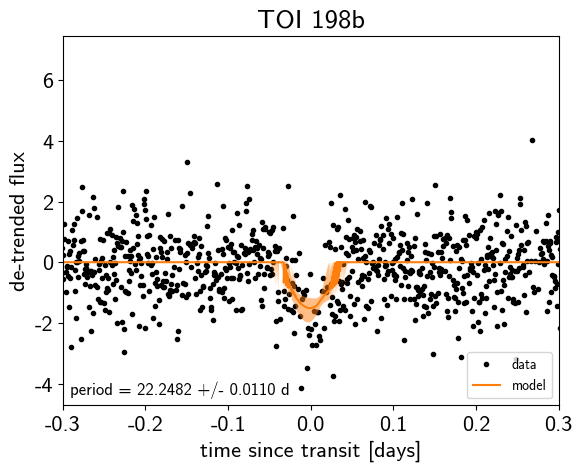

In [10]:
with model:
    light_curves = np.empty((500, len(model.x), len(periods)))
    func = xo.utils.get_theano_function_for_var(model.light_curves)
    for i, sample in enumerate(xo.utils.get_samples_from_trace(
            trace, size=len(light_curves))):
        light_curves[i] = func(*xo.utils.get_args_for_theano_function(sample))

for n, letter in enumerate(letters):
    plt.figure()

    # Compute the GP prediction
    mean_mod = np.median(trace["mean"][:, None])

    # Get the posterior median orbital parameters
    p = np.median(trace["period"][:, n])
    t0 = np.median(trace["t0"][:, n])

    # Compute the median of posterior estimate of the contribution from
    # the other planet. Then we can remove this from the data to plot
    # just the planet we care about.
    inds = np.arange(len(periods)) != n
    others = np.median(1e3*np.sum(light_curves[:, :, inds], axis=-1), axis=0)

    # Plot the folded data
    x_fold = (model.x - t0 + 0.5*p) % p - 0.5*p
    plt.plot(x_fold, model.y - mean_mod - others, ".k", label="data", zorder=-1000)

    # Plot the folded model
    inds = np.argsort(x_fold)
    inds = inds[np.abs(x_fold)[inds] < 0.3]
    pred = 1e3 * light_curves[:, inds, n]
    pred = np.percentile(pred, [16, 50, 84], axis=0)
    plt.plot(x_fold[inds], pred[1], color="C1", label="model")
    art = plt.fill_between(x_fold[inds], pred[0], pred[2], color="C1", alpha=0.5,
                           zorder=1000)
    art.set_edgecolor("none")

    # Annotate the plot with the planet's period
    txt = "period = {0:.4f} +/- {1:.4f} d".format(
        np.mean(trace["period"][:, n]), np.std(trace["period"][:, n]))
    plt.annotate(txt, (0, 0), xycoords="axes fraction",
                 xytext=(5, 5), textcoords="offset points",
                 ha="left", va="bottom", fontsize=12)

    plt.legend(fontsize=10, loc=4)
    plt.xlim(-0.5*p, 0.5*p)
    plt.xlabel("time since transit [days]")
    plt.ylabel("de-trended flux")
    plt.title("TOI {0}{1}".format(toi_num, letter));
    plt.xlim(-0.3, 0.3)

## Posterior constraints

Given the MCMC sampling, we can make some plots summarizing the constraints on the key parameters.
First up, we plot the physical radius of the planet using the stellar radius constraint from the TOI list, and the impact parameter (remember that we're using circular orbits).

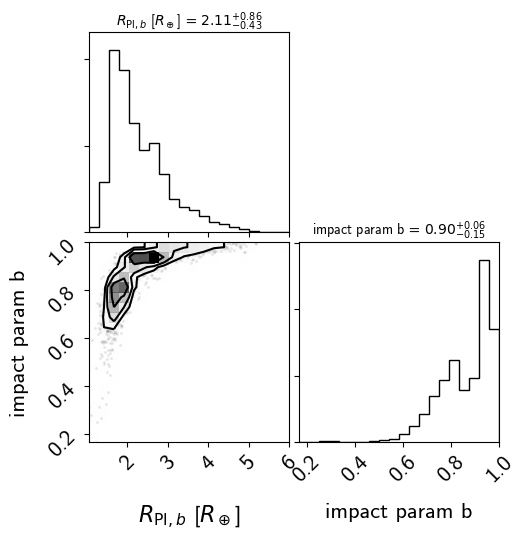

In [11]:
# Convert to Earth radii
r_pl = trace["r_pl"] * 109.07637070600963
samples = np.concatenate((r_pl, trace["b"]), axis=-1)

labels = ["$R_{{\mathrm{{Pl}},{0}}}$ [$R_\oplus$]".format(i) for i in letters]
labels += ["impact param {0}".format(i) for i in letters]

corner.corner(samples, labels=labels,
              show_titles=True, title_kwargs=dict(fontsize=10));

The other most interesting parameters are the period and transit times.

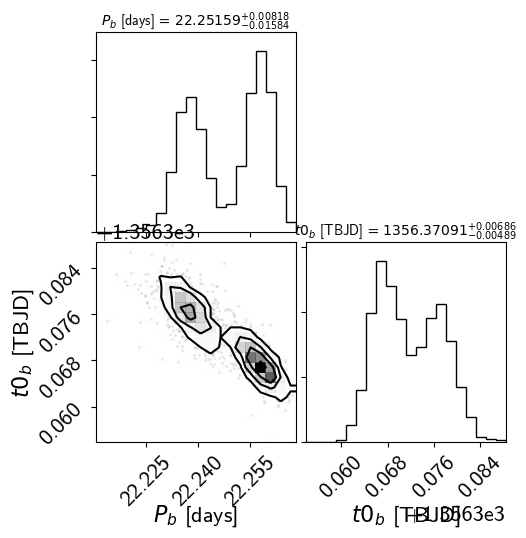

In [12]:
labels = ["$P_{{{0}}}$ [days]".format(i) for i in letters]
labels += ["$t0_{{{0}}}$ [TBJD]".format(i) for i in letters]
samples = np.concatenate((trace["period"], trace["t0"]), axis=-1)
corner.corner(samples, labels=labels,
              show_titles=True, title_fmt=".5f",
              title_kwargs=dict(fontsize=10));

Finally, here are the posterior constraints on the stellar properties.
These won't be exactly the same as the prior because the duration of the transits (and the assumption of circular orbits )

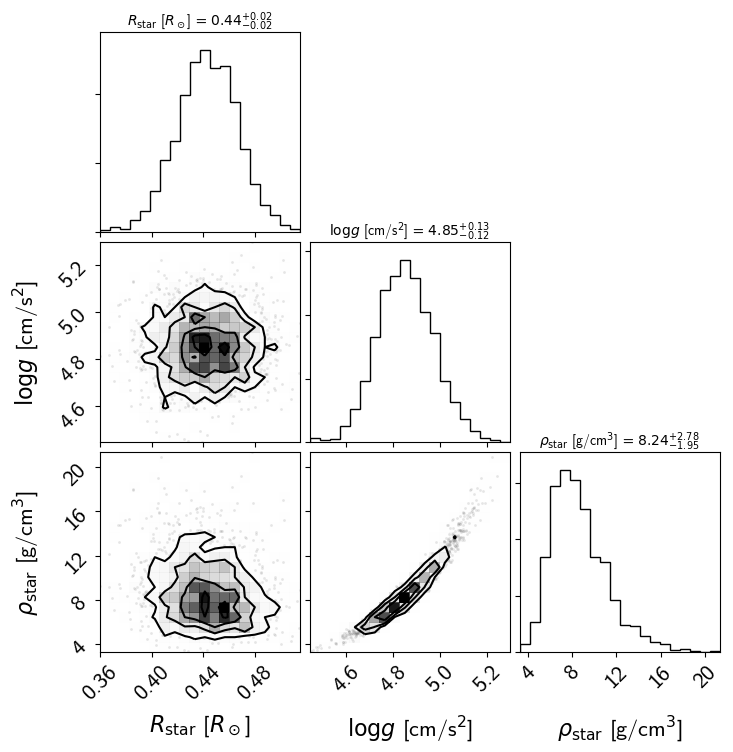

In [13]:
labels = ["$R_\mathrm{star}$ [$R_\odot$]", "$\log g$ [cm/s$^2$]",
          r"$\rho_\mathrm{star}$ [g/cm$^3$]"]
samples = np.vstack((trace["r_star"], trace["logg_star"], trace["rho_star"])).T
corner.corner(samples, labels=labels,
              show_titles=True,
              title_kwargs=dict(fontsize=10));

## Attribution

If you use these results or this code, please consider citing the relevant sources.
First, you can [cite the lightkurve package](https://zenodo.org/record/2611871):

```bibtex
@misc{lightkurve,
  author       = {Geert Barentsen and
                  Christina Hedges and
                  Zé Vinícius and
                  Nicholas Saunders and
                  gully and
                  Oliver Hall and
                  Sheila Sagear and
                  Tom Barclay and
                  KenMighell and
                  Keaton Bell and
                  Johnny Zhang and
                  Emma Turtelboom and
                  Zach Berta-Thompson and
                  Peter Williams and
                  Jose A Lerma III and
                  Guy Davies and
                  Brennan Vincello and
                  Anand Sundaram},
  title        = {KeplerGO/lightkurve: Lightkurve v1.0b30},
  month        = mar,
  year         = 2019,
  doi          = {10.5281/zenodo.2611871},
  url          = {https://doi.org/10.5281/zenodo.2611871}
}
```

You can also [cite the exoplanet project and its dependencies](https://exoplanet.dfm.io/en/stable/tutorials/citation/) using the following acknowledgement:

In [14]:
with model:
    txt, bib = xo.citations.get_citations_for_model()
print(txt)

This research made use of \textsf{exoplanet} \citep{exoplanet} and its
dependencies \citep{exoplanet:astropy13, exoplanet:astropy18,
exoplanet:espinoza18, exoplanet:exoplanet, exoplanet:kipping13,
exoplanet:luger18, exoplanet:pymc3, exoplanet:theano}.


and BibTeX entries:

In [15]:
print(bib)


@misc{exoplanet:exoplanet,
  author = {Dan Foreman-Mackey and
            Geert Barentsen and
            Tom Barclay},
   title = {dfm/exoplanet: exoplanet v0.1.5},
   month = mar,
    year = 2019,
     doi = {10.5281/zenodo.2587222},
     url = {https://doi.org/10.5281/zenodo.2587222}
}


@article{exoplanet:pymc3,
    title={Probabilistic programming in Python using PyMC3},
   author={Salvatier, John and Wiecki, Thomas V and Fonnesbeck, Christopher},
  journal={PeerJ Computer Science},
   volume={2},
    pages={e55},
     year={2016},
publisher={PeerJ Inc.}
}


@article{exoplanet:theano,
    title="{Theano: A {Python} framework for fast computation of mathematical
            expressions}",
   author={{Theano Development Team}},
  journal={arXiv e-prints},
   volume={abs/1605.02688},
     year=2016,
    month=may,
      url={http://arxiv.org/abs/1605.02688}
}


@ARTICLE{exoplanet:kipping13,
   author = {{Kipping}, D.~M.},
    title = "{Efficient, uninformative sampling of limb darke

## Environment

This notebook was run with the following conda environment:

In [16]:
!conda env export

name: tessatlas
channels:
  - defaults
dependencies:
  - astropy=3.1.2=py37h7b6447c_0
  - atomicwrites=1.3.0=py37_1
  - attrs=19.1.0=py37_1
  - blas=1.0=mkl
  - ca-certificates=2019.1.23=0
  - certifi=2019.3.9=py37_0
  - cycler=0.10.0=py37_0
  - dbus=1.13.6=h746ee38_0
  - expat=2.2.6=he6710b0_0
  - fontconfig=2.13.0=h9420a91_0
  - freetype=2.9.1=h8a8886c_1
  - glib=2.56.2=hd408876_0
  - gst-plugins-base=1.14.0=hbbd80ab_1
  - gstreamer=1.14.0=hb453b48_1
  - icu=58.2=h9c2bf20_1
  - intel-openmp=2019.3=199
  - jpeg=9b=h024ee3a_2
  - kiwisolver=1.0.1=py37hf484d3e_0
  - libedit=3.1.20181209=hc058e9b_0
  - libffi=3.2.1=hd88cf55_4
  - libgcc-ng=8.2.0=hdf63c60_1
  - libgfortran-ng=7.3.0=hdf63c60_0
  - libpng=1.6.36=hbc83047_0
  - libstdcxx-ng=8.2.0=hdf63c60_1
  - libuuid=1.0.3=h1bed415_2
  - libxcb=1.13=h1bed415_1
  - libxml2=2.9.9=he19cac6_0
  - matplotlib=3.0.3=py37h5429711_0
  - mkl=2019.3=199
  - mkl_fft=1.0.10=py37ha843d7b_0
  - mkl_random=1.0.2=py37hd81dba3_0
  - more-itertools=6.0.0=py3